# GROUND MOTION DIRECTIONALITY ANALYSIS FOR THE DESIGN AND ASSESSMENT OF STRUCTURES

This project aims to quantify the variability in the performance of structures to un certainty in seismic excitation direction. Within this setting, the project will provid engineers with practical recommendations and approximate methods by which grou d motion directionality is incorporated in design practice.

## 1. Problem statement

- **Objective**: 
  - Build the response spectrum for several earthquakes significant to the study. The earthquakes are extracted from the NGAWest2 ground motions (one component) db.
  - Model a real building. The ETSEIB will be used for this analysis.
  - Perform a modal analysis of the real building based on different spectral curves (Eurocode 8, ASCE, intensity measures, ...). Extract the displacement and acceleration at the roof.
  - Perform a Time History Analysis of the building to capture the displacement and acceleration at the roof for all possible angles of incidence of the earthquake.
  - Compare the Time History Analysis maximum results with the ones extracted from the modal analysis.
 
- **Expectations**:
  - Not all the intensity measures take into account the direction, so it would be expected that for some of the incidence angles the effects of the earthquake over the structure are bigger than the ones obtained with the design spectrum used.
  - When an earthquake is recorded with an accelerometer, the measures direction does not always give the biggest acceleration to the building. Usually N-S and E-W directions are taken, or the transversal and longitudinal ones in case of bridges. That must be taken into account in the design to avoid underestimating the effects of a seism.
  - A tradeoff between the probability of occurrence and the seismic risk and hazard on the collapse of a particular structure has to be made during the design.
  
- **References**:

  - Sections 1 and 3 from the book **Earthquake Dynamics of Structures** from the **Eartquake Engineering Research Institute EERI.**

## 2. Theoretical background

## 3. Simulation process

### 3.1. Required modules
Here there is the import of all required modules in this code. 

In [69]:
import openseespy.opensees as ops  # Opensees
import os  # to read files
import math
import numpy as np  #  multidimensional array and matrix data structures
import matplotlib.pyplot as plt  # to plot the data
import opsvis as opsv
import time as t
from tqdm import tqdm
import ipyparallel as ipp

### 3.2. Earthquake data extraction from NGA-West2

#### _Intro_

Here there is the explanation and code lines on how to extract the file data necessary to elaborate the RotD50 Response spectra of Tabas Earthquake.

From the Earthquake data (the flatfiles) it is known that the Tabas Eartquake in Iran recorded at 1978 at Tabas Station is the Record Sequence number 143 (RSN). With this number it is possible to extract the Ground Motion Data of this Earthquake.

9 different files are obtained. For each direction (horizontal and transversal in x-y plane, and vertical) can be obtained the data from acceleration, displacement and velocity.

In this code only the x (horizontal) and y (transversal) axis directions are of interest. Because with these two directions and their respective Ground Motion Data, and with $\theta$ angle, the important Ground Motion input can be obtained.

<img src="./img/2dim.png" alt="2dim" width="350" style="float: left;"/>

And with this the RotD50 Response Spectra can be ploted. 

<img src="./img/rotd50.png" alt="rotd50" width="350" style="float: left;"/>

#### _Explore ground motion data_

##### Files to read

In [70]:
#Define the path of the NGA-West2 files used
earthquakes_files = {
    'Tabas': {
        'GMD_longitudinal': './nga_west2_db/1_Tabas/tabas_RSN_143/RSN143_TABAS_TAB-L1.AT2',
        'GMD_transverse': './nga_west2_db/1_Tabas/tabas_RSN_143/RSN143_TABAS_TAB-T1.AT2',
        'spaces_numPoints': 3,
        'spaces_secs': 7
    },
    'Roermond_Netherlands': { 
        'GMD_longitudinal': './nga_west2_db/2_Roermond_Netherlands/RSN824_ROERMOND_WBS-EW.AT2',
        'GMD_transverse': './nga_west2_db/2_Roermond_Netherlands/RSN824_ROERMOND_WBS-NS.AT2',
        'spaces_numPoints': 2,
        'spaces_secs': 6
    },
    'LA_Hollywood': { 
        'GMD_longitudinal': './nga_west2_db/4_LA/RSN46_LYTLECR_PEL090.AT2',
        'GMD_transverse': './nga_west2_db/4_LA/RSN46_LYTLECR_PEL180.AT2',
        'spaces_numPoints': 3,
        'spaces_secs': 7
    },
    'Nicaragua': { 
        'GMD_longitudinal': './nga_west2_db/3_Nicaragua/RSN95_MANAGUA_A-ESO090.AT2',
        'GMD_transverse': './nga_west2_db/3_Nicaragua/RSN95_MANAGUA_A-ESO180.AT2',
        'spaces_numPoints': 3,
        'spaces_secs': 7
    },
    'Italy_2': { 
        'GMD_longitudinal': './nga_west2_db/14_Italy2/RSN121_FRIULI.A_A-BCS000.AT2',
        'GMD_transverse': './nga_west2_db/14_Italy2/RSN121_FRIULI.A_A-BCS270.AT2',
        'spaces_numPoints': 3,
        'spaces_secs': 7
    },
    'Georgia': { 
        'GMD_longitudinal': './nga_west2_db/10_Georgia/RSN816_GEORGIA_AMB--X.AT2',
        'GMD_transverse': './nga_west2_db/10_Georgia/RSN816_GEORGIA_AMB--Y.AT2',
        'spaces_numPoints': 3,
        'spaces_secs': 7
    },
    'Taiwan': { 
        'GMD_longitudinal': './nga_west2_db/6_Taiwan/RSN2790_CHICHI.04_HWA044E.AT2',
        'GMD_transverse': './nga_west2_db/6_Taiwan/RSN2790_CHICHI.04_HWA044N.AT2',
        'spaces_numPoints': 2,
        'spaces_secs': 6
    },
    'Mexico': { 
        'GMD_longitudinal': './nga_west2_db/12_Mexico/RSN167_IMPVALL.H_H-CMP015.AT2',
        'GMD_transverse': './nga_west2_db/12_Mexico/RSN167_IMPVALL.H_H-CMP285.AT2',
        'spaces_numPoints': 3,
        'spaces_secs': 7
    },
     'Sulmona_Italy': { 
        'GMD_longitudinal': './nga_west2_db/13_Sulmona_Italy/RSN4490_L-AQUILA_BM444XTE.AT2',
        'GMD_transverse': './nga_west2_db/13_Sulmona_Italy/RSN4490_L-AQUILA_BM444YLN.AT2',
        'spaces_numPoints': 2,
        'spaces_secs': 6
    },
    'Greece': { 
        'GMD_longitudinal': './nga_west2_db/9_Greece/RSN564_GREECE_H-KAL-NS.AT2',
        'GMD_transverse': './nga_west2_db/9_Greece/RSN564_GREECE_H-KAL-WE.AT2',
        'spaces_numPoints': 2,
        'spaces_secs': 6
    }
}

##### Function to read files

In [71]:
#Read the Ground Motion Data in the NGA-West2 files used
def read_NGAWest2_files(filepath, spaces_numPoints, spaces_secs):  
    """
    Read the NGAWest2 file
    
    Parameters
    ------------
    filepath : string
        location of the file
        
    Returns
    -------
    float
        dT diferential of time
    int
        number of point
    np.array
        list of ground motion acceleration
    """
    with open (filepath, "r") as GMfile:
        #put all the lines into a list
        data = GMfile.read().splitlines()
        
        #pick information from line 4 (there is the number of points and the df time differential)
        sp = data[3].split(' ')
        numPts = int(sp[spaces_numPoints].split(',')[0])
        dt = float(sp[spaces_secs])
        
        #remove headlines
        headlines = 4
        data = data[headlines:len(data)]
        
        #put acceleration data into list
        data = list(map(str.strip, data))
        data = list(map(str.split, data))
        gm = []
        for i in range(len(data)):
            for ind in range(len(data[i])):
                gm.append(float(data[i][ind]))
        
        return dt, numPts, np.array(gm)

##### Read files

In [72]:
earthquakes_data = {}
for earthquake in earthquakes_files:
    earthquakes_data[earthquake] = {
        'GMD_longitudinal': {
            'dt': 0.0,
            'numPts': 0,
            'gmdata': [],
            'time': []
        },
        'GMD_transverse': {
            'dt': 0.0,
            'numPts': 0,
            'gmdata': [],
            'time': []
        }
    }
for key in earthquakes_files:
    dt1, numPts1, gmdata1 = read_NGAWest2_files(earthquakes_files[key]['GMD_longitudinal'], earthquakes_files[key]['spaces_numPoints'], earthquakes_files[key]['spaces_secs'])
    dt2, numPts2, gmdata2 = read_NGAWest2_files(earthquakes_files[key]['GMD_transverse'], earthquakes_files[key]['spaces_numPoints'], earthquakes_files[key]['spaces_secs'])
    
    earthquakes_data[key]['GMD_longitudinal']['dt'] = dt1
    earthquakes_data[key]['GMD_longitudinal']['numPts'] = numPts1
    earthquakes_data[key]['GMD_longitudinal']['gmdata'] = gmdata1
    earthquakes_data[key]['GMD_longitudinal']['time'] = np.linspace(0.0, numPts1*dt1, numPts1, endpoint=True)

    earthquakes_data[key]['GMD_transverse']['dt'] = dt2
    earthquakes_data[key]['GMD_transverse']['numPts'] = numPts2
    earthquakes_data[key]['GMD_transverse']['gmdata'] = gmdata2
    earthquakes_data[key]['GMD_transverse']['time'] = np.linspace(0.0, numPts2*dt2, numPts2, endpoint=True)


In [73]:
import pickle
with open('earthquakes_data.txt', 'wb') as handle_earthquakes_data:
  pickle.dump(earthquakes_data, handle_earthquakes_data)

##### Plot Ground Motion Data

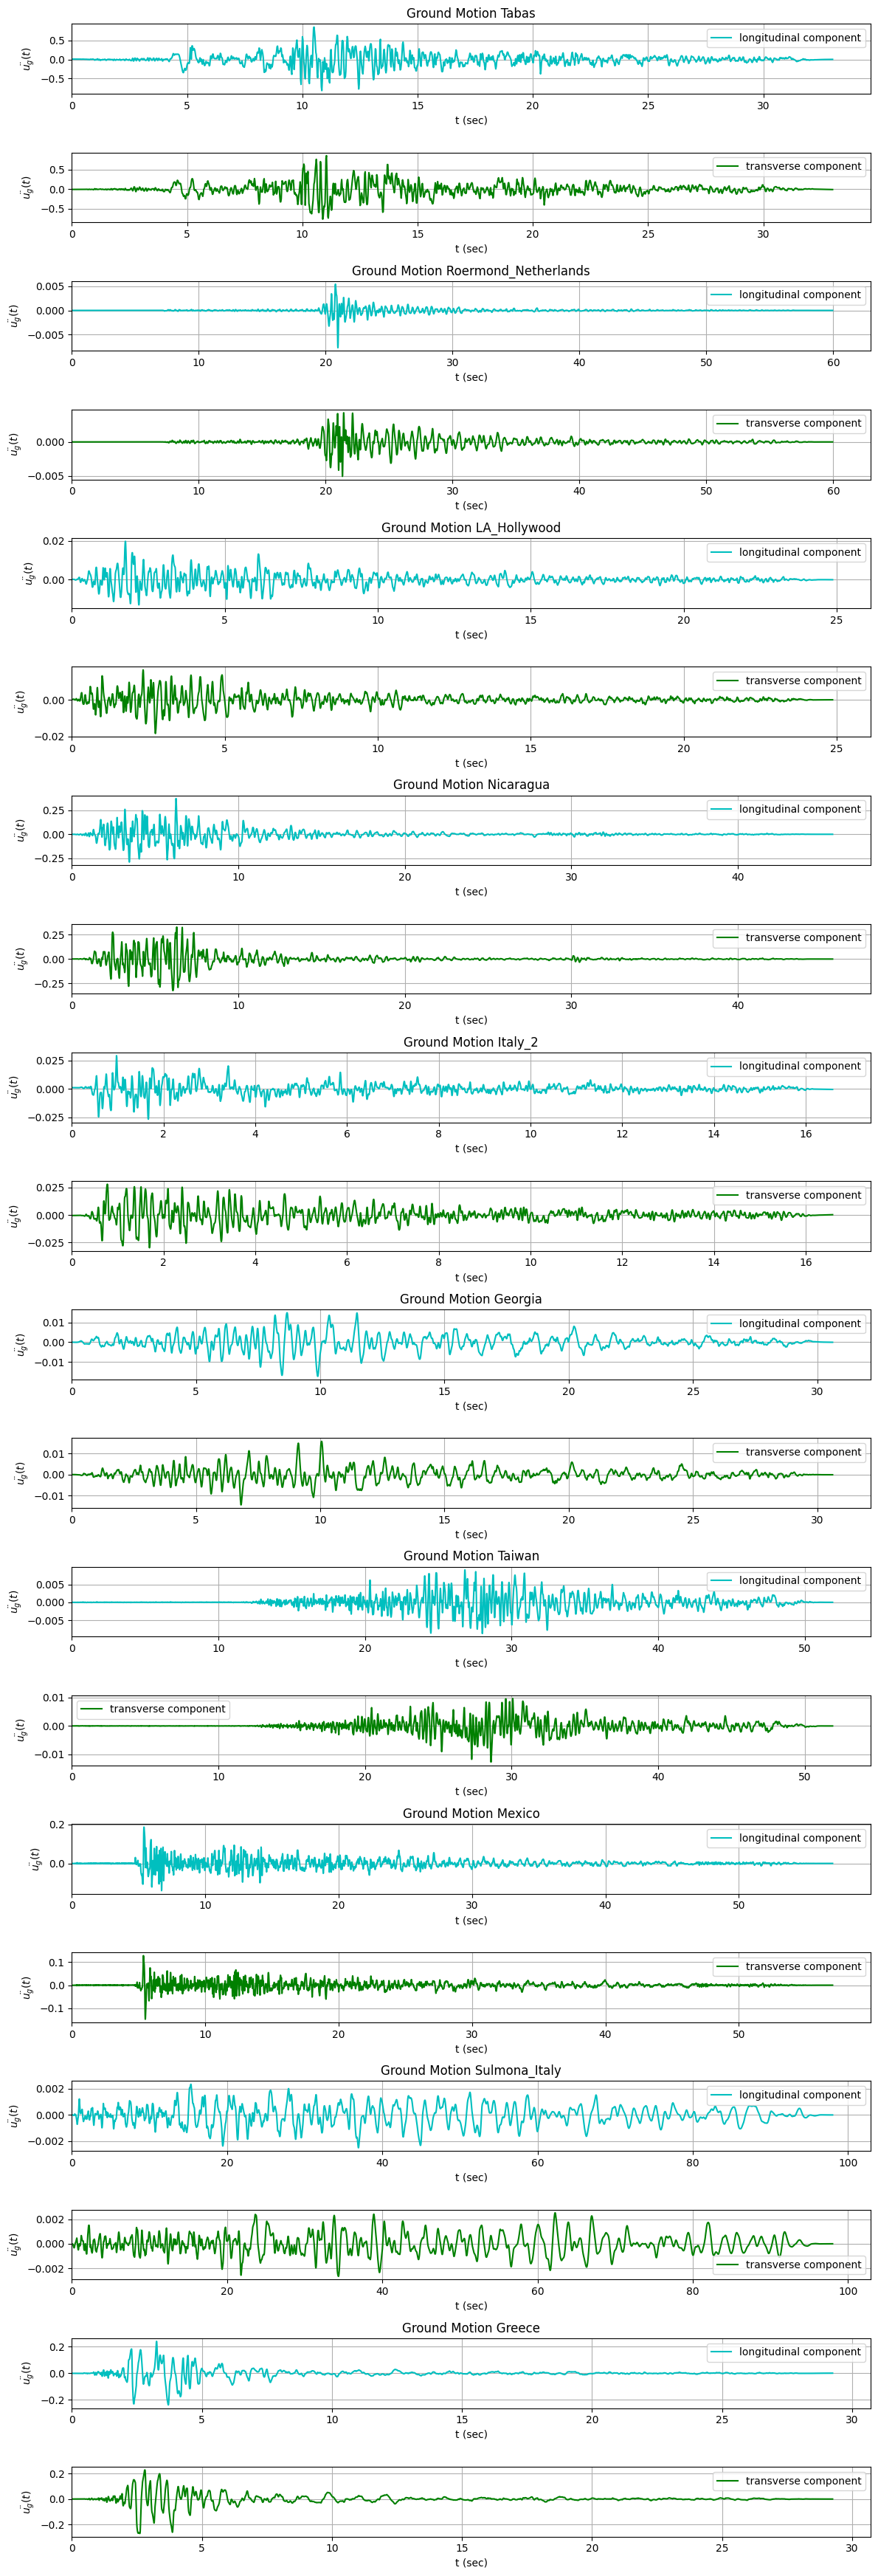

In [74]:
fig, (axs) = plt.subplots(2*len(earthquakes_data), 1, figsize=(12, 3.5*len(earthquakes_data)))
row = 0
for earthquake in earthquakes_data:
    #axs[row].setp(ax1.get_xticklabels(),visible=False)
    axs[row].plot(earthquakes_data[earthquake]['GMD_longitudinal']['time'], earthquakes_data[earthquake]['GMD_longitudinal']['gmdata'], color='c', label='longitudinal component')
    axs[row].set(ylabel='$\ddot{u_g} (t)$', xlabel='t (sec)')
    axs[row].title.set_text('Ground Motion {eth}'.format(eth=earthquake))
    axs[row].grid()
    axs[row].set_xlim(left=0)
    axs[row].legend()
    
    axs[row+1].plot(earthquakes_data[earthquake]['GMD_transverse']['time'], earthquakes_data[earthquake]['GMD_transverse']['gmdata'], color='g', label='transverse component')
    axs[row+1].set(ylabel='$\ddot{u_g} (t)$', xlabel='t (sec)')
    axs[row+1].grid()
    axs[row+1].set_xlim(left=0)
    axs[row+1].legend()

    row += 2
    
fig.tight_layout(h_pad=1.0, w_pad=0.0)
plt.show()

#### _Find the combinational direction of Horitzontal Ground Motion + Transversal Ground Motion_

In [75]:
def create_aROT(aX, aY, theta):
    """
    Create a_ROT
    
    Parameters
    ------------
    aX : np.array
        horizontal acceleration
    aY : np.array
        transversal acceleration
    theta : int
        angle
    
    Returns
    -------
    np.array
        list of a_ROT
    """
    a_ROT = aX*math.cos(np.deg2rad(theta)) + aY*math.sin(np.deg2rad(theta))
    return a_ROT

##### Plot example for one angle and Earthquake

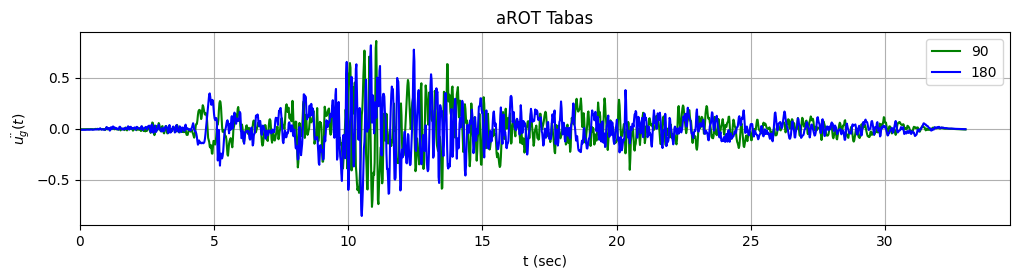

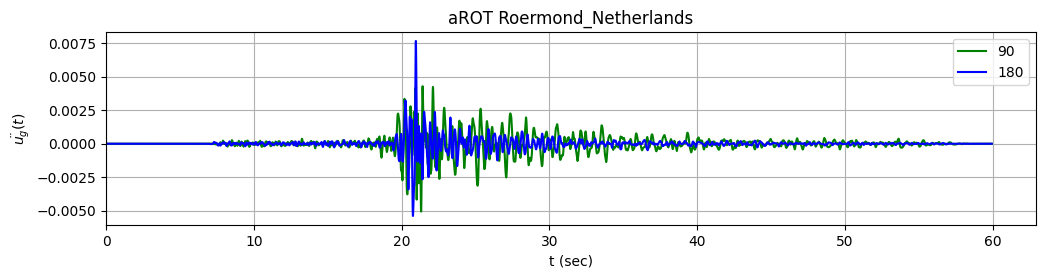

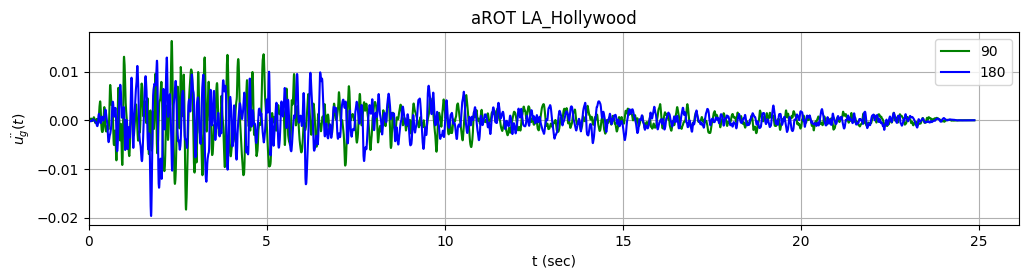

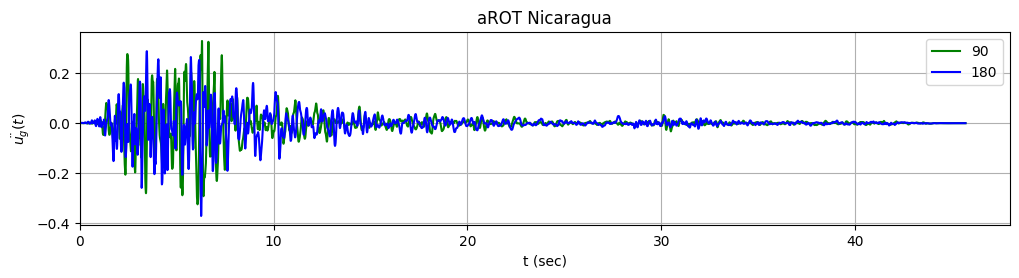

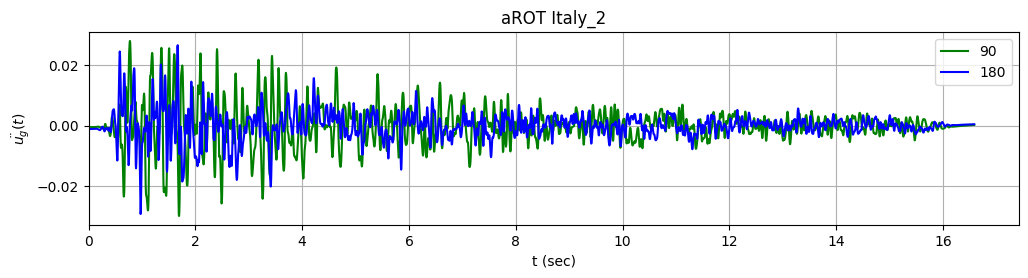

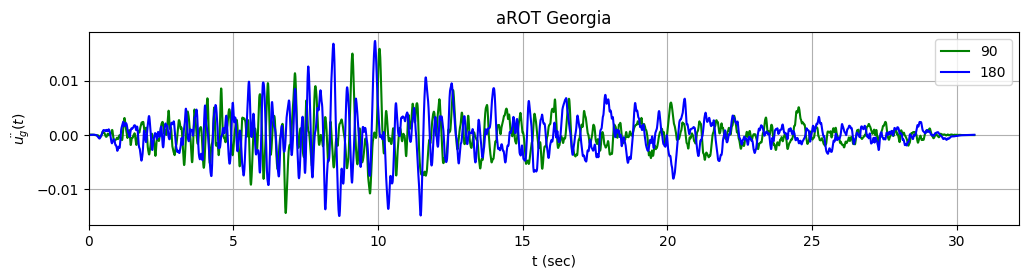

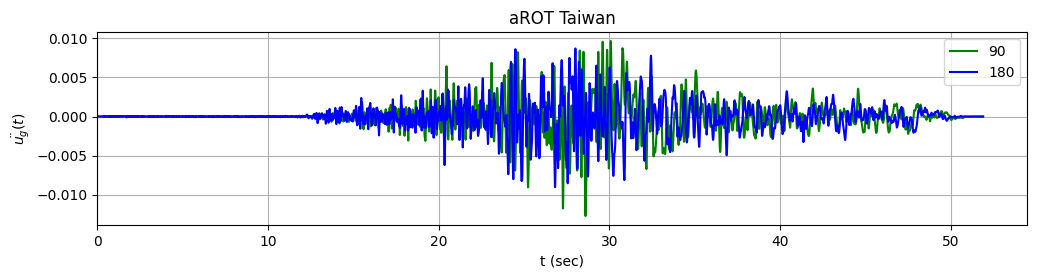

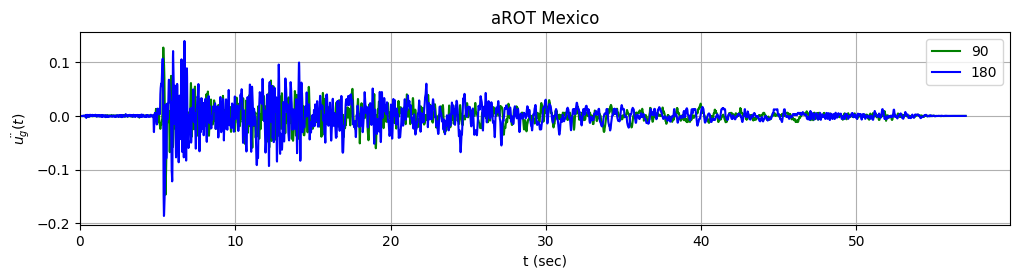

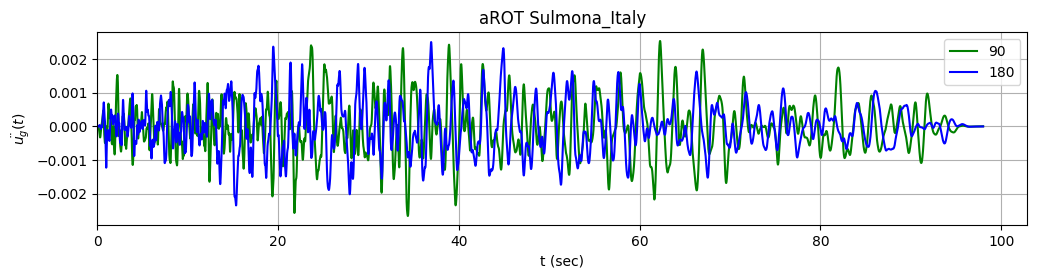

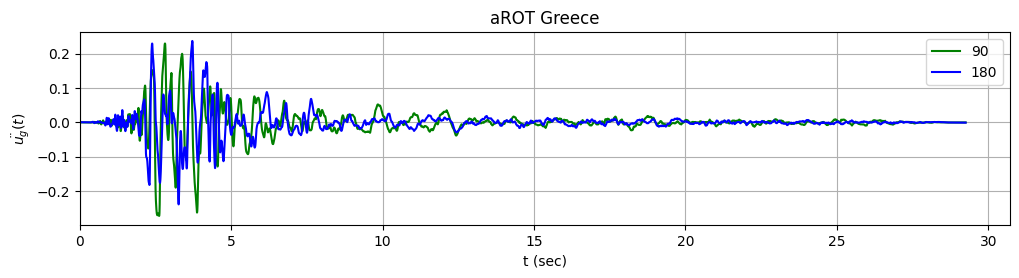

In [76]:
# Plot example of aROT for 90 and 180 degrees

for ethqke_name in earthquakes_files:
#ethqke_name = 'Tabas'

    arot_90 = create_aROT(earthquakes_data[ethqke_name]['GMD_longitudinal']['gmdata'], earthquakes_data[ethqke_name]['GMD_transverse']['gmdata'], 90)
    arot_180 = create_aROT(earthquakes_data[ethqke_name]['GMD_longitudinal']['gmdata'], earthquakes_data[ethqke_name]['GMD_transverse']['gmdata'], 180)
    
    plt.figure(figsize=(12,2.5)) #select the visualization size of the plot
    plt.plot(earthquakes_data[ethqke_name]['GMD_longitudinal']['time'], arot_90, color='g', label='90')
    plt.plot(earthquakes_data[ethqke_name]['GMD_longitudinal']['time'], arot_180, color='b', label='180')
    plt.ylabel('$\ddot{u_g} (t)$')
    plt.xlabel('t (sec)')
    plt.title('aROT {eth}'.format(eth=ethqke_name))
    plt.grid()
    plt.xlim(left=0)
    plt.legend()
    plt.show()

##### Create Rotation Angle Array

In [77]:
#Create Rotation Angle Array
d_theta = 1
initial_v = 0
final_v = 180 #degrees
N = (final_v - initial_v) / d_theta
theta_list = np.linspace(initial_v, final_v, num = int(N+1), endpoint=True)

### 3.3. Response Spectra

#### 3.3.1. SDOF system functions

##### 3.3.1.1. SDOF model definition

In [9]:
# Model definition
g = 9.81 # gravity [m/s^2]

def model_definition_SDOF(period, damping):
    """
    Configure a SDOF model in opensees
    
    Parameters
    ------------
    period : float
        natural period of the structure (Tn [sec])
    
    Returns
    --------
    None
    """
    # Model variables
    L = 1.0 # lollipop column length [m] 
    d = 2 # column diameter [m]                    
    r = d/2 # column radius [m]              
    A = np.pi*(r**2) # Area of the circular column [m^2]   
    E = 1.0  # Elastic Modulus
    G = 1.0  # Shear Modulus
    Izz = np.pi*(r**4)/4 # Moment of Inertia in zz axis                
    J = np.pi*(r**4)/2  # Polar Moment of Inertia
    Iyy = np.pi*(r**4)/4  # Moment of Inertia in yy axis
    K = 3*E*Izz/(L**3)   # Stiffness 
    # Natural frequency w0 = sqrt(k/m) and w0 = (2*pi)/T
    m = K*(period**2)/4/(np.pi**2)  # Mass

    node_bottom=1
    node_top=2
    
    # Model
    ops.model('basic', '-ndm', 3, '-ndf', 6)
            
    # Create nodes
    ops.node(node_bottom, 0.0, 0.0, 0.0)
    ops.node(node_top, 0.0,0.0,L)
    
    # Transformation
    transfTag = 1
    ops.geomTransf('Linear',transfTag,0.0,1.0,0.0)
    
    # Define mass
    ops.mass(node_top, m, m, 0.0, 0.0, 0.0, 0.0)

    # Constraints of the model
    ops.fix(node_bottom, 1, 1, 1, 1, 1, 1)   
    
    # Define material
    ops.uniaxialMaterial('Elastic', 11, K)
    
    # Define element
    ops.element('elasticBeamColumn', 12, *[node_bottom, node_top], A,E,G,J,Iyy,Izz,1)
      
    # Define Rayleigh damping
    omega = (2*np.pi)/period 
    alpha_m = 2*damping*omega
    ops.rayleigh(alpha_m, 0, 0, 0)  

##### 3.3.1.2. SDOF analysis definition

In [10]:
# analysis definition
dt = 0.02 # is like the precision of the time series
def define_analysis_SDOF(time, gm1, gm2):
    """
    Configure the analysis type
    
    Parameters
    ------------
    time : np.array
        array of time values
    gm1 : np.array
        array of longitudinal GM
    gm2 : np.array
        array of transverse GM
        
    Returns
    --------
    None
    """
    ops.timeSeries('Path', 1, '-dt', dt, '-values', *gm1*g, '-time', *time)
    ops.timeSeries('Path', 2, '-dt', dt, '-values', *gm2*g, '-time', *time)
    ops.pattern('UniformExcitation', 1, 1, '-accel', 1)
    ops.pattern('UniformExcitation', 2, 2, '-accel', 2)
    ops.constraints('Transformation')
    ops.numberer('Plain')
    ops.system('ProfileSPD')
    ops.algorithm('Linear', False, False, True)
    ops.integrator('Newmark', 0.5, 0.25)
    ops.analysis('Transient')  

##### 3.3.1.3. SDOF system solver

In [11]:
# Solve system
def solve_system_SDOF(period, damping, time, gm1, gm2, analysis_dt):
    """
    Solve the opensees system
    
    Parameters
    ------------
    period : float
        natural period of the structure (T [sec])
    damping : float
        damping value
    time : np.array
        array of time values
    gm1 : np.array
        array of longitudinal GM
    gm2 : np.array
        array of transverse GM
    analysis_dt : float
        temporal step for each iteration of the simulation
        
    Returns
    --------
    dictionary
        dictionary with 'displacement', 'velocity' and 'acceleration' keys
    """

    ops.wipe()
    
    # Model Definition
    model_definition_SDOF(period, damping)
        
    # Analysis Definition
    define_analysis_SDOF(time, gm1, gm2)
        
    outputs_x = {
        'displacement':[],
        'velocity':[], 
        'acceleration':[]
    }
    
    outputs_y = {
        'displacement':[],
        'velocity':[], 
        'acceleration':[]
    }
    
    axis_outputs = {
        'X': outputs_x,
        'Y': outputs_y,
    }
    
    node_bottom=1
    node_top=2
    
    # Solve system
    analysis_time = time[-1]
    while ops.getTime() < analysis_time:
        ops.analyze(1, analysis_dt)
        axis_outputs['X']['displacement'].append(ops.nodeDisp(node_top, 1))
        axis_outputs['X']['velocity'].append(ops.nodeVel(node_top, 1))
        axis_outputs['X']['acceleration'].append(ops.nodeAccel(node_top, 1))
        
        axis_outputs['Y']['displacement'].append(ops.nodeDisp(node_top, 2))
        axis_outputs['Y']['velocity'].append(ops.nodeVel(node_top, 2))
        axis_outputs['Y']['acceleration'].append(ops.nodeAccel(node_top, 2))     
        
    return axis_outputs

#### 3.3.2. Intensity measures for the response spectra functions

##### 3.3.2.1. RotDnn spectra

In [12]:
def get_ROTD(rotD_type, period, damping, time, gm1, gm2, analysis_dt):
    """
    Obtain ROTD
    
    Parameters
    ------------
    rotD_type : str
        '00', '50' or '100'
    period : float
        natural period of the structure (T [sec])
    damping : float
        damping value
    time : np.array
        array of time values
    gm1 : np.array
        array of longitudinal GM
    gm2 : np.array
        array of transverse GM
    analysis_dt : float
        temporal step for each iteration of the simulation
        
    Returns
    --------
    dictionary
        dictionary with ROTD
    """
    numpyfunction = ''
    if rotD_type == '50':
        numpyfunction = np.median
    elif rotD_type == '100':
        numpyfunction = np.max
    elif rotD_type == '00':
        numpyfunction = np.min
            
    responseSpectra = {
        'displacement':[],
        'velocity':[], 
        'acceleration':[]
    }
    ROTD = {
        'displacement':0,
        'velocity':0, 
        'acceleration':0
    }
    for i in range(len(theta_list)):
        a_ROT = create_aROT(gm1, gm2, theta_list[i])
        a_ROT_x = a_ROT*math.cos(np.deg2rad(theta_list[i]))
        a_ROT_y = a_ROT*math.sin(np.deg2rad(theta_list[i]))
        results = solve_system_SDOF(period, damping, time, a_ROT_x, a_ROT_y, analysis_dt)

        responseSpectra['displacement'].append(
            np.abs(np.sqrt(
                np.max(np.abs(np.power(np.array(results['X']['displacement']), 2))) + 
                np.max(np.abs(np.power(np.array(results['Y']['displacement']), 2)))
            ))/g
        )
        responseSpectra['velocity'].append(
            np.abs(np.sqrt(
                np.max(np.abs(np.power(np.array(results['X']['velocity']), 2))) + 
                np.max(np.abs(np.power(np.array(results['Y']['velocity']), 2)))
            ))/g
        )
        responseSpectra['acceleration'].append(
            np.abs(np.sqrt(
                np.max(np.abs(np.power(np.array(results['X']['acceleration']), 2))) + 
                np.max(np.abs(np.power(np.array(results['Y']['acceleration']), 2)))
            ))/g
        )
        
    ROTD['displacement'] = numpyfunction(responseSpectra['displacement'])
    ROTD['velocity'] = numpyfunction(responseSpectra['velocity'])
    ROTD['acceleration'] = numpyfunction(responseSpectra['acceleration'])
    
    return ROTD

##### 3.3.2.2. Max spectra

In [13]:
def get_MaxSpectra(period, damping, time, gm1, gm2, analysis_dt):
    """
    Obtain ROTD
    
    Parameters
    ------------
    damping : float
        damping value
    time : np.array
        array of time values
    gm1 : np.array
        array of longitudinal GM
    gm2 : np.array
        array of transverse GM
    analysis_dt : float
        temporal step for each iteration of the simulation
        
    Returns
    --------
    dictionary
        dictionary with max spectra
    """
            
    componentSpectra = {
        'displacement':0,
        'velocity':0, 
        'acceleration':0
    }
    
    results = solve_system_SDOF(period, damping, time, gm1, gm2, analysis_dt)
       
    componentSpectra['displacement'] = np.max(
        np.array([
            np.max(np.abs(np.array(results['X']['displacement']))),
            np.max(np.abs(np.array(results['Y']['displacement'])))
        ])/g
    )
    componentSpectra['velocity'] = np.max(
        np.array([
            np.max(np.abs(np.array(results['X']['velocity']))),
            np.max(np.abs(np.array(results['Y']['velocity'])))
        ])/g
    )
    componentSpectra['acceleration'] = np.max(
        np.array([
            np.max(np.abs(np.array(results['X']['acceleration']))),
            np.max(np.abs(np.array(results['Y']['acceleration'])))
        ])/g
    )
    return componentSpectra

##### 3.3.2.3. Component spectra

In [14]:
def get_ComponentSpectra(component, period, damping, time, gm1, gm2, analysis_dt):
    """
    Obtain get_ComponentSpectra
    
    Parameters
    ------------
    component: str
        'X' or 'Y'
    damping : float
        damping value
    time : np.array
        array of time values
    gm1 : np.array
        array of longitudinal GM
    gm2 : np.array
        array of transverse GM
    analysis_dt : float
        temporal step for each iteration of the simulation
        
    Returns
    --------
    dictionary
        dictionary with component spectra
    """
            
    componentSpectra = {
        'displacement':0,
        'velocity':0, 
        'acceleration':0
    }
    
    results = solve_system_SDOF(period, damping, time, gm1, gm2, analysis_dt)
       
    componentSpectra['displacement'] = np.max(np.abs(np.array(results[component]['displacement'])))/g
    componentSpectra['velocity'] = np.max(np.abs(np.array(results[component]['velocity'])))/g
    componentSpectra['acceleration'] = np.max(np.abs(np.array(results[component]['acceleration'])))/g
    
    return componentSpectra

##### 3.3.2.4. Geomean spectra

In [15]:
def get_GeoMean(period, damping, time, gm1, gm2, analysis_dt):
    """
    Obtain get_GeoMean
    
    Parameters
    ------------
    damping : float
        damping value
    time : np.array
        array of time values
    gm1 : np.array
        array of longitudinal GM
    gm2 : np.array
        array of transverse GM
    analysis_dt : float
        temporal step for each iteration of the simulation
        
    Returns
    --------
    dictionary
        dictionary with geometric mean spectra
    """
            
    geomean = {
        'displacement':0,
        'velocity':0, 
        'acceleration':0
    }
    
    results = solve_system_SDOF(period, damping, time, gm1, gm2, analysis_dt)
       
    geomean['displacement'] = np.max(np.abs(np.sqrt(np.abs(np.array(results['X']['displacement']))*np.abs(np.array(results['Y']['displacement'])))))/g
    geomean['velocity'] = np.max(np.abs(np.sqrt(np.abs(np.array(results['X']['velocity']))*np.abs(np.array(results['Y']['velocity'])))))/g
    geomean['acceleration'] = np.max(np.abs(np.sqrt(np.abs(np.array(results['X']['acceleration']))*np.abs(np.array(results['Y']['acceleration'])))))/g
    
    return geomean

##### 3.3.2.5. SRSS spectra

In [16]:
def get_SRSS(period, damping, time, gm1, gm2, analysis_dt):
    """
    Obtain ROTD
    
    Parameters
    ------------
    damping : float
        damping value
    time : np.array
        array of time values
    gm1 : np.array
        array of longitudinal GM
    gm2 : np.array
        array of transverse GM
    analysis_dt : float
        temporal step for each iteration of the simulation
        
    Returns
    --------
    dictionary
        dictionary with SRSS
    """
            
    SRSS = {
        'displacement':0,
        'velocity':0, 
        'acceleration':0
    }
    
    results = solve_system_SDOF(period, damping, time, gm1, gm2, analysis_dt)
       
    SRSS['displacement'] = np.max(
        np.abs(np.sqrt(
            np.power(np.array(results['X']['displacement']), 2) + 
            np.power(np.array(results['Y']['displacement']), 2)
        ))/g
    )
    SRSS['velocity'] = np.max(
        np.abs(np.sqrt(
            np.power(np.array(results['X']['velocity']), 2) + 
            np.power(np.array(results['Y']['velocity']), 2)
        ))/g
    )
    SRSS['acceleration'] = np.max(
        np.abs(np.sqrt(
            np.power(np.array(results['X']['acceleration']), 2) + 
            np.power(np.array(results['Y']['acceleration']), 2)
        ))/g
    )
    return SRSS

##### 3.3.2.6. Eurocode 8

<img src="./img/rs_eurocode8.png" alt="2dim" width="350" style="float: left;"/>

###### ELASTIC SPECTRA

In [17]:
# Eurocode 8 data for the building under analysis
Tb = 0.1
Tc = 0.25
Td = 1.20
S = 1.50
q = 4.00
gamma = 1.2
ag = 0.05
def get_Eurocode8(T):
    euro8 = {
        'displacement':0,
        'velocity':0, 
        'acceleration':0
    }
    if T < Tb:
        euro8['acceleration'] = ag*gamma*S*(1 + 1.5*(T/Tb))
    elif Tb <= T < Tc:
        euro8['acceleration'] = ag*gamma*S*2.5
    elif Tc <= T < Td:
        euro8['acceleration'] = ag*gamma*S*2.5*(Tc/T)
    else:
        euro8['acceleration'] = ag*gamma*S*2.5*((Tc*Td)/math.pow(T,2))

    euro8['displacement'] = (math.pow(T, 2))*euro8['acceleration']/(4*math.pow(math.pi, 2))
    euro8['velocity'] = T*euro8['acceleration']/(math.pi*2)
    
    return euro8

###### DESIGN SPECTRA

In [18]:
# Eurocode 8 data for the building under analysis
Tb = 0.1
Tc = 0.25
Td = 1.20
S = 1.50
q = 4.00
gamma = 1.2
ag = 0.05
def get_Eurocode8_design(T):
    euro8 = {
        'displacement':0,
        'velocity':0, 
        'acceleration':0
    }
    if T < Tb:
        euro8['acceleration'] = ag*gamma*S*((2/3)+(T/Tb)*((2.5/q)-(2/3)))
    elif Tb <= T < Tc:
        euro8['acceleration'] = ag*gamma*S*2.5/q
    elif Tc <= T < Td:
        euro8['acceleration'] = ag*gamma*S*(2.5/q)*(Tc/T)
    else:
        euro8['acceleration'] = ag*gamma*S*(2.5/q)*((Tc*Td)/math.pow(T,2))

    euro8['displacement'] = (math.pow(T, 2))*euro8['acceleration']/(4*math.pow(math.pi, 2))
    euro8['velocity'] = T*euro8['acceleration']/(math.pi*2)
    
    return euro8

##### 3.3.2.7. ASCE

In [19]:
# ASCE data for the building under analysis
To = 0.076
Ts = 0.383
Tl = 11.77
Sds = 0.292
Sd1 = 0.112

def get_asce(T):
    asce = {
        'displacement':0,
        'velocity':0, 
        'acceleration':0
    }
    if T < To:
        asce['acceleration'] = Sds*(0.4+0.6*(T/To))
    elif To <= T < Ts:
        asce['acceleration'] = Sds
    elif Ts <= T < Tl:
        asce['acceleration'] = Sd1/T
    else:
        asce['acceleration'] = (Sd1*Tl)/math.pow(T, 2)

    asce['displacement'] = (math.pow(T, 2))*asce['acceleration']/(4*math.pow(math.pi, 2))
    asce['velocity'] = T*asce['acceleration']/(math.pi*2)
    
    return asce

#### 3.3.3. Compute the response spectras

In [20]:
damping = 0.05

IMs_dict = {}
for key in earthquakes_data:
    IMs_dict[key] = {
    'RotD100': {
        'displacement':[],
        'velocity':[], 
        'acceleration':[]
    },
    'RotD50': {
        'displacement':[],
        'velocity':[], 
        'acceleration':[]
    },
    'RotD00': {
        'displacement':[],
        'velocity':[], 
        'acceleration':[]
    },
    'SRSS': {
        'displacement':[],
        'velocity':[], 
        'acceleration':[]
    },
    'Max': {
        'displacement':[],
        'velocity':[], 
        'acceleration':[]
    },
    'X': {
        'displacement':[],
        'velocity':[], 
        'acceleration':[]
    },
    'Y': {
        'displacement':[],
        'velocity':[], 
        'acceleration':[]
    },
    'Geomean': {
        'displacement':[],
        'velocity':[], 
        'acceleration':[]
    },
    'Eurocode8': {
        'displacement':[],
        'velocity':[], 
        'acceleration':[]
    },
    'Eurocode8_design': {
        'displacement':[],
        'velocity':[], 
        'acceleration':[]
    },
    'asce': {
        'displacement':[],
        'velocity':[], 
        'acceleration':[]
    }
}

responseSpectrumPeriods = np.linspace(0.1, 10, 75, endpoint=True)

for earthquake in earthquakes_data:
    for i in tqdm(range(len(responseSpectrumPeriods)), desc='Calculating spectra for Earthquake: {ethqk}'.format(ethqk=earthquake)):
        rotd100 = get_ROTD('100', responseSpectrumPeriods[i], damping, earthquakes_data[earthquake]['GMD_longitudinal']['time'], earthquakes_data[earthquake]['GMD_longitudinal']['gmdata'], earthquakes_data[earthquake]['GMD_transverse']['gmdata'], earthquakes_data[earthquake]['GMD_longitudinal']['dt'])
        IMs_dict[earthquake]['RotD100']['displacement'].append(rotd100['displacement'])
        IMs_dict[earthquake]['RotD100']['velocity'].append(rotd100['velocity'])
        IMs_dict[earthquake]['RotD100']['acceleration'].append(rotd100['acceleration'])
    
        rotd50 = get_ROTD('50', responseSpectrumPeriods[i], damping, earthquakes_data[earthquake]['GMD_longitudinal']['time'], earthquakes_data[earthquake]['GMD_longitudinal']['gmdata'], earthquakes_data[earthquake]['GMD_transverse']['gmdata'], earthquakes_data[earthquake]['GMD_longitudinal']['dt'])
        IMs_dict[earthquake]['RotD50']['displacement'].append(rotd50['displacement'])
        IMs_dict[earthquake]['RotD50']['velocity'].append(rotd50['velocity'])
        IMs_dict[earthquake]['RotD50']['acceleration'].append(rotd50['acceleration'])
    
        rotd00 = get_ROTD('00', responseSpectrumPeriods[i], damping, earthquakes_data[earthquake]['GMD_longitudinal']['time'], earthquakes_data[earthquake]['GMD_longitudinal']['gmdata'], earthquakes_data[earthquake]['GMD_transverse']['gmdata'], earthquakes_data[earthquake]['GMD_longitudinal']['dt'])
        IMs_dict[earthquake]['RotD00']['displacement'].append(rotd00['displacement'])
        IMs_dict[earthquake]['RotD00']['velocity'].append(rotd00['velocity'])
        IMs_dict[earthquake]['RotD00']['acceleration'].append(rotd00['acceleration'])
        
        srss = get_SRSS(responseSpectrumPeriods[i], damping, earthquakes_data[earthquake]['GMD_longitudinal']['time'], earthquakes_data[earthquake]['GMD_longitudinal']['gmdata'], earthquakes_data[earthquake]['GMD_transverse']['gmdata'], earthquakes_data[earthquake]['GMD_longitudinal']['dt'])
        IMs_dict[earthquake]['SRSS']['displacement'].append(srss['displacement'])
        IMs_dict[earthquake]['SRSS']['velocity'].append(srss['velocity'])
        IMs_dict[earthquake]['SRSS']['acceleration'].append(srss['acceleration'])
    
        maxSpectra = get_MaxSpectra(responseSpectrumPeriods[i], damping, earthquakes_data[earthquake]['GMD_longitudinal']['time'], earthquakes_data[earthquake]['GMD_longitudinal']['gmdata'], earthquakes_data[earthquake]['GMD_transverse']['gmdata'], earthquakes_data[earthquake]['GMD_longitudinal']['dt'])
        IMs_dict[earthquake]['Max']['displacement'].append(maxSpectra['displacement'])
        IMs_dict[earthquake]['Max']['velocity'].append(rotd50['velocity'])
        IMs_dict[earthquake]['Max']['acceleration'].append(maxSpectra['acceleration'])
    
        componentX = get_ComponentSpectra('X', responseSpectrumPeriods[i], damping, earthquakes_data[earthquake]['GMD_longitudinal']['time'], earthquakes_data[earthquake]['GMD_longitudinal']['gmdata'], earthquakes_data[earthquake]['GMD_transverse']['gmdata'], earthquakes_data[earthquake]['GMD_longitudinal']['dt'])
        IMs_dict[earthquake]['X']['displacement'].append(componentX['displacement'])
        IMs_dict[earthquake]['X']['velocity'].append(componentX['velocity'])
        IMs_dict[earthquake]['X']['acceleration'].append(componentX['acceleration'])
    
        componentY = get_ComponentSpectra('Y', responseSpectrumPeriods[i], damping, earthquakes_data[earthquake]['GMD_longitudinal']['time'], earthquakes_data[earthquake]['GMD_longitudinal']['gmdata'], earthquakes_data[earthquake]['GMD_transverse']['gmdata'], earthquakes_data[earthquake]['GMD_longitudinal']['dt'])
        IMs_dict[earthquake]['Y']['displacement'].append(componentY['displacement'])
        IMs_dict[earthquake]['Y']['velocity'].append(componentY['velocity'])
        IMs_dict[earthquake]['Y']['acceleration'].append(componentY['acceleration'])
    
        geomean = get_GeoMean(responseSpectrumPeriods[i], damping, earthquakes_data[earthquake]['GMD_longitudinal']['time'], earthquakes_data[earthquake]['GMD_longitudinal']['gmdata'], earthquakes_data[earthquake]['GMD_transverse']['gmdata'], earthquakes_data[earthquake]['GMD_longitudinal']['dt'])
        IMs_dict[earthquake]['Geomean']['displacement'].append(geomean['displacement'])
        IMs_dict[earthquake]['Geomean']['velocity'].append(geomean['velocity'])
        IMs_dict[earthquake]['Geomean']['acceleration'].append(geomean['acceleration'])
    
        euro8 = get_Eurocode8(responseSpectrumPeriods[i])
        IMs_dict[earthquake]['Eurocode8']['displacement'].append(euro8['displacement'])
        IMs_dict[earthquake]['Eurocode8']['velocity'].append(euro8['velocity'])
        IMs_dict[earthquake]['Eurocode8']['acceleration'].append(euro8['acceleration'])

        euro8_design = get_Eurocode8_design(responseSpectrumPeriods[i])
        IMs_dict[earthquake]['Eurocode8_design']['displacement'].append(euro8_design['displacement'])
        IMs_dict[earthquake]['Eurocode8_design']['velocity'].append(euro8_design['velocity'])
        IMs_dict[earthquake]['Eurocode8_design']['acceleration'].append(euro8_design['acceleration'])

        asce = get_asce(responseSpectrumPeriods[i])
        IMs_dict[earthquake]['asce']['displacement'].append(asce['displacement'])
        IMs_dict[earthquake]['asce']['velocity'].append(asce['velocity'])
        IMs_dict[earthquake]['asce']['acceleration'].append(asce['acceleration'])

Calculating spectra for Earthquake: Tabas: 100%|█| 75/75 [16
Calculating spectra for Earthquake: Roermond_Netherlands: 10
Calculating spectra for Earthquake: LA_Hollywood: 100%|█| 75
Calculating spectra for Earthquake: Nicaragua: 100%|█| 75/75
Calculating spectra for Earthquake: Italy_2: 100%|█| 75/75 [
Calculating spectra for Earthquake: Georgia: 100%|█| 75/75 [
Calculating spectra for Earthquake: Taiwan: 100%|█| 75/75 [1
Calculating spectra for Earthquake: Mexico: 100%|█| 75/75 [5
Calculating spectra for Earthquake: Sulmona_Italy: 100%|█| 7
Calculating spectra for Earthquake: Greece: 100%|█| 75/75 [1


In [61]:
with open('IMs_dict.txt', 'wb') as handle_ims_dicts:
  pickle.dump(IMs_dict, handle_ims_dicts)

#### 3.3.4. Plot response spectras

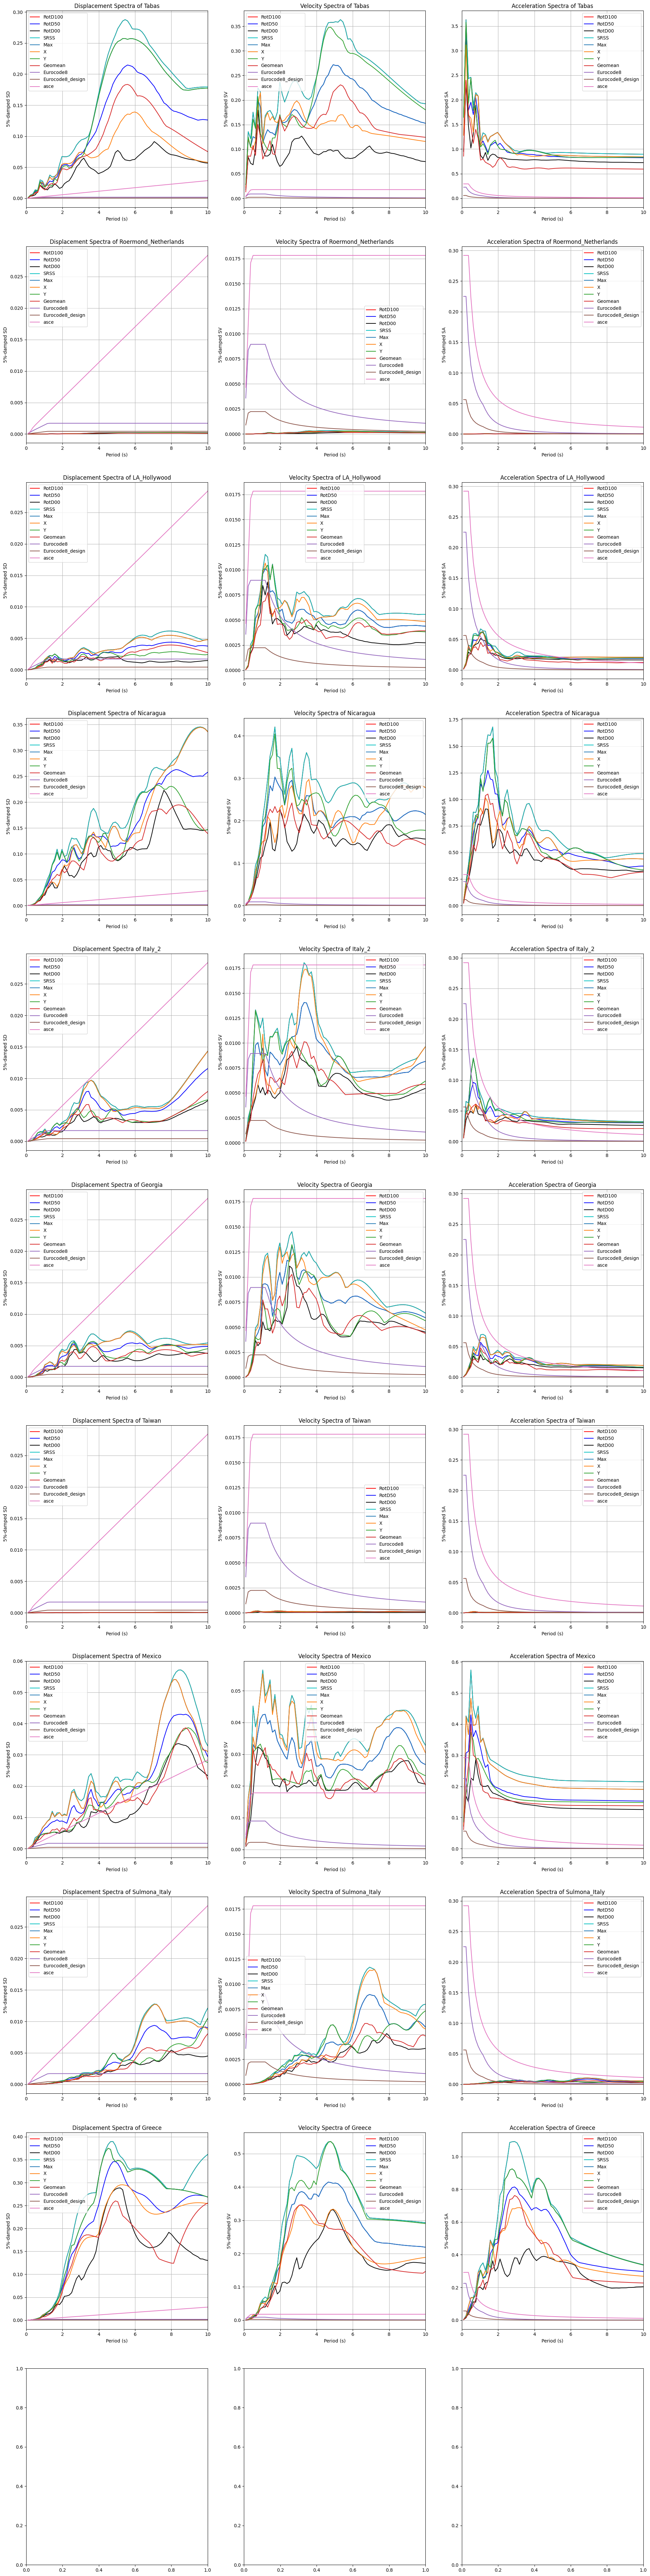

In [78]:
# Plot data
fig, (axs) = plt.subplots(len(earthquakes_data)+1, 3, figsize=(24, 10*len(earthquakes_data)))
row = 0
for earthquake in earthquakes_data:
    axs[row, 0].plot(responseSpectrumPeriods, IMs_dict[earthquake]['RotD100']['displacement'], color='r', label='RotD100')
    axs[row, 0].plot(responseSpectrumPeriods, IMs_dict[earthquake]['RotD50']['displacement'], color='b', label='RotD50')
    axs[row, 0].plot(responseSpectrumPeriods, IMs_dict[earthquake]['RotD00']['displacement'], color='k', label='RotD00')
    axs[row, 0].plot(responseSpectrumPeriods, IMs_dict[earthquake]['SRSS']['displacement'], color='c', label='SRSS')
    axs[row, 0].plot(responseSpectrumPeriods, IMs_dict[earthquake]['Max']['displacement'], label='Max')
    axs[row, 0].plot(responseSpectrumPeriods, IMs_dict[earthquake]['X']['displacement'], label='X')
    axs[row, 0].plot(responseSpectrumPeriods, IMs_dict[earthquake]['Y']['displacement'], label='Y')
    axs[row, 0].plot(responseSpectrumPeriods, IMs_dict[earthquake]['Geomean']['displacement'], label='Geomean')
    axs[row, 0].plot(responseSpectrumPeriods, IMs_dict[earthquake]['Eurocode8']['displacement'], label='Eurocode8')
    axs[row, 0].plot(responseSpectrumPeriods, IMs_dict[earthquake]['Eurocode8_design']['displacement'], label='Eurocode8_design')
    axs[row, 0].plot(responseSpectrumPeriods, IMs_dict[earthquake]['asce']['displacement'], label='asce')
    axs[row, 0].set(ylabel='5%-damped SD', xlabel='Period (s)')
    axs[row, 0].title.set_text('Displacement Spectra of {ethqk}'.format(ethqk=earthquake))
    axs[row, 0].grid()
    axs[row, 0].legend()
    axs[row, 0].set_xlim(left=0)
    axs[row, 0].set_xlim(right=math.ceil(max(responseSpectrumPeriods)))

    axs[row, 1].plot(responseSpectrumPeriods, IMs_dict[earthquake]['RotD100']['velocity'], color='r', label='RotD100')
    axs[row, 1].plot(responseSpectrumPeriods, IMs_dict[earthquake]['RotD50']['velocity'], color='b', label='RotD50')
    axs[row, 1].plot(responseSpectrumPeriods, IMs_dict[earthquake]['RotD00']['velocity'], color='k', label='RotD00')
    axs[row, 1].plot(responseSpectrumPeriods, IMs_dict[earthquake]['SRSS']['velocity'], color='c', label='SRSS')
    axs[row, 1].plot(responseSpectrumPeriods, IMs_dict[earthquake]['Max']['velocity'], label='Max')
    axs[row, 1].plot(responseSpectrumPeriods, IMs_dict[earthquake]['X']['velocity'], label='X')
    axs[row, 1].plot(responseSpectrumPeriods, IMs_dict[earthquake]['Y']['velocity'], label='Y')
    axs[row, 1].plot(responseSpectrumPeriods, IMs_dict[earthquake]['Geomean']['velocity'], label='Geomean')
    axs[row, 1].plot(responseSpectrumPeriods, IMs_dict[earthquake]['Eurocode8']['velocity'], label='Eurocode8')
    axs[row, 1].plot(responseSpectrumPeriods, IMs_dict[earthquake]['Eurocode8_design']['velocity'], label='Eurocode8_design')
    axs[row, 1].plot(responseSpectrumPeriods, IMs_dict[earthquake]['asce']['velocity'], label='asce')
    axs[row, 1].set(ylabel='5%-damped SV', xlabel='Period (s)')
    axs[row, 1].title.set_text('Velocity Spectra of {ethqk}'.format(ethqk=earthquake))
    axs[row, 1].grid()
    axs[row, 1].legend()
    axs[row, 1].set_xlim(left=0)
    axs[row, 1].set_xlim(right=math.ceil(max(responseSpectrumPeriods)))
    
    axs[row, 2].plot(responseSpectrumPeriods, IMs_dict[earthquake]['RotD100']['acceleration'], color='r', label='RotD100')
    axs[row, 2].plot(responseSpectrumPeriods, IMs_dict[earthquake]['RotD50']['acceleration'], color='b', label='RotD50')
    axs[row, 2].plot(responseSpectrumPeriods, IMs_dict[earthquake]['RotD00']['acceleration'], color='k', label='RotD00')
    axs[row, 2].plot(responseSpectrumPeriods, IMs_dict[earthquake]['SRSS']['acceleration'], color='c', label='SRSS')
    axs[row, 2].plot(responseSpectrumPeriods, IMs_dict[earthquake]['Max']['acceleration'], label='Max')
    axs[row, 2].plot(responseSpectrumPeriods, IMs_dict[earthquake]['X']['acceleration'], label='X')
    axs[row, 2].plot(responseSpectrumPeriods, IMs_dict[earthquake]['Y']['acceleration'], label='Y')
    axs[row, 2].plot(responseSpectrumPeriods, IMs_dict[earthquake]['Geomean']['acceleration'], label='Geomean')
    axs[row, 2].plot(responseSpectrumPeriods, IMs_dict[earthquake]['Eurocode8']['acceleration'], label='Eurocode8')
    axs[row, 2].plot(responseSpectrumPeriods, IMs_dict[earthquake]['Eurocode8_design']['acceleration'], label='Eurocode8_design')
    axs[row, 2].plot(responseSpectrumPeriods, IMs_dict[earthquake]['asce']['acceleration'], label='asce')
    axs[row, 2].set(ylabel='5%-damped SA', xlabel='Period (s)')
    axs[row, 2].title.set_text('Acceleration Spectra of {ethqk}'.format(ethqk=earthquake))
    axs[row, 2].grid()
    axs[row, 2].legend()
    axs[row, 2].set_xlim(left=0)
    axs[row, 2].set_xlim(right=math.ceil(max(responseSpectrumPeriods)))

    row += 1
    
plt.savefig("Response_spectra.svg")    
plt.show()

## 4. Define the system and perform a modal analysis

### 4.1. Define functions to model the structure and extract the data

#### 4.1.1. Model definition

<div class="row">
    <img src="./img/nodes_2.png" alt="2dim" width="250" style="float: left;"/>
    <img src="./img/coord_syst.png" alt="2dim" width="250" style="float: left;"/>
    <img src="./img/columns.png" alt="2dim" width="250" style="float: left;"/>
    <img src="./img/x_beams.png" alt="2dim" width="250" style="float: left;"/>
    <img src="./img/y_beams.png" alt="2dim" width="250" style="float: left;"/>
</div>

In [79]:
# Model definition
g = 9.81 # gravity [m/s^2]

def model_definition(damping, studyNodes, nmodes=10, printFactors=False):
    """
    Configure the model in opensees
    
    Parameters
    ------------
    mass : float
        mass to put at each story of the building
    damping : float
        damping
    nmodes : int
        number of mode shapes
    Returns
    --------
    array
        array of natural periods of the structure (T [sec])
    """    
    # Model
    ndf = 6
    ops.model('basic', '-ndm', 3, '-ndf', ndf)
            
    # -------------------------------------------------- Create nodes ---------------------------------------------------------------
    ## Create nodes, define mass and define constraints
    
    ## Building parameters:
    storyHeight = 4 # Story Height 4 m
    #storyHeightTop = 0 #Story Height 0 m on the top
    numberOfStories = 13
    bayWidthY = 6
    numberOfBaysX = 1
    numberOfBaysY = 9

    storyHeightList = [
        5.5,
        5.5,
        3.5,
        storyHeight,
        storyHeight,
        storyHeight,
        storyHeight,
        storyHeight,
        storyHeight,
        storyHeight,
        storyHeight,
        storyHeight,
        storyHeight,
        storyHeight
    ]
    
    bayWidthX = 12.45
    bayWidthXFront = 11.45
    bayWidthXBack = 12.2
    incrementX = (bayWidthX - bayWidthXFront)/6 
    bayWidthXList = [
        bayWidthXFront, 
        bayWidthX-incrementX*5,
        bayWidthX-incrementX*4,
        bayWidthX-incrementX*3,
        bayWidthX-incrementX*2,
        bayWidthX-incrementX*1,
        bayWidthX, 
        bayWidthX, 
        bayWidthX, 
        bayWidthXBack
    ]
    columnMasslist = [
        2266.69,
        2266.69,
        1442.44,
        1648.5,
        1428.7,
        1428.7,
        1428.7,
        1428.7,
        1010.58,
        1010.58,
        1010.58,
        1010.58,
        1010.58,
        0.00
    ]
    beamMassList_transverse = [
        1411.16,
        1431.7,
        1452.24,
        1472.78,
        1493.32,
        1513.86,
        1534.59,
        1534.59,
        1534.59,
        1503.59
    ]
    beamMass_longitudinal = 740.11
    beamMassConnection = 2403.28

    ## ----------------------------------------------- Create left twin tower ---------------------------------------------------------
    coordZ = 0.0
    nodeTag = 1
    for story in range(0, numberOfStories + 1):
        coordX = 0.0 
        for bayX in range(0, numberOfBaysX + 1):
            coordY = 0.0
            for bayY in range(0, numberOfBaysY + 1):
                if bayX == 0:
                    ops.node(nodeTag, coordX, coordY, coordZ)
                else:
                    ops.node(nodeTag, bayWidthXList[bayY], coordY, coordZ)

                baseMass = columnMasslist[story]
                if bayY == 0 or bayY == numberOfBaysY:
                    baseMass = baseMass + beamMassList_transverse[bayY]/2 + beamMass_longitudinal/2
                else:
                    baseMass = baseMass + beamMassList_transverse[bayY]/2 + beamMass_longitudinal

                nodeMass = baseMass #* (numberOfStories - story)
                #nodeMass = 2.8
                ops.mass(nodeTag, nodeMass, nodeMass, 0.0, 0.0, 0.0, 0.0)
                
                if story == 0:
                    ops.fix(nodeTag, 1, 1, 1, 0, 0, 0)

                coordY += bayWidthY
                nodeTag += 1

            coordX += bayWidthX

        coordZ += storyHeightList[story]

    ## ---------- Create right twin tower ----------------
    coordZ = 0.0
    for story in range(0, numberOfStories + 1):
        coordX = 12.45 + 19.5
        for bayX in range(0, numberOfBaysX + 1):
            coordY = 0.0
            for bayY in range(0, numberOfBaysY + 1):
                if bayX == 0:
                    ops.node(nodeTag, coordX+bayWidthX-bayWidthXList[bayY], coordY, coordZ)
                else:
                    ops.node(nodeTag, coordX, coordY, coordZ)

                baseMass = columnMasslist[story]
                if bayY == 0 or bayY == numberOfBaysY:
                    baseMass = baseMass + beamMassList_transverse[bayY]/2 + beamMass_longitudinal/2
                else:
                    baseMass = baseMass + beamMassList_transverse[bayY]/2 + beamMass_longitudinal

                nodeMass = baseMass #* (numberOfStories - story)
                #nodeMass = 2.8
                ops.mass(nodeTag, nodeMass, nodeMass, 0.0, 0.0, 0.0, 0.0)

                if story == 0:
                    ops.fix(nodeTag, 1, 1, 1, 0, 0, 0)

                coordY += bayWidthY
                nodeTag += 1

            coordX += bayWidthX

        coordZ += storyHeightList[story]
        
    # ----------------------------------------------------------------  Create column elements -----------------------------------------------------------------------------------------------
    ## Elastic beam column command: ops.element('elasticBeamColumn', elementTag, node_i, node_j, A,E,G,J,Iyy,Izz,geomTransfTag)
    
    ## Element parameters:
    A_column_1 = 0.0525 # Area
    E_column_1 = 210*1e9 #000000000 # Elastic Modulus
    G_column_1 = 80*1e9 # Shear Modulus
    Iyy_column_1 = 0.0008054375039 #*1e12 # Moment of Inertia in yy axis
    Izz_column_1 = 0.001676937472 #*1e12 # Moment of Inertia in zz axis
    J_column_1 = 0.0016552799 #*1e12 # Polar Moment of Inertia
    
    A_column_2 = 0.0455 # Area
    E_column_2 = 210*1e9 # Elastic Modulus
    G_column_2 = 80*1e9 # Shear Modulus
    Iyy_column_2 = 0.00066257913599 #*1e12 # Moment of Inertia in yy axis
    Izz_column_2 = 0.000957979136 #*1e12 # Moment of Inertia in zz axis
    J_column_2 = 0.0011792944 #*1e12
    
    A_column_3 = 0.032184 # Area
    E_column_3 = 210*1e9 # Elastic Modulus
    G_column_3 = 80*1e9 # Shear Modulus
    Iyy_column_3 = 0.000468234784 #*1e12 # Moment of Inertia in yy axis
    Izz_column_3 = 0.000492275232 #*1e12 # Moment of Inertia in zz axis
    J_column_3 = 0.0007199803 #*1e12
    
    ## Transformation:
    geomTransfTagColumns = 1
    ops.geomTransf('Linear', geomTransfTagColumns, 1, 0, 0)
    
    ## Build elements:
    ### ---------- Create left twin tower ----------------
    elementTag = 1
    nodeTag_i = 1
    for story in range(0, numberOfStories):
        for bayX in range(0, numberOfBaysX + 1):
            for bayY in range(0, numberOfBaysY + 1):
                nodeTag_j = nodeTag_i + (numberOfBaysX+1)*(numberOfBaysY+1)
                
                if story <= 3:
                    ops.element('elasticBeamColumn', elementTag, nodeTag_i, nodeTag_j, A_column_1, E_column_1, G_column_1, J_column_1, Iyy_column_1, Izz_column_1, geomTransfTagColumns)
                elif 4 <= story <= 7:
                    ops.element('elasticBeamColumn', elementTag, nodeTag_i, nodeTag_j, A_column_2, E_column_2, G_column_2, J_column_2, Iyy_column_2, Izz_column_2, geomTransfTagColumns)
                elif story >= 8:
                    ops.element('elasticBeamColumn', elementTag, nodeTag_i, nodeTag_j, A_column_3, E_column_3, G_column_3, J_column_3, Iyy_column_3, Izz_column_3, geomTransfTagColumns)
                    
                elementTag += 1
                nodeTag_i += 1
                    
    ### ---------- Create right twin tower ----------------
    numberOfNodesLeftTower = (numberOfBaysX+1)*(numberOfBaysY+1)*(numberOfStories+1)
    nodeTag_i = numberOfNodesLeftTower + 1
    for story in range(0, numberOfStories):
        for bayX in range(0, numberOfBaysX + 1):
            for bayY in range(0, numberOfBaysY + 1):
                nodeTag_j = nodeTag_i + (numberOfBaysX+1)*(numberOfBaysY+1)
                
                if story <= 3:
                    ops.element('elasticBeamColumn', elementTag, nodeTag_i, nodeTag_j, A_column_1, E_column_1, G_column_1, J_column_1, Iyy_column_1, Izz_column_1, geomTransfTagColumns)
                elif 4 <= story <= 7:
                    ops.element('elasticBeamColumn', elementTag, nodeTag_i, nodeTag_j, A_column_2, E_column_2, G_column_2, J_column_2, Iyy_column_2, Izz_column_2, geomTransfTagColumns)
                elif story >= 8:
                    ops.element('elasticBeamColumn', elementTag, nodeTag_i, nodeTag_j, A_column_3, E_column_3, G_column_3, J_column_3, Iyy_column_3, Izz_column_3, geomTransfTagColumns)
                    
                elementTag += 1
                nodeTag_i += 1
    # ----------------------------------------------------------------  Create beam elements X parallel ----------------------------------------------------------------------         
    
    ## Element parameters:
    A_beam_x = 0.016
    E_beam_x = 210*1e9
    G_beam_x = 80*1e9
    Iyy_beam_x = 0.0014362583333 #*1e12
    Izz_beam_x = 0.0000675583333 #*1e12
    J_beam_x = 0.0000008983 #*1e12
    
    ## Transformation:
    geomTransfTagXBeams = 2
    ops.geomTransf('Linear', geomTransfTagXBeams, 0, 0, 1)

    ## Build elements:
    ### ---------- Create left twin tower ----------------
    numberOfNodesPerStory = (numberOfBaysX+1)*(numberOfBaysY+1)
    nodeTag_i = 1 + numberOfNodesPerStory # 1st node story 1
    for story in range(1, numberOfStories + 1):
        for bayX in range(0, numberOfBaysX):
            for bayY in range(0, numberOfBaysY + 1):
                nodeTag_j = nodeTag_i + (numberOfBaysY+1)
                ops.element('elasticBeamColumn', elementTag, nodeTag_i, nodeTag_j, A_beam_x, E_beam_x, G_beam_x, J_beam_x, Iyy_beam_x, Izz_beam_x, geomTransfTagXBeams)
                #ops.rigidLink('beam', nodeTag_i, nodeTag_j)
                elementTag += 1
                nodeTag_i += 1
        
        nodeTag_i += (numberOfBaysY+1)

    ### ---------- Create right twin tower ----------------
    numberOfNodesPerStory = (numberOfBaysX+1)*(numberOfBaysY+1)
    nodeTag_i = numberOfNodesLeftTower + 1 + numberOfNodesPerStory # 1st node story 1
    for story in range(1, numberOfStories + 1):
        for bayX in range(0, numberOfBaysX):
            for bayY in range(0, numberOfBaysY + 1):
                nodeTag_j = nodeTag_i + (numberOfBaysY+1)
                ops.element('elasticBeamColumn', elementTag, nodeTag_i, nodeTag_j, A_beam_x, E_beam_x, G_beam_x, J_beam_x, Iyy_beam_x, Izz_beam_x, geomTransfTagXBeams)
                #ops.rigidLink('beam', nodeTag_i, nodeTag_j)
                elementTag += 1
                nodeTag_i += 1
        
        nodeTag_i += (numberOfBaysY+1)
    # -------------------------------------------------------------------------------  Create beam elements Y parallel -----------------------------------------------------------
    
    ## Element parameters:
    A_beam_y = 0.016
    E_beam_y = 210*1e9 #
    G_beam_y = 80*1e9 #000000000 #
    Iyy_beam_y = 0.0014362583333 #*1e12
    Izz_beam_y = 0.0000675583333 #*1e12
    J_beam_y = 0.0000008983 #*1e12
    
    ## Transformation:
    geomTransfTagYBeams = 3
    ops.geomTransf('Linear', geomTransfTagYBeams, 0, 0, 1)
    
    ## Build elements:
    ### ---------- Create left twin tower ----------------
    numberOfNodesPerStory = (numberOfBaysX+1)*(numberOfBaysY+1)
    nodeTag_i = 1 + numberOfNodesPerStory # 1st node story 1
    for story in range(1, numberOfStories + 1):
        for bayX in range(0, numberOfBaysX+1):
            for bayY in range(0, numberOfBaysY):
                nodeTag_j = nodeTag_i + 1
                ops.element('elasticBeamColumn', elementTag, nodeTag_i, nodeTag_j, A_beam_y, E_beam_y, G_beam_y, J_beam_y, Iyy_beam_y, Izz_beam_y, geomTransfTagYBeams)
                #ops.rigidLink('beam', nodeTag_i, nodeTag_j)
                elementTag += 1
                nodeTag_i += 1
            nodeTag_i += 1
    ### ---------- Create right twin tower ----------------
    numberOfNodesPerStory = (numberOfBaysX+1)*(numberOfBaysY+1)
    nodeTag_i = numberOfNodesLeftTower + 1 + numberOfNodesPerStory # 1st node story 1
    for story in range(1, numberOfStories + 1):
        for bayX in range(0, numberOfBaysX+1):
            for bayY in range(0, numberOfBaysY):
                nodeTag_j = nodeTag_i + 1
                ops.element('elasticBeamColumn', elementTag, nodeTag_i, nodeTag_j, A_beam_y, E_beam_y, G_beam_y, J_beam_y, Iyy_beam_y, Izz_beam_y, geomTransfTagYBeams)
                #ops.rigidLink('beam', nodeTag_i, nodeTag_j)
                elementTag += 1
                nodeTag_i += 1
            nodeTag_i += 1

    ### ---------- Create connection between towers ----------------
    nodeTag_i = 37
    for story in range(1, numberOfStories + 1):
        for bayY in range(0, 3):
            nodeTag_j = nodeTag_i - 10 + numberOfNodesLeftTower
            ops.element('elasticBeamColumn', elementTag, nodeTag_i, nodeTag_j, A_beam_y, E_beam_y, G_beam_y, J_beam_y, Iyy_beam_y, Izz_beam_y, geomTransfTagYBeams)
            #ops.rigidLink('beam', nodeTag_i, nodeTag_j)

            mass_nodeTag_i = ops.nodeMass(nodeTag_i, 1)
            extraMass = mass_nodeTag_i + beamMassConnection #*(numberOfStories - story)
            ops.mass(nodeTag_i, extraMass, extraMass, 0.0, 0.0, 0.0, 0.0)

            mass_nodeTag_j = ops.nodeMass(nodeTag_j, 1)
            extraMass = mass_nodeTag_j + beamMassConnection #*(numberOfStories - story)
            ops.mass(nodeTag_j, extraMass, extraMass, 0.0, 0.0, 0.0, 0.0)
            
            ops.equalDOF(nodeTag_i, nodeTag_j, 1,2,3)
            elementTag += 1
            nodeTag_i += 1
        nodeTag_i = nodeTag_i - 3 + 20

    # ------------------------------------------------------------------------------------------ Define Rayleigh damping -------------------------------------------------------------------------
    eigenVals = ops.eigen(nmodes)#'-fullGenLapack',nmodes)
    omega = math.sqrt(eigenVals[0]) # frequency
    alpha_m = 2*damping*omega
    ops.rayleigh(alpha_m, 0, 0, 0)

    #----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
    
    periods = []
    for p in range(nmodes):
        omega = math.sqrt(eigenVals[p])
        Tn = 2*math.pi/omega
        periods.append(2*math.pi/omega)
        
        Mn = 0.0
        Ln = 0.0
        for nd in ops.getNodeTags():
           ndMass = ops.nodeMass(nd)
           ndEigen = ops.nodeEigenvector(nd,p+1)
           Ln += ndEigen[0]*ndMass[0] # 0 for X, 1 for Y, 2 for Z excitation
           for dof in range(ndf):
              Mn += (ndEigen[dof]**2)*ndMass[dof]
        Gamman = Ln/Mn
        if printFactors:
            print(f'Mode {p+1}, Tn = {Tn}, Mn = {Mn}, Gamma = {Gamman}')

    eigenvectors = {} #dict with eigenvectors at node studyNode --> ket=node value = { key=nmode and value=eigenvectors for each dof }
    for i in range(len(studyNodes)):
        eigvecs = {}
        for p in range(nmodes):
            eigvecs[p+1] = ops.nodeEigenvector(studyNodes[i],p+1)
        eigenvectors[studyNodes[i]] = eigvecs
    return periods, eigenvectors

#### 4.1.2. Plot Model to check if it is correct

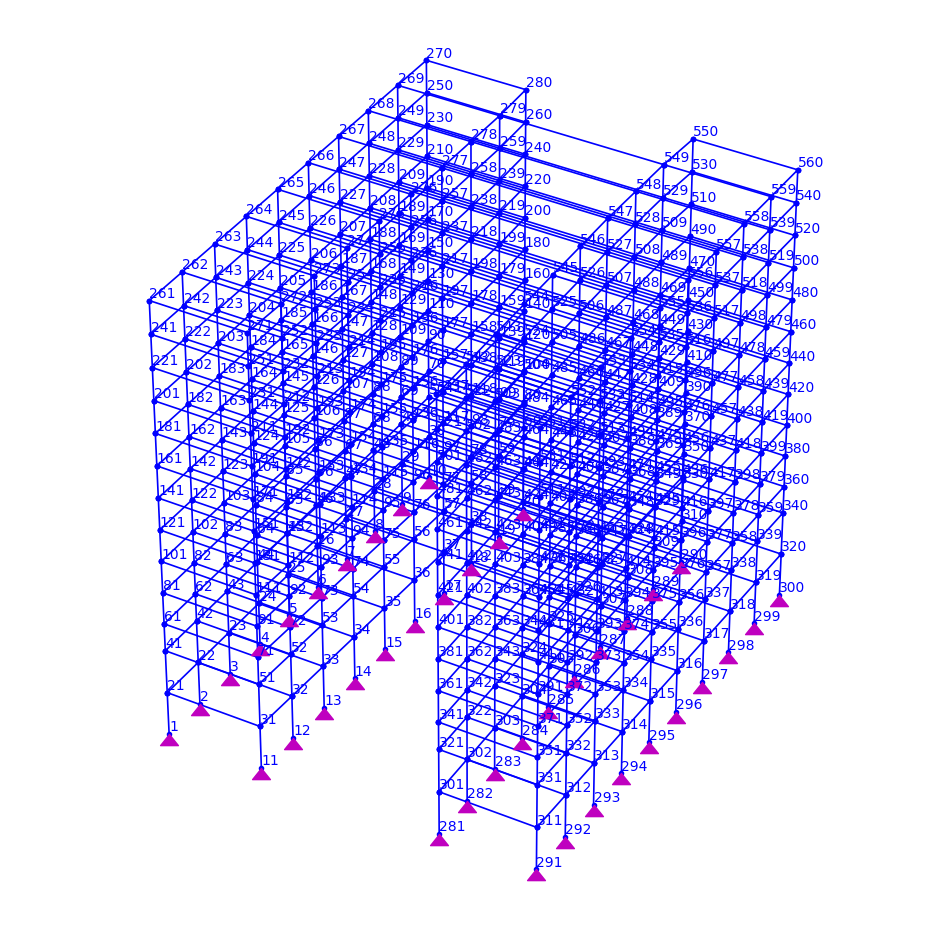

In [23]:
# Plot geometry to check that it is correct
ops.wipe()
periods, eigenvecs = model_definition(0.05, [1], 10, printFactors=False)
opsv.plot_model(node_labels=1, element_labels=0,fig_wi_he=(30.0, 70.0),axis_off=1,az_el=(-60.0, 35.0),local_axes=False)
ops.wipe()

#### 4.1.3. Modal Analysis

##### Qualitative exploration of the deformed shapes

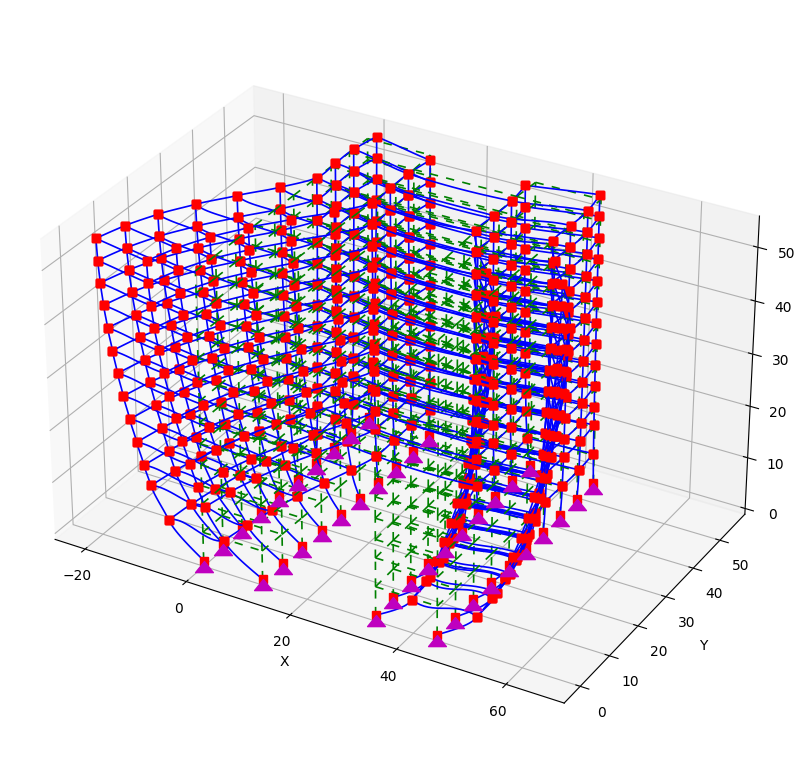

In [24]:
# Plot mode shape
ops.wipe()
periods, eigenvecs=model_definition(0.05, [1], 10)
scaleFactor=10000
opsv.plot_mode_shape(2,sfac=scaleFactor,fig_wi_he=(25.0, 75.0),fmt_undefo={'color': 'green', 'linestyle': (0, (5, 5)), 'linewidth': 1.2, 'marker': '', 'markersize': 1})
ops.wipe()

##### Modal analysis

###### Nodes to study

In [80]:
node_top=261
nodes_left_side = [1,21,41,61,81,101,121,141,161,181,201,221,241,node_top]

###### Print modes info

In [84]:
# Plot mode shape
ops.wipe()
periods, eigenvecs = model_definition(0.05, nodes_left_side, 7, printFactors=True)
modalPropertiesDict = ops.modalProperties('-print', '-return')
print(ops.nodeMass(61,1))
ops.wipe()

Mode 1, Tn = 1.4147293414178945, Mn = 1.000000000000001, Gamma = 1152.2127010763538
Mode 2, Tn = 1.2239153779015484, Mn = 1.0000000000000009, Gamma = 8.71214338171721e-09
Mode 3, Tn = 1.2195470285919245, Mn = 0.9999999999999998, Gamma = -363.7773691755105
Mode 4, Tn = 0.8834774916854444, Mn = 0.9999999999999996, Gamma = 6.646760919437614e-11
Mode 5, Tn = 0.8717963823218349, Mn = 0.9999999999999983, Gamma = -39.582461250001536
Mode 6, Tn = 0.7817468699450162, Mn = 1.0000000000000004, Gamma = 1.724871911967795e-10
Mode 7, Tn = 0.72177774914572, Mn = 1.0, Gamma = -24.14302808214344
2724.1349999999998


# MODAL ANALYSIS REPORT

* 1. DOMAIN SIZE:
# This is the size of the problem: 1 for 1D problems, 2 for 2D problems, 3 for 3D problems.
3


* 2. EIGENVALUE ANALYSIS:
#          MODE        LAMBDA         OMEGA     FREQUENCY        PERIOD
# ------------- ------------- ------------- ------------- -------------
              1       19.7248       4.44126      0.706849       1.41473
              2       26.3546       5.13368       0.81705       1.22392
              3       26.5438       5.15206      0.819977       1.21955
              4       50.5788       7.11188       1.13189      0.883477
              5       51.9433       7.20717       1.14706      0.871796
              6       64.5992       8.03737       1.27919      0.781747
              7       75.7797       8.70515       1.38547      0.721778


* 3. TOTAL MASS OF THE STRUCTURE:
# The total masses (translational and rotational) of the structure
# including the masses at fixed DOFs (if any).
#            MX            MY        

##### Calculate Modal Analysis

In [85]:
Gamma_x_i = modalPropertiesDict['partiFactorMX']
Gamma_y_i = modalPropertiesDict['partiFactorMY']
Period_mode_i = modalPropertiesDict['eigenPeriod']
EigenValuesLambda_i = modalPropertiesDict['eigenLambda']

modesToReach90ParticipationX = 3
modesToReach90ParticipationY = 6
modesToStudy = max(modesToReach90ParticipationX, modesToReach90ParticipationY)

earthquakes_modal_analysis = {}
for earthquake in earthquakes_data:
    earthquakes_modal_analysis[earthquake] = {}
    for i in range(modesToStudy):
        earthquakes_modal_analysis[earthquake][i+1] = {}
        for n in range(len(nodes_left_side)):
            earthquakes_modal_analysis[earthquake][i+1][nodes_left_side[n]] = {
                'Ux': {
                    'RotD100': 0.0,
                    'RotD50': 0.0,
                    'RotD00': 0.0,
                    'SRSS': 0.0,
                    'Max': 0.0,
                    'X': 0.0,
                    'Y': 0.0,
                    'Geomean': 0.0,
                    'Eurocode8': 0.0,
                    'Eurocode8_design': 0.0,
                    'asce': 0.0
                },
                'Uy': {
                    'RotD100': 0.0,
                    'RotD50': 0.0,
                    'RotD00': 0.0,
                    'SRSS': 0.0,
                    'Max': 0.0,
                    'X': 0.0,
                    'Y': 0.0,
                    'Geomean': 0.0,
                    'Eurocode8': 0.0,
                    'Eurocode8_design': 0.0,
                    'asce': 0.0
                },
                'Vx': {
                    'RotD100': 0.0,
                    'RotD50': 0.0,
                    'RotD00': 0.0,
                    'SRSS': 0.0,
                    'Max': 0.0,
                    'X': 0.0,
                    'Y': 0.0,
                    'Geomean': 0.0,
                    'Eurocode8': 0.0,
                    'Eurocode8_design': 0.0,
                    'asce': 0.0
                },
                'Vy': {
                    'RotD100': 0.0,
                    'RotD50': 0.0,
                    'RotD00': 0.0,
                    'SRSS': 0.0,
                    'Max': 0.0,
                    'X': 0.0,
                    'Y': 0.0,
                    'Geomean': 0.0,
                    'Eurocode8': 0.0,
                    'Eurocode8_design': 0.0,
                    'asce': 0.0
                },
                'Ax': {
                    'RotD100': 0.0,
                    'RotD50': 0.0,
                    'RotD00': 0.0,
                    'SRSS': 0.0,
                    'Max': 0.0,
                    'X': 0.0,
                    'Y': 0.0,
                    'Geomean': 0.0,
                    'Eurocode8': 0.0,
                    'Eurocode8_design': 0.0,
                    'asce': 0.0
                },
                'Ay': {
                    'RotD100': 0.0,
                    'RotD50': 0.0,
                    'RotD00': 0.0,
                    'SRSS': 0.0,
                    'Max': 0.0,
                    'X': 0.0,
                    'Y': 0.0,
                    'Geomean': 0.0,
                    'Eurocode8': 0.0,
                    'Eurocode8_design': 0.0,
                    'asce': 0.0
                } 
            }


In [86]:
for earthquake in tqdm(earthquakes_data, desc='Calculating data for earthquake {ethqk}'.format(ethqk=earthquake)):
    for i in tqdm(range(modesToStudy)): # mode  i=1,2,3,4,5 ..., modesToStudy
        rotd100 = get_ROTD('100', Period_mode_i[i], damping, earthquakes_data[earthquake]['GMD_longitudinal']['time'], earthquakes_data[earthquake]['GMD_longitudinal']['gmdata'], earthquakes_data[earthquake]['GMD_transverse']['gmdata'], earthquakes_data[earthquake]['GMD_longitudinal']['dt'])
        rotd50 = get_ROTD('50', Period_mode_i[i], damping, earthquakes_data[earthquake]['GMD_longitudinal']['time'], earthquakes_data[earthquake]['GMD_longitudinal']['gmdata'], earthquakes_data[earthquake]['GMD_transverse']['gmdata'], earthquakes_data[earthquake]['GMD_longitudinal']['dt'])
        rotd00 = get_ROTD('00', Period_mode_i[i], damping, earthquakes_data[earthquake]['GMD_longitudinal']['time'], earthquakes_data[earthquake]['GMD_longitudinal']['gmdata'], earthquakes_data[earthquake]['GMD_transverse']['gmdata'], earthquakes_data[earthquake]['GMD_longitudinal']['dt'])
        maxSpectra = get_MaxSpectra(Period_mode_i[i], damping, earthquakes_data[earthquake]['GMD_longitudinal']['time'], earthquakes_data[earthquake]['GMD_longitudinal']['gmdata'], earthquakes_data[earthquake]['GMD_transverse']['gmdata'], earthquakes_data[earthquake]['GMD_longitudinal']['dt'])
        srss = get_SRSS(Period_mode_i[i], damping, earthquakes_data[earthquake]['GMD_longitudinal']['time'], earthquakes_data[earthquake]['GMD_longitudinal']['gmdata'], earthquakes_data[earthquake]['GMD_transverse']['gmdata'], earthquakes_data[earthquake]['GMD_longitudinal']['dt'])
        componentX = get_ComponentSpectra('X', Period_mode_i[i], damping, earthquakes_data[earthquake]['GMD_longitudinal']['time'], earthquakes_data[earthquake]['GMD_longitudinal']['gmdata'], earthquakes_data[earthquake]['GMD_transverse']['gmdata'], earthquakes_data[earthquake]['GMD_longitudinal']['dt'])
        componentY = get_ComponentSpectra('Y', Period_mode_i[i], damping, earthquakes_data[earthquake]['GMD_longitudinal']['time'], earthquakes_data[earthquake]['GMD_longitudinal']['gmdata'], earthquakes_data[earthquake]['GMD_transverse']['gmdata'], earthquakes_data[earthquake]['GMD_longitudinal']['dt'])
        geomean = get_GeoMean(Period_mode_i[i], damping, earthquakes_data[earthquake]['GMD_longitudinal']['time'], earthquakes_data[earthquake]['GMD_longitudinal']['gmdata'], earthquakes_data[earthquake]['GMD_transverse']['gmdata'], earthquakes_data[earthquake]['GMD_longitudinal']['dt'])
        euro8 = get_Eurocode8(Period_mode_i[i])
        euro8_design = get_Eurocode8_design(Period_mode_i[i])
        asce = get_asce(Period_mode_i[i])
        for n in range(len(nodes_left_side)):
            for dof in range(2): # indices X=0 and Y=1                
                if dof == 0:
                    earthquakes_modal_analysis[earthquake][i+1][nodes_left_side[n]]['Ux']['RotD100'] = eigenvecs[nodes_left_side[n]][i+1][dof]*Gamma_x_i[i]*rotd100['displacement'] / EigenValuesLambda_i[i]#*1e6
                    earthquakes_modal_analysis[earthquake][i+1][nodes_left_side[n]]['Ux']['RotD50'] = eigenvecs[nodes_left_side[n]][i+1][dof]*Gamma_x_i[i]*rotd50['displacement'] / EigenValuesLambda_i[i]#*1e6
                    earthquakes_modal_analysis[earthquake][i+1][nodes_left_side[n]]['Ux']['RotD00'] = eigenvecs[nodes_left_side[n]][i+1][dof]*Gamma_x_i[i]*rotd00['displacement'] / EigenValuesLambda_i[i]#*1e6
                    earthquakes_modal_analysis[earthquake][i+1][nodes_left_side[n]]['Ux']['SRSS'] = eigenvecs[nodes_left_side[n]][i+1][dof]*Gamma_x_i[i]*srss['displacement'] / EigenValuesLambda_i[i]#*1e6
                    earthquakes_modal_analysis[earthquake][i+1][nodes_left_side[n]]['Ux']['Max'] = eigenvecs[nodes_left_side[n]][i+1][dof]*Gamma_x_i[i]*maxSpectra['displacement'] / EigenValuesLambda_i[i]#*1e6
                    earthquakes_modal_analysis[earthquake][i+1][nodes_left_side[n]]['Ux']['X'] = eigenvecs[nodes_left_side[n]][i+1][dof]*Gamma_x_i[i]*componentX['displacement'] / EigenValuesLambda_i[i]#*1e6
                    earthquakes_modal_analysis[earthquake][i+1][nodes_left_side[n]]['Ux']['Y'] = eigenvecs[nodes_left_side[n]][i+1][dof]*Gamma_x_i[i]*componentY['displacement'] / EigenValuesLambda_i[i]#*1e6
                    earthquakes_modal_analysis[earthquake][i+1][nodes_left_side[n]]['Ux']['Geomean'] = eigenvecs[nodes_left_side[n]][i+1][dof]*Gamma_x_i[i]*geomean['displacement'] / EigenValuesLambda_i[i]#*1e6
                    earthquakes_modal_analysis[earthquake][i+1][nodes_left_side[n]]['Ux']['Eurocode8'] = eigenvecs[nodes_left_side[n]][i+1][dof]*Gamma_x_i[i]*euro8['displacement'] / EigenValuesLambda_i[i]#*1e6
                    earthquakes_modal_analysis[earthquake][i+1][nodes_left_side[n]]['Ux']['Eurocode8_design'] = eigenvecs[nodes_left_side[n]][i+1][dof]*Gamma_x_i[i]*euro8_design['displacement'] / EigenValuesLambda_i[i]#*1e6
                    earthquakes_modal_analysis[earthquake][i+1][nodes_left_side[n]]['Ux']['asce'] = eigenvecs[nodes_left_side[n]][i+1][dof]*Gamma_x_i[i]*asce['displacement'] / EigenValuesLambda_i[i]#*1e6

                    earthquakes_modal_analysis[earthquake][i+1][nodes_left_side[n]]['Vx']['RotD100'] = eigenvecs[nodes_left_side[n]][i+1][dof]*Gamma_x_i[i]*rotd100['velocity'] / EigenValuesLambda_i[i]#*1e3
                    earthquakes_modal_analysis[earthquake][i+1][nodes_left_side[n]]['Vx']['RotD50'] = eigenvecs[nodes_left_side[n]][i+1][dof]*Gamma_x_i[i]*rotd50['velocity'] / EigenValuesLambda_i[i]#*1e3
                    earthquakes_modal_analysis[earthquake][i+1][nodes_left_side[n]]['Vx']['RotD00'] = eigenvecs[nodes_left_side[n]][i+1][dof]*Gamma_x_i[i]*rotd00['velocity'] / EigenValuesLambda_i[i]#*1e3
                    earthquakes_modal_analysis[earthquake][i+1][nodes_left_side[n]]['Vx']['SRSS'] = eigenvecs[nodes_left_side[n]][i+1][dof]*Gamma_x_i[i]*srss['velocity'] / EigenValuesLambda_i[i]#*1e3
                    earthquakes_modal_analysis[earthquake][i+1][nodes_left_side[n]]['Vx']['Max'] = eigenvecs[nodes_left_side[n]][i+1][dof]*Gamma_x_i[i]*maxSpectra['velocity'] / EigenValuesLambda_i[i]#*1e3
                    earthquakes_modal_analysis[earthquake][i+1][nodes_left_side[n]]['Vx']['X'] = eigenvecs[nodes_left_side[n]][i+1][dof]*Gamma_x_i[i]*componentX['velocity'] / EigenValuesLambda_i[i]#*1e3
                    earthquakes_modal_analysis[earthquake][i+1][nodes_left_side[n]]['Vx']['Y'] = eigenvecs[nodes_left_side[n]][i+1][dof]*Gamma_x_i[i]*componentY['velocity'] / EigenValuesLambda_i[i]#*1e3
                    earthquakes_modal_analysis[earthquake][i+1][nodes_left_side[n]]['Vx']['Geomean'] = eigenvecs[nodes_left_side[n]][i+1][dof]*Gamma_x_i[i]*geomean['velocity'] / EigenValuesLambda_i[i]#*1e3
                    earthquakes_modal_analysis[earthquake][i+1][nodes_left_side[n]]['Vx']['Eurocode8'] = eigenvecs[nodes_left_side[n]][i+1][dof]*Gamma_x_i[i]*euro8['velocity'] / EigenValuesLambda_i[i]#*1e3
                    earthquakes_modal_analysis[earthquake][i+1][nodes_left_side[n]]['Vx']['Eurocode8_design'] = eigenvecs[nodes_left_side[n]][i+1][dof]*Gamma_x_i[i]*euro8_design['velocity'] / EigenValuesLambda_i[i]#*1e3
                    earthquakes_modal_analysis[earthquake][i+1][nodes_left_side[n]]['Vx']['asce'] = eigenvecs[nodes_left_side[n]][i+1][dof]*Gamma_x_i[i]*asce['velocity'] / EigenValuesLambda_i[i]#*1e3

                    earthquakes_modal_analysis[earthquake][i+1][nodes_left_side[n]]['Ax']['RotD100'] = eigenvecs[nodes_left_side[n]][i+1][dof]*Gamma_x_i[i]*rotd100['acceleration'] / EigenValuesLambda_i[i]#*1e3
                    earthquakes_modal_analysis[earthquake][i+1][nodes_left_side[n]]['Ax']['RotD50'] = eigenvecs[nodes_left_side[n]][i+1][dof]*Gamma_x_i[i]*rotd50['acceleration'] / EigenValuesLambda_i[i]#*1e3
                    earthquakes_modal_analysis[earthquake][i+1][nodes_left_side[n]]['Ax']['RotD00'] = eigenvecs[nodes_left_side[n]][i+1][dof]*Gamma_x_i[i]*rotd00['acceleration'] / EigenValuesLambda_i[i]#*1e3
                    earthquakes_modal_analysis[earthquake][i+1][nodes_left_side[n]]['Ax']['SRSS'] = eigenvecs[nodes_left_side[n]][i+1][dof]*Gamma_x_i[i]*srss['acceleration'] / EigenValuesLambda_i[i]#*1e3
                    earthquakes_modal_analysis[earthquake][i+1][nodes_left_side[n]]['Ax']['Max'] = eigenvecs[nodes_left_side[n]][i+1][dof]*Gamma_x_i[i]*maxSpectra['acceleration'] / EigenValuesLambda_i[i]#*1e3
                    earthquakes_modal_analysis[earthquake][i+1][nodes_left_side[n]]['Ax']['X'] = eigenvecs[nodes_left_side[n]][i+1][dof]*Gamma_x_i[i]*componentX['acceleration'] / EigenValuesLambda_i[i]#*1e3
                    earthquakes_modal_analysis[earthquake][i+1][nodes_left_side[n]]['Ax']['Y'] = eigenvecs[nodes_left_side[n]][i+1][dof]*Gamma_x_i[i]*componentY['acceleration'] / EigenValuesLambda_i[i]#*1e3
                    earthquakes_modal_analysis[earthquake][i+1][nodes_left_side[n]]['Ax']['Geomean'] = eigenvecs[nodes_left_side[n]][i+1][dof]*Gamma_x_i[i]*geomean['acceleration'] / EigenValuesLambda_i[i]#*1e3
                    earthquakes_modal_analysis[earthquake][i+1][nodes_left_side[n]]['Ax']['Eurocode8'] = eigenvecs[nodes_left_side[n]][i+1][dof]*Gamma_x_i[i]*euro8['acceleration'] / EigenValuesLambda_i[i]#*1e3
                    earthquakes_modal_analysis[earthquake][i+1][nodes_left_side[n]]['Ax']['Eurocode8_design'] = eigenvecs[nodes_left_side[n]][i+1][dof]*Gamma_x_i[i]*euro8_design['acceleration'] / EigenValuesLambda_i[i]#*1e3
                    earthquakes_modal_analysis[earthquake][i+1][nodes_left_side[n]]['Ax']['asce'] = eigenvecs[nodes_left_side[n]][i+1][dof]*Gamma_x_i[i]*asce['acceleration'] / EigenValuesLambda_i[i]#*1e3
                
                elif dof == 1:
                    earthquakes_modal_analysis[earthquake][i+1][nodes_left_side[n]]['Uy']['RotD100'] = eigenvecs[nodes_left_side[n]][i+1][dof]*Gamma_y_i[i]*rotd100['displacement'] / EigenValuesLambda_i[i]#*1e6
                    earthquakes_modal_analysis[earthquake][i+1][nodes_left_side[n]]['Uy']['RotD50'] = eigenvecs[nodes_left_side[n]][i+1][dof]*Gamma_y_i[i]*rotd50['displacement'] / EigenValuesLambda_i[i]#*1e6
                    earthquakes_modal_analysis[earthquake][i+1][nodes_left_side[n]]['Uy']['RotD00'] = eigenvecs[nodes_left_side[n]][i+1][dof]*Gamma_y_i[i]*rotd00['displacement'] / EigenValuesLambda_i[i]#*1e6
                    earthquakes_modal_analysis[earthquake][i+1][nodes_left_side[n]]['Uy']['SRSS'] = eigenvecs[nodes_left_side[n]][i+1][dof]*Gamma_y_i[i]*srss['displacement'] / EigenValuesLambda_i[i]#*1e6
                    earthquakes_modal_analysis[earthquake][i+1][nodes_left_side[n]]['Uy']['Max'] = eigenvecs[nodes_left_side[n]][i+1][dof]*Gamma_y_i[i]*maxSpectra['displacement'] / EigenValuesLambda_i[i]#*1e6
                    earthquakes_modal_analysis[earthquake][i+1][nodes_left_side[n]]['Uy']['X'] = eigenvecs[nodes_left_side[n]][i+1][dof]*Gamma_y_i[i]*componentX['displacement'] / EigenValuesLambda_i[i]#*1e6
                    earthquakes_modal_analysis[earthquake][i+1][nodes_left_side[n]]['Uy']['Y'] = eigenvecs[nodes_left_side[n]][i+1][dof]*Gamma_y_i[i]*componentY['displacement'] / EigenValuesLambda_i[i]#*1e6
                    earthquakes_modal_analysis[earthquake][i+1][nodes_left_side[n]]['Uy']['Geomean'] = eigenvecs[nodes_left_side[n]][i+1][dof]*Gamma_y_i[i]*geomean['displacement'] / EigenValuesLambda_i[i]#*1e6
                    earthquakes_modal_analysis[earthquake][i+1][nodes_left_side[n]]['Uy']['Eurocode8'] = eigenvecs[nodes_left_side[n]][i+1][dof]*Gamma_y_i[i]*euro8['displacement'] / EigenValuesLambda_i[i]#*1e6
                    earthquakes_modal_analysis[earthquake][i+1][nodes_left_side[n]]['Uy']['Eurocode8_design'] = eigenvecs[nodes_left_side[n]][i+1][dof]*Gamma_y_i[i]*euro8_design['displacement'] / EigenValuesLambda_i[i]#*1e6
                    earthquakes_modal_analysis[earthquake][i+1][nodes_left_side[n]]['Uy']['asce'] = eigenvecs[nodes_left_side[n]][i+1][dof]*Gamma_y_i[i]*asce['displacement'] / EigenValuesLambda_i[i]#*1e6

                    earthquakes_modal_analysis[earthquake][i+1][nodes_left_side[n]]['Vy']['RotD100'] = eigenvecs[nodes_left_side[n]][i+1][dof]*Gamma_y_i[i]*rotd100['velocity'] / EigenValuesLambda_i[i]
                    earthquakes_modal_analysis[earthquake][i+1][nodes_left_side[n]]['Vy']['RotD50'] = eigenvecs[nodes_left_side[n]][i+1][dof]*Gamma_y_i[i]*rotd50['velocity'] / EigenValuesLambda_i[i]
                    earthquakes_modal_analysis[earthquake][i+1][nodes_left_side[n]]['Vy']['RotD00'] = eigenvecs[nodes_left_side[n]][i+1][dof]*Gamma_y_i[i]*rotd00['velocity'] / EigenValuesLambda_i[i]
                    earthquakes_modal_analysis[earthquake][i+1][nodes_left_side[n]]['Vy']['SRSS'] = eigenvecs[nodes_left_side[n]][i+1][dof]*Gamma_y_i[i]*srss['velocity'] / EigenValuesLambda_i[i]
                    earthquakes_modal_analysis[earthquake][i+1][nodes_left_side[n]]['Vy']['Max'] = eigenvecs[nodes_left_side[n]][i+1][dof]*Gamma_y_i[i]*maxSpectra['velocity'] / EigenValuesLambda_i[i]
                    earthquakes_modal_analysis[earthquake][i+1][nodes_left_side[n]]['Vy']['X'] = eigenvecs[nodes_left_side[n]][i+1][dof]*Gamma_y_i[i]*componentX['velocity'] / EigenValuesLambda_i[i]
                    earthquakes_modal_analysis[earthquake][i+1][nodes_left_side[n]]['Vy']['Y'] = eigenvecs[nodes_left_side[n]][i+1][dof]*Gamma_y_i[i]*componentY['velocity'] / EigenValuesLambda_i[i]
                    earthquakes_modal_analysis[earthquake][i+1][nodes_left_side[n]]['Vy']['Geomean'] = eigenvecs[nodes_left_side[n]][i+1][dof]*Gamma_y_i[i]*geomean['velocity'] / EigenValuesLambda_i[i]
                    earthquakes_modal_analysis[earthquake][i+1][nodes_left_side[n]]['Vy']['Eurocode8'] = eigenvecs[nodes_left_side[n]][i+1][dof]*Gamma_y_i[i]*euro8['velocity'] / EigenValuesLambda_i[i]
                    earthquakes_modal_analysis[earthquake][i+1][nodes_left_side[n]]['Vy']['Eurocode8_design'] = eigenvecs[nodes_left_side[n]][i+1][dof]*Gamma_y_i[i]*euro8_design['velocity'] / EigenValuesLambda_i[i]
                    earthquakes_modal_analysis[earthquake][i+1][nodes_left_side[n]]['Vy']['asce'] = eigenvecs[nodes_left_side[n]][i+1][dof]*Gamma_y_i[i]*asce['velocity'] / EigenValuesLambda_i[i]

                    earthquakes_modal_analysis[earthquake][i+1][nodes_left_side[n]]['Ay']['RotD100'] = eigenvecs[nodes_left_side[n]][i+1][dof]*Gamma_y_i[i]*rotd100['acceleration'] / EigenValuesLambda_i[i]
                    earthquakes_modal_analysis[earthquake][i+1][nodes_left_side[n]]['Ay']['RotD50'] = eigenvecs[nodes_left_side[n]][i+1][dof]*Gamma_y_i[i]*rotd50['acceleration'] / EigenValuesLambda_i[i]
                    earthquakes_modal_analysis[earthquake][i+1][nodes_left_side[n]]['Ay']['RotD00'] = eigenvecs[nodes_left_side[n]][i+1][dof]*Gamma_y_i[i]*rotd00['acceleration'] / EigenValuesLambda_i[i]
                    earthquakes_modal_analysis[earthquake][i+1][nodes_left_side[n]]['Ay']['SRSS'] = eigenvecs[nodes_left_side[n]][i+1][dof]*Gamma_y_i[i]*srss['acceleration'] / EigenValuesLambda_i[i]
                    earthquakes_modal_analysis[earthquake][i+1][nodes_left_side[n]]['Ay']['Max'] = eigenvecs[nodes_left_side[n]][i+1][dof]*Gamma_y_i[i]*maxSpectra['acceleration'] / EigenValuesLambda_i[i]
                    earthquakes_modal_analysis[earthquake][i+1][nodes_left_side[n]]['Ay']['X'] = eigenvecs[nodes_left_side[n]][i+1][dof]*Gamma_y_i[i]*componentX['acceleration'] / EigenValuesLambda_i[i]
                    earthquakes_modal_analysis[earthquake][i+1][nodes_left_side[n]]['Ay']['Y'] = eigenvecs[nodes_left_side[n]][i+1][dof]*Gamma_y_i[i]*componentY['acceleration'] / EigenValuesLambda_i[i]
                    earthquakes_modal_analysis[earthquake][i+1][nodes_left_side[n]]['Ay']['Geomean'] = eigenvecs[nodes_left_side[n]][i+1][dof]*Gamma_y_i[i]*geomean['acceleration'] / EigenValuesLambda_i[i]
                    earthquakes_modal_analysis[earthquake][i+1][nodes_left_side[n]]['Ay']['Eurocode8'] = eigenvecs[nodes_left_side[n]][i+1][dof]*Gamma_y_i[i]*euro8['acceleration'] / EigenValuesLambda_i[i]
                    earthquakes_modal_analysis[earthquake][i+1][nodes_left_side[n]]['Ay']['Eurocode8_design'] = eigenvecs[nodes_left_side[n]][i+1][dof]*Gamma_y_i[i]*euro8_design['acceleration'] / EigenValuesLambda_i[i]
                    earthquakes_modal_analysis[earthquake][i+1][nodes_left_side[n]]['Ay']['asce'] = eigenvecs[nodes_left_side[n]][i+1][dof]*Gamma_y_i[i]*asce['acceleration'] / EigenValuesLambda_i[i]
                    

Calculating data for earthquake Greece:   0
100%|████████| 6/6 [01:22<00:00, 13.71s/it]
Calculating data for earthquake Greece:  10
100%|███████| 6/6 [15:34<00:00, 155.69s/it]
Calculating data for earthquake Greece:  20
100%|████████| 6/6 [03:29<00:00, 34.95s/it]
Calculating data for earthquake Greece:  30
100%|████████| 6/6 [06:29<00:00, 64.86s/it]
Calculating data for earthquake Greece:  40
100%|████████| 6/6 [02:22<00:00, 23.69s/it]
Calculating data for earthquake Greece:  50
100%|████████| 6/6 [02:48<00:00, 28.01s/it]
Calculating data for earthquake Greece:  60
100%|████████| 6/6 [07:19<00:00, 73.26s/it]
Calculating data for earthquake Greece:  70
100%|████████| 6/6 [04:02<00:00, 40.35s/it]
Calculating data for earthquake Greece:  80
100%|███████| 6/6 [13:53<00:00, 138.91s/it]
Calculating data for earthquake Greece:  90
100%|████████| 6/6 [09:53<00:00, 98.93s/it]
Calculating data for earthquake Greece: 100


In [29]:
earthquakes_modal_analysis['Tabas'][1][node_top]['Ux']['Eurocode8_design'] *1e6

11.816821192873517

In [30]:
earthquakes_modal_analysis['Italy_2'][1][node_top]['Ux']['Eurocode8_design'] *1e6

11.816821192873517

In [31]:
earthquakes_modal_analysis['LA_Hollywood'][1][node_top]['Ux']['Eurocode8_design'] *1e6

11.816821192873517

In [32]:
earthquakes_modal_analysis['Nicaragua'][1][node_top]['Ux']['Eurocode8_design'] *1e6

11.816821192873517

In [33]:
earthquakes_modal_analysis['Georgia'][1][node_top]['Ux']['Eurocode8_design'] *1e6

11.816821192873517

##### SRSS COMBINATION METHOD

###### CALCULATE DATA

In [34]:
# Init SRSS combination structure
earthquakes_SRSS_combination = {}
for earthquake in earthquakes_data:
    earthquakes_SRSS_combination[earthquake] = {}
    for n in range(len(nodes_left_side)):
        earthquakes_SRSS_combination[earthquake][nodes_left_side[n]] = {
            'Ux': {
                'RotD100': 0.0,
                'RotD50': 0.0,
                'RotD00': 0.0,
                'SRSS': 0.0,
                'Max': 0.0,
                'X': 0.0,
                'Y': 0.0,
                'Geomean': 0.0,
                'Eurocode8': 0.0,
                'Eurocode8_design': 0.0,
                'asce': 0.0
            },
            'Uy': {
                'RotD100': 0.0,
                'RotD50': 0.0,
                'RotD00': 0.0,
                'SRSS': 0.0,
                'Max': 0.0,
                'X': 0.0,
                'Y': 0.0,
                'Geomean': 0.0,
                'Eurocode8': 0.0,
                'Eurocode8_design': 0.0,
                'asce': 0.0
            },
            'Vx': {
                'RotD100': 0.0,
                'RotD50': 0.0,
                'RotD00': 0.0,
                'SRSS': 0.0,
                'Max': 0.0,
                'X': 0.0,
                'Y': 0.0,
                'Geomean': 0.0,
                'Eurocode8': 0.0,
                'Eurocode8_design': 0.0,
                'asce': 0.0
            },
            'Vy': {
                'RotD100': 0.0,
                'RotD50': 0.0,
                'RotD00': 0.0,
                'SRSS': 0.0,
                'Max': 0.0,
                'X': 0.0,
                'Y': 0.0,
                'Geomean': 0.0,
                'Eurocode8': 0.0,
                'Eurocode8_design': 0.0,
                'asce': 0.0
            },
            'Ax': {
                'RotD100': 0.0,
                'RotD50': 0.0,
                'RotD00': 0.0,
                'SRSS': 0.0,
                'Max': 0.0,
                'X': 0.0,
                'Y': 0.0,
                'Geomean': 0.0,
                'Eurocode8': 0.0,
                'Eurocode8_design': 0.0,
                'asce': 0.0
            },
            'Ay': {
                'RotD100': 0.0,
                'RotD50': 0.0,
                'RotD00': 0.0,
                'SRSS': 0.0,
                'Max': 0.0,
                'X': 0.0,
                'Y': 0.0,
                'Geomean': 0.0,
                'Eurocode8': 0.0,
                'Eurocode8_design': 0.0,
                'asce': 0.0
            } 
        }

# Fill initialized structure wth the SRSS combination method
for earthquake in earthquakes_data:
    for n in range(len(nodes_left_side)):
        for key in earthquakes_SRSS_combination[earthquake][nodes_left_side[n]]:
            for i in range(modesToStudy):
                earthquakes_SRSS_combination[earthquake][nodes_left_side[n]][key]['RotD100'] += math.pow(earthquakes_modal_analysis[earthquake][i+1][nodes_left_side[n]][key]['RotD100'], 2)
                earthquakes_SRSS_combination[earthquake][nodes_left_side[n]][key]['RotD50'] += math.pow(earthquakes_modal_analysis[earthquake][i+1][nodes_left_side[n]][key]['RotD50'], 2)
                earthquakes_SRSS_combination[earthquake][nodes_left_side[n]][key]['RotD00'] += math.pow(earthquakes_modal_analysis[earthquake][i+1][nodes_left_side[n]][key]['RotD00'], 2)
                earthquakes_SRSS_combination[earthquake][nodes_left_side[n]][key]['SRSS'] += math.pow(earthquakes_modal_analysis[earthquake][i+1][nodes_left_side[n]][key]['SRSS'], 2)
                earthquakes_SRSS_combination[earthquake][nodes_left_side[n]][key]['Max'] += math.pow(earthquakes_modal_analysis[earthquake][i+1][nodes_left_side[n]][key]['Max'], 2)
                earthquakes_SRSS_combination[earthquake][nodes_left_side[n]][key]['X'] += math.pow(earthquakes_modal_analysis[earthquake][i+1][nodes_left_side[n]][key]['X'], 2)
                earthquakes_SRSS_combination[earthquake][nodes_left_side[n]][key]['Y'] += math.pow(earthquakes_modal_analysis[earthquake][i+1][nodes_left_side[n]][key]['Y'], 2)
                earthquakes_SRSS_combination[earthquake][nodes_left_side[n]][key]['Geomean'] += math.pow(earthquakes_modal_analysis[earthquake][i+1][nodes_left_side[n]][key]['Geomean'], 2)
                earthquakes_SRSS_combination[earthquake][nodes_left_side[n]][key]['Eurocode8'] += math.pow(earthquakes_modal_analysis[earthquake][i+1][nodes_left_side[n]][key]['Eurocode8'], 2)
                earthquakes_SRSS_combination[earthquake][nodes_left_side[n]][key]['Eurocode8_design'] += math.pow(earthquakes_modal_analysis[earthquake][i+1][nodes_left_side[n]][key]['Eurocode8_design'], 2)
                earthquakes_SRSS_combination[earthquake][nodes_left_side[n]][key]['asce'] += math.pow(earthquakes_modal_analysis[earthquake][i+1][nodes_left_side[n]][key]['asce'], 2)
                
            earthquakes_SRSS_combination[earthquake][nodes_left_side[n]][key]['RotD100'] = math.sqrt(earthquakes_SRSS_combination[earthquake][nodes_left_side[n]][key]['RotD100'])*1e6
            earthquakes_SRSS_combination[earthquake][nodes_left_side[n]][key]['RotD50'] = math.sqrt(earthquakes_SRSS_combination[earthquake][nodes_left_side[n]][key]['RotD50'])*1e6
            earthquakes_SRSS_combination[earthquake][nodes_left_side[n]][key]['RotD00'] = math.sqrt(earthquakes_SRSS_combination[earthquake][nodes_left_side[n]][key]['RotD00'])*1e6
            earthquakes_SRSS_combination[earthquake][nodes_left_side[n]][key]['SRSS'] = math.sqrt(earthquakes_SRSS_combination[earthquake][nodes_left_side[n]][key]['SRSS'])*1e6
            earthquakes_SRSS_combination[earthquake][nodes_left_side[n]][key]['Max'] = math.sqrt(earthquakes_SRSS_combination[earthquake][nodes_left_side[n]][key]['Max'])*1e6
            earthquakes_SRSS_combination[earthquake][nodes_left_side[n]][key]['X'] = math.sqrt(earthquakes_SRSS_combination[earthquake][nodes_left_side[n]][key]['X'])*1e6
            earthquakes_SRSS_combination[earthquake][nodes_left_side[n]][key]['Y'] = math.sqrt(earthquakes_SRSS_combination[earthquake][nodes_left_side[n]][key]['Y'])*1e6
            earthquakes_SRSS_combination[earthquake][nodes_left_side[n]][key]['Geomean'] = math.sqrt(earthquakes_SRSS_combination[earthquake][nodes_left_side[n]][key]['Geomean'])*1e6
            earthquakes_SRSS_combination[earthquake][nodes_left_side[n]][key]['Eurocode8'] = math.sqrt(earthquakes_SRSS_combination[earthquake][nodes_left_side[n]][key]['Eurocode8'])*1e6
            earthquakes_SRSS_combination[earthquake][nodes_left_side[n]][key]['Eurocode8_design'] = math.sqrt(earthquakes_SRSS_combination[earthquake][nodes_left_side[n]][key]['Eurocode8_design'])*1e6
            earthquakes_SRSS_combination[earthquake][nodes_left_side[n]][key]['asce'] = math.sqrt(earthquakes_SRSS_combination[earthquake][nodes_left_side[n]][key]['asce'])*1e6
        

In [35]:
earthquakes_SRSS_combination[earthquake][nodes_left_side[len(nodes_left_side)-1]]['Ux']['Eurocode8_design']

11.816821192873517

###### PLOT DATA

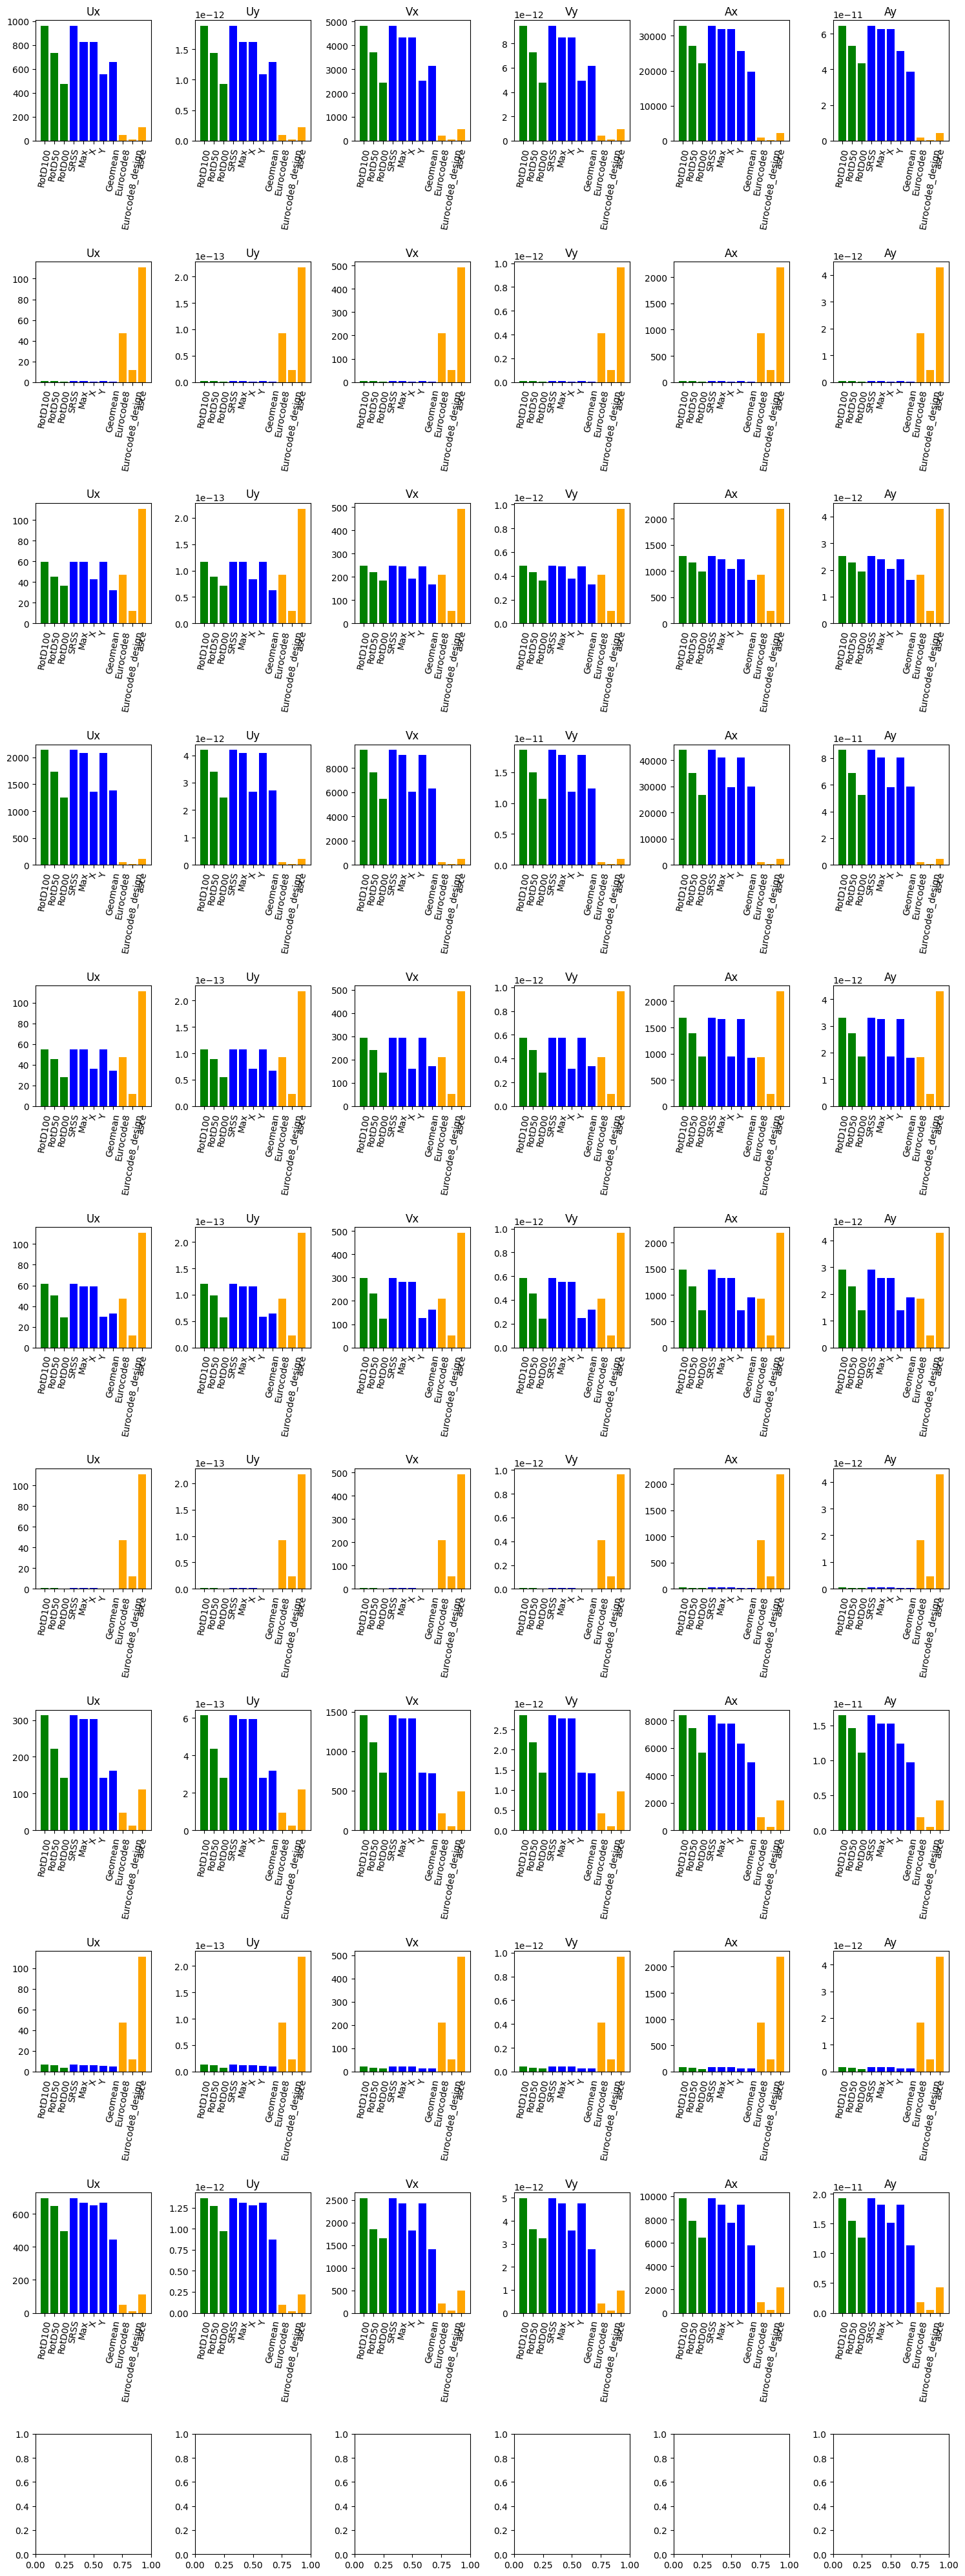

In [36]:
# Barplot of the ROOF displacements for each of the IMs

fig, (axs) = plt.subplots(len(earthquakes_modal_analysis)+1, 6, figsize=(15,40))
row = 0
for earthquake in earthquakes_modal_analysis:
    col = 0
    for magnitude in earthquakes_SRSS_combination[earthquake][nodes_left_side[len(nodes_left_side)-1]]:
        ## ---------    Calculate xBar names and y coordinates ------------------------
        xPos = []
        xPosInit = 0
        xBars = []
        y_values = []
        colors = []
        for im in earthquakes_SRSS_combination[earthquake][nodes_left_side[len(nodes_left_side)-1]][magnitude]:
            xBars.append(im)
            xPos.append(xPosInit)
            y_values.append(earthquakes_SRSS_combination[earthquake][nodes_left_side[len(nodes_left_side)-1]][magnitude][im])
            if im == 'RotD100' or im == 'RotD50' or im == 'RotD00': #orientation-independent
                colors.append('green')
            elif im == 'SRSS' or im == 'Max' or im == 'X' or im == 'Y' or im == 'Geomean': #orientation-dependent
                colors.append('blue')
            else: #eurocode
                colors.append('orange')
            xPosInit += 1
        ## ---------    Draw plot -----------------------------------------------------
        axs[row, col].bar(xPos, y_values, color = colors)
        plt.sca(axs[row, col])
        plt.xticks(xPos, xBars, rotation=80)
        axs[row, col].title.set_text(magnitude)
        
        col += 1

    row += 1

fig.tight_layout(h_pad=2.0, w_pad=1.0)
plt.savefig("SRSS.svg")    
plt.show()

##### CQC COMBINATION METHOD

###### CALCULATE DATA

In [37]:
# Init CQC combination structure
earthquakes_CQC_combination = {}
for earthquake in earthquakes_data:
    earthquakes_CQC_combination[earthquake] = {}
    for n in range(len(nodes_left_side)):
        earthquakes_CQC_combination[earthquake][nodes_left_side[n]] = {
            'Ux': {
                'RotD100': 0.0,
                'RotD50': 0.0,
                'RotD00': 0.0,
                'SRSS': 0.0,
                'Max': 0.0,
                'X': 0.0,
                'Y': 0.0,
                'Geomean': 0.0,
                'Eurocode8': 0.0,
                'Eurocode8_design': 0.0,
                'asce': 0.0
            },
            'Uy': {
                'RotD100': 0.0,
                'RotD50': 0.0,
                'RotD00': 0.0,
                'SRSS': 0.0,
                'Max': 0.0,
                'X': 0.0,
                'Y': 0.0,
                'Geomean': 0.0,
                'Eurocode8': 0.0,
                'Eurocode8_design': 0.0,
                'asce': 0.0
            },
            'Vx': {
                'RotD100': 0.0,
                'RotD50': 0.0,
                'RotD00': 0.0,
                'SRSS': 0.0,
                'Max': 0.0,
                'X': 0.0,
                'Y': 0.0,
                'Geomean': 0.0,
                'Eurocode8': 0.0,
                'Eurocode8_design': 0.0,
                'asce': 0.0
            },
            'Vy': {
                'RotD100': 0.0,
                'RotD50': 0.0,
                'RotD00': 0.0,
                'SRSS': 0.0,
                'Max': 0.0,
                'X': 0.0,
                'Y': 0.0,
                'Geomean': 0.0,
                'Eurocode8': 0.0,
                'Eurocode8_design': 0.0,
                'asce': 0.0
            },
            'Ax': {
                'RotD100': 0.0,
                'RotD50': 0.0,
                'RotD00': 0.0,
                'SRSS': 0.0,
                'Max': 0.0,
                'X': 0.0,
                'Y': 0.0,
                'Geomean': 0.0,
                'Eurocode8': 0.0,
                'Eurocode8_design': 0.0,
                'asce': 0.0
            },
            'Ay': {
                'RotD100': 0.0,
                'RotD50': 0.0,
                'RotD00': 0.0,
                'SRSS': 0.0,
                'Max': 0.0,
                'X': 0.0,
                'Y': 0.0,
                'Geomean': 0.0,
                'Eurocode8': 0.0,
                'Eurocode8_design': 0.0,
                'asce': 0.0
            } 
        }

# Fill initialized structure wth the SRSS combination method
for earthquake in earthquakes_data:
    for n in range(len(nodes_left_side)):
        for key in earthquakes_CQC_combination[earthquake][nodes_left_side[n]]:
            for i in range(modesToStudy):
                for m in range(modesToStudy):
                    betaim = (2*math.pi/Period_mode_i[i]) / (2*math.pi/Period_mode_i[m])#wi/wm
                    pim = (math.pow(damping, 2)*math.pow(1+betaim, 2))/(math.pow(1-betaim, 2) + 4*math.pow(damping, 2)*betaim)
                    earthquakes_CQC_combination[earthquake][nodes_left_side[n]][key]['RotD100'] += pim * earthquakes_modal_analysis[earthquake][i+1][nodes_left_side[n]][key]['RotD100'] * earthquakes_modal_analysis[earthquake][m+1][nodes_left_side[n]][key]['RotD100']
                    earthquakes_CQC_combination[earthquake][nodes_left_side[n]][key]['RotD50'] += pim * earthquakes_modal_analysis[earthquake][i+1][nodes_left_side[n]][key]['RotD50'] * earthquakes_modal_analysis[earthquake][m+1][nodes_left_side[n]][key]['RotD50']
                    earthquakes_CQC_combination[earthquake][nodes_left_side[n]][key]['RotD00'] += pim * earthquakes_modal_analysis[earthquake][i+1][nodes_left_side[n]][key]['RotD00'] * earthquakes_modal_analysis[earthquake][m+1][nodes_left_side[n]][key]['RotD00']
                    earthquakes_CQC_combination[earthquake][nodes_left_side[n]][key]['SRSS'] += pim * earthquakes_modal_analysis[earthquake][i+1][nodes_left_side[n]][key]['SRSS'] * earthquakes_modal_analysis[earthquake][m+1][nodes_left_side[n]][key]['SRSS']
                    earthquakes_CQC_combination[earthquake][nodes_left_side[n]][key]['Max'] += pim * earthquakes_modal_analysis[earthquake][i+1][nodes_left_side[n]][key]['Max'] * earthquakes_modal_analysis[earthquake][m+1][nodes_left_side[n]][key]['Max']
                    earthquakes_CQC_combination[earthquake][nodes_left_side[n]][key]['X'] += pim * earthquakes_modal_analysis[earthquake][i+1][nodes_left_side[n]][key]['X'] * earthquakes_modal_analysis[earthquake][m+1][nodes_left_side[n]][key]['X']
                    earthquakes_CQC_combination[earthquake][nodes_left_side[n]][key]['Y'] += pim * earthquakes_modal_analysis[earthquake][i+1][nodes_left_side[n]][key]['Y'] * earthquakes_modal_analysis[earthquake][m+1][nodes_left_side[n]][key]['Y']
                    earthquakes_CQC_combination[earthquake][nodes_left_side[n]][key]['Geomean'] += pim * earthquakes_modal_analysis[earthquake][i+1][nodes_left_side[n]][key]['Geomean'] * earthquakes_modal_analysis[earthquake][m+1][nodes_left_side[n]][key]['Geomean']
                    earthquakes_CQC_combination[earthquake][nodes_left_side[n]][key]['Eurocode8'] += pim * earthquakes_modal_analysis[earthquake][i+1][nodes_left_side[n]][key]['Eurocode8'] * earthquakes_modal_analysis[earthquake][m+1][nodes_left_side[n]][key]['Eurocode8']
                    earthquakes_CQC_combination[earthquake][nodes_left_side[n]][key]['Eurocode8_design'] += pim * earthquakes_modal_analysis[earthquake][i+1][nodes_left_side[n]][key]['Eurocode8_design'] * earthquakes_modal_analysis[earthquake][m+1][nodes_left_side[n]][key]['Eurocode8_design']
                    earthquakes_CQC_combination[earthquake][nodes_left_side[n]][key]['asce'] += pim * earthquakes_modal_analysis[earthquake][i+1][nodes_left_side[n]][key]['asce'] * earthquakes_modal_analysis[earthquake][m+1][nodes_left_side[n]][key]['Eurocode8_design']
                
            earthquakes_CQC_combination[earthquake][nodes_left_side[n]][key]['RotD100'] = math.sqrt(earthquakes_CQC_combination[earthquake][nodes_left_side[n]][key]['RotD100'])*1e6
            earthquakes_CQC_combination[earthquake][nodes_left_side[n]][key]['RotD50'] = math.sqrt(earthquakes_CQC_combination[earthquake][nodes_left_side[n]][key]['RotD50'])*1e6
            earthquakes_CQC_combination[earthquake][nodes_left_side[n]][key]['RotD00'] = math.sqrt(earthquakes_CQC_combination[earthquake][nodes_left_side[n]][key]['RotD00'])*1e6
            earthquakes_CQC_combination[earthquake][nodes_left_side[n]][key]['SRSS'] = math.sqrt(earthquakes_CQC_combination[earthquake][nodes_left_side[n]][key]['SRSS'])*1e6
            earthquakes_CQC_combination[earthquake][nodes_left_side[n]][key]['Max'] = math.sqrt(earthquakes_CQC_combination[earthquake][nodes_left_side[n]][key]['Max'])*1e6
            earthquakes_CQC_combination[earthquake][nodes_left_side[n]][key]['X'] = math.sqrt(earthquakes_CQC_combination[earthquake][nodes_left_side[n]][key]['X'])*1e6
            earthquakes_CQC_combination[earthquake][nodes_left_side[n]][key]['Y'] = math.sqrt(earthquakes_CQC_combination[earthquake][nodes_left_side[n]][key]['Y'])*1e6
            earthquakes_CQC_combination[earthquake][nodes_left_side[n]][key]['Geomean'] = math.sqrt(earthquakes_CQC_combination[earthquake][nodes_left_side[n]][key]['Geomean'])*1e6
            earthquakes_CQC_combination[earthquake][nodes_left_side[n]][key]['Eurocode8'] = math.sqrt(earthquakes_CQC_combination[earthquake][nodes_left_side[n]][key]['Eurocode8'])*1e6
            earthquakes_CQC_combination[earthquake][nodes_left_side[n]][key]['Eurocode8_design'] = math.sqrt(earthquakes_CQC_combination[earthquake][nodes_left_side[n]][key]['Eurocode8_design'])*1e6
            earthquakes_CQC_combination[earthquake][nodes_left_side[n]][key]['asce'] = math.sqrt(earthquakes_CQC_combination[earthquake][nodes_left_side[n]][key]['asce'])*1e6
            

In [65]:
earthquakes_CQC_combination[earthquake][nodes_left_side[len(nodes_left_side)-1]]['Ux']['Eurocode8_design']

TypeError: '_io.BufferedWriter' object is not subscriptable

###### PLOT DATA

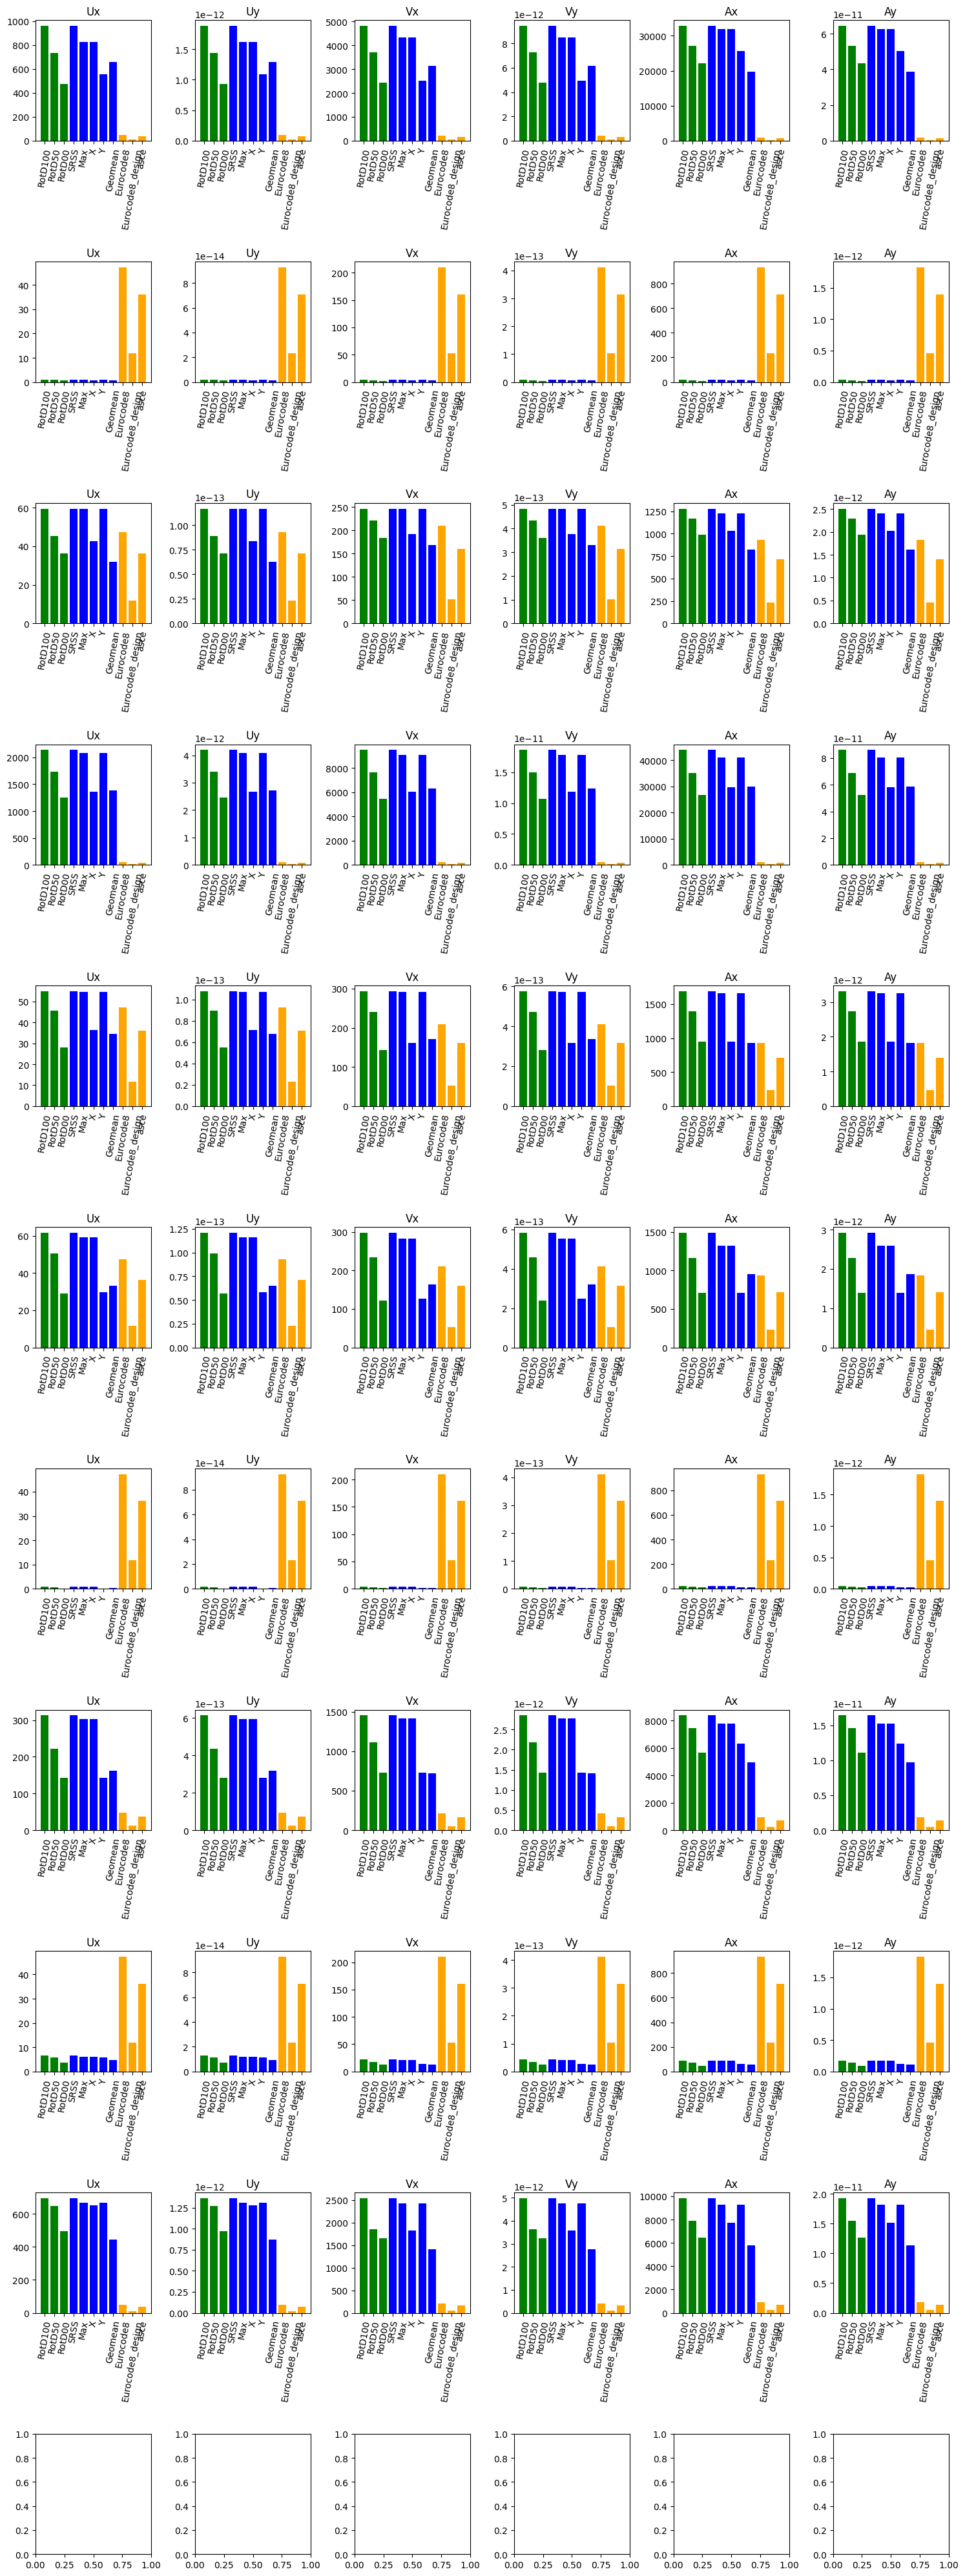

In [39]:
# Barplot of the ROOF displacements for each of the IMs

fig, (axs) = plt.subplots(len(earthquakes_modal_analysis)+1, 6, figsize=(15,40))
row = 0
for earthquake in earthquakes_modal_analysis:
    col = 0
    for magnitude in earthquakes_CQC_combination[earthquake][nodes_left_side[len(nodes_left_side)-1]]:
        ## ---------    Calculate xBar names and y coordinates ------------------------
        xPos = []
        xPosInit = 0
        xBars = []
        y_values = []
        colors = []
        for im in earthquakes_CQC_combination[earthquake][nodes_left_side[len(nodes_left_side)-1]][magnitude]:
            xBars.append(im)
            xPos.append(xPosInit)
            y_values.append(earthquakes_CQC_combination[earthquake][nodes_left_side[len(nodes_left_side)-1]][magnitude][im])
            if im == 'RotD100' or im == 'RotD50' or im == 'RotD00': #orientation-independent
                colors.append('green')
            elif im == 'SRSS' or im == 'Max' or im == 'X' or im == 'Y' or im == 'Geomean': #orientation-dependent
                colors.append('blue')
            else: #eurocode
                colors.append('orange')
            xPosInit += 1
        ## ---------    Draw plot -----------------------------------------------------
        axs[row, col].bar(xPos, y_values, color = colors)
        plt.sca(axs[row, col])
        plt.xticks(xPos, xBars, rotation=80)
        axs[row, col].title.set_text(magnitude)
        
        col += 1

    row += 1

fig.tight_layout(h_pad=2.0, w_pad=1.0)
plt.savefig("cqc.svg")    
plt.show()

## 5. Solve the system and do an analysis of the building (Time History Analysis)

### 5.1. System analysis and solver definition

In [40]:
# analysis definition
dt = 0.02 # is like the precision of the time series
def define_THA_analysis(time, gm1, gm2):
    """
    Configure the analysis type
    
    Parameters
    ------------
    a_ROT : np.array
        array of combinational of transverse and longitudinal GM
    time : np.array
        array of time values
        
    Returns
    --------
    None
    """
    ops.timeSeries('Path', 1, '-dt', dt, '-values', *gm1*g, '-time', *time)
    ops.timeSeries('Path', 2, '-dt', dt, '-values', *gm2*g, '-time', *time)
    ops.pattern('UniformExcitation', 1, 1, '-accel', 1)
    ops.pattern('UniformExcitation', 2, 2, '-accel', 2)
    ops.constraints('Transformation')
    ops.numberer('Plain')
    ops.system('ProfileSPD')
    ops.algorithm('Linear', False, False, True)
    ops.integrator('Newmark', 0.5, 0.25)
    ops.analysis('Transient')    

In [41]:
# Solve system
def solve_system(time, gm1, gm2, analysis_dt, damping, nmodes, studyNodes):
    """
    Solve the opensees system
    
    Parameters
    ------------
    damping : float
        damping value
    a_ROT : np.array
        array of combinational of transverse and longitudinal GM
    time : np.array
        array of time values
    analysis_dt : float
        temporal step for each iteration of the simulation
        
    Returns
    --------
    dictionary
        dictionary with 'displacement', 'velocity' and 'acceleration' keys
    array
        array of natural periods of the structure (T [sec])
    """

    ops.wipe()
    
    # Model Definition
    periods, eigenvecs = model_definition(damping, studyNodes, nmodes)
        
    # Analysis Definition
    define_THA_analysis(time, gm1, gm2)

    node_outputs = {}
    for i in range(len(studyNodes)):
        node_outputs[studyNodes[i]] = {
            'X': {
                'displacement':[],
                'velocity':[], 
                'acceleration':[]
            },
            'Y': {
                'displacement':[],
                'velocity':[], 
                'acceleration':[]
            }
        }
    
    # Solve system
    analysis_time = time[-1]
    while ops.getTime() < analysis_time:
        ops.analyze(1, analysis_dt)
        for i in range(len(studyNodes)):
            node_outputs[studyNodes[i]]['X']['displacement'].append(ops.nodeDisp(studyNodes[i], 1))
            node_outputs[studyNodes[i]]['X']['velocity'].append(ops.nodeVel(studyNodes[i], 1))
            node_outputs[studyNodes[i]]['X']['acceleration'].append(ops.nodeAccel(studyNodes[i], 1))
            
            node_outputs[studyNodes[i]]['Y']['displacement'].append(ops.nodeDisp(studyNodes[i], 2))
            node_outputs[studyNodes[i]]['Y']['velocity'].append(ops.nodeVel(studyNodes[i], 2))
            node_outputs[studyNodes[i]]['Y']['acceleration'].append(ops.nodeAccel(studyNodes[i], 2)) 
        
    return node_outputs, periods

### 5.2. Function to extract maximum values

In [42]:
def get_Max(time, gm1, gm2, analysis_dt, damping, nmodes, studyNodes, theta):
    """
    Obtain ROTD
    
    Parameters
    ------------
    damping : float
        damping value
    a_ROT : np.array
        array of combinational of transverse and longitudinal GM
    time : np.array
        array of time values
    analysis_dt : float
        temporal step for each iteration of the simulation
    theta : float
        angle
        
    Returns
    --------
    dictionary
        dictionary with max 'X' and 'Y'
    array
        array of natural periods of the structure (T [sec])
    """

    numpyfunction = np.max
            
    outputs_x = {
        'displacement':0,
        'velocity':0, 
        'acceleration':0
    }
    
    outputs_y = {
        'displacement':0,
        'velocity':0, 
        'acceleration':0
    }
    outputs_theta_dir = {
        'displacement':0,
        'velocity':0, 
        'acceleration':0
    }
    outputs_xy = {
        'displacement':0,
        'velocity':0, 
        'acceleration':0
    }
    ROTD = {
        'X': outputs_x,
        'Y': outputs_y,
        'theta_dir': outputs_theta_dir,
        'X+Y' : outputs_xy
    }

    a_ROT = create_aROT(gm1, gm2, theta)
    a_ROT_x = a_ROT*math.cos(np.deg2rad(theta))
    a_ROT_y = a_ROT*math.sin(np.deg2rad(theta))
    results, periods = solve_system(time, a_ROT_x, a_ROT_y, analysis_dt, damping, nmodes, studyNodes)


    max_outputs = {}
    for i in range(len(studyNodes)):
        max_outputs[studyNodes[i]] = {
            'X': {
                'displacement':0.0,
                'velocity':0.0, 
                'acceleration':0.0
            },
            'Y': {
                'displacement':0.0,
                'velocity':0.0, 
                'acceleration':0.0
            }
        }

    for node in results:
        max_outputs[node]['X']['displacement'] = np.max(np.abs(np.array(results[node]['X']['displacement'])))
        max_outputs[node]['X']['velocity'] = np.max(np.abs(np.array(results[node]['X']['velocity'])))
        max_outputs[node]['X']['acceleration'] = np.max(np.abs(np.array(results[node]['X']['acceleration'])))
        
        max_outputs[node]['Y']['displacement'] = np.max(np.abs(np.array(results[node]['Y']['displacement'])))
        max_outputs[node]['Y']['velocity'] = np.max(np.abs(np.array(results[node]['Y']['velocity'])))
        max_outputs[node]['Y']['acceleration'] = np.max(np.abs(np.array(results[node]['Y']['acceleration'])))
    
    return results, max_outputs, periods


### 5.3. Time History Analysis to get Roof displacement

In [53]:
# Get ROTD per each rotation angle
st = t.time()

# Choose less values to speed up plot computation
theta_list_analysis = np.linspace(1, 180, 5, endpoint=True)
        
#theta_list_analysis=[]
#for i in range(0, len(theta_list_analysis2), 2): 
#    if theta_list_analysis2[i]%2 == 0: 
#        theta_list_analysis.append(theta_list_analysis2[i])
studyNodes = nodes_left_side

earthquakes_tha = {}
for earthquake in earthquakes_data:
    earthquakes_tha[earthquake] = {}
    for i in range(len(theta_list_analysis)):
        earthquakes_tha[earthquake][theta_list_analysis[i]] = {}
        for n in range(len(studyNodes)):
            earthquakes_tha[earthquake][theta_list_analysis[i]][studyNodes[n]] = {
                'max': {},
                'results': {}
            }


damping = 0.05
nmodes = 10


for earthquake in earthquakes_data:
    for i in tqdm(range(len(theta_list_analysis))):
        results, max_outputs, periods = get_Max(earthquakes_data[earthquake]['GMD_longitudinal']['time'], earthquakes_data[earthquake]['GMD_longitudinal']['gmdata'], earthquakes_data[earthquake]['GMD_transverse']['gmdata'], earthquakes_data[earthquake]['GMD_longitudinal']['dt'], damping, nmodes, studyNodes, theta_list_analysis[i])
        for n in range(len(studyNodes)):
            earthquakes_tha[earthquake][theta_list_analysis[i]][studyNodes[n]]['max'] = max_outputs[studyNodes[n]]
            earthquakes_tha[earthquake][theta_list_analysis[i]][studyNodes[n]]['results'] = results
    
et = t.time()
elapsed_time = et - st
print('Execution time:', elapsed_time/60, 'min')

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 4/5 [12:39:14<3:09:48, 11388.60s/it]


KeyboardInterrupt: 

### 5.4. Parallell: Time History Analysis to get Roof displacement

#### 5.4.1. Parallell function definition

In [43]:
def get_Max_parallell(time, gm1, gm2, analysis_dt, damping, nmodes, studyNodes, theta):
    #---------------------------------------------------------------------------------------
    import openseespy.opensees as ops  # Opensees
    import os  # to read files
    import math
    import numpy as np  #  multidimensional array and matrix data structures
    import matplotlib.pyplot as plt  # to plot the data
    import opsvis as opsv
    import time as t
    from tqdm import tqdm
    import ipyparallel as ipp

    # analysis definition
    dt = 0.02 # is like the precision of the time series
    def define_THA_analysis(time, gm1, gm2):
        """
        Configure the analysis type
        
        Parameters
        ------------
        a_ROT : np.array
            array of combinational of transverse and longitudinal GM
        time : np.array
            array of time values
            
        Returns
        --------
        None
        """
        ops.timeSeries('Path', 1, '-dt', dt, '-values', *gm1*g, '-time', *time)
        ops.timeSeries('Path', 2, '-dt', dt, '-values', *gm2*g, '-time', *time)
        ops.pattern('UniformExcitation', 1, 1, '-accel', 1)
        ops.pattern('UniformExcitation', 2, 2, '-accel', 2)
        ops.constraints('Transformation')
        ops.numberer('Plain')
        ops.system('ProfileSPD')
        ops.algorithm('Linear', False, False, True)
        ops.integrator('Newmark', 0.5, 0.25)
        ops.analysis('Transient')   

    # Solve system
    def solve_system(time, gm1, gm2, analysis_dt, damping, nmodes, studyNodes):
        """
        Solve the opensees system
        
        Parameters
        ------------
        damping : float
            damping value
        a_ROT : np.array
            array of combinational of transverse and longitudinal GM
        time : np.array
            array of time values
        analysis_dt : float
            temporal step for each iteration of the simulation
            
        Returns
        --------
        dictionary
            dictionary with 'displacement', 'velocity' and 'acceleration' keys
        array
            array of natural periods of the structure (T [sec])
        """
    
        ops.wipe()
        
        # Model Definition
        periods, eigenvecs = model_definition(damping, studyNodes, nmodes)
            
        # Analysis Definition
        define_THA_analysis(time, gm1, gm2)
    
        node_outputs = {}
        for i in range(len(studyNodes)):
            node_outputs[studyNodes[i]] = {
                'X': {
                    'displacement':[],
                    'velocity':[], 
                    'acceleration':[]
                },
                'Y': {
                    'displacement':[],
                    'velocity':[], 
                    'acceleration':[]
                }
            }
        
        # Solve system
        analysis_time = time[-1]
        while ops.getTime() < analysis_time:
            ops.analyze(1, analysis_dt)
            for i in range(len(studyNodes)):
                node_outputs[studyNodes[i]]['X']['displacement'].append(ops.nodeDisp(studyNodes[i], 1))
                node_outputs[studyNodes[i]]['X']['velocity'].append(ops.nodeVel(studyNodes[i], 1))
                node_outputs[studyNodes[i]]['X']['acceleration'].append(ops.nodeAccel(studyNodes[i], 1))
                
                node_outputs[studyNodes[i]]['Y']['displacement'].append(ops.nodeDisp(studyNodes[i], 2))
                node_outputs[studyNodes[i]]['Y']['velocity'].append(ops.nodeVel(studyNodes[i], 2))
                node_outputs[studyNodes[i]]['Y']['acceleration'].append(ops.nodeAccel(studyNodes[i], 2)) 
            
        return node_outputs, periods
    
    def create_aROT(aX, aY, theta):
        """
        Create a_ROT
        
        Parameters
        ------------
        aX : np.array
            horizontal acceleration
        aY : np.array
            transversal acceleration
        theta : int
            angle
        
        Returns
        -------
        np.array
            list of a_ROT
        """
        a_ROT = aX*math.cos(np.deg2rad(theta)) + aY*math.sin(np.deg2rad(theta))
        return a_ROT

    # Model definition
    g = 9.81 # gravity [m/s^2]
    
    def model_definition(damping, studyNodes, nmodes=10, printFactors=False):
        """
        Configure the model in opensees
        
        Parameters
        ------------
        mass : float
            mass to put at each story of the building
        damping : float
            damping
        nmodes : int
            number of mode shapes
        Returns
        --------
        array
            array of natural periods of the structure (T [sec])
        """    
        # Model
        ndf = 6
        ops.model('basic', '-ndm', 3, '-ndf', ndf)
                
        # -------------------------------------------------- Create nodes ---------------------------------------------------------------
        ## Create nodes, define mass and define constraints
        
        ## Building parameters:
        storyHeight = 4 # Story Height 4 m
        #storyHeightTop = 0 #Story Height 0 m on the top
        numberOfStories = 13
        bayWidthY = 6
        numberOfBaysX = 1
        numberOfBaysY = 9
    
        storyHeightList = [
            5.5,
            5.5,
            3.5,
            storyHeight,
            storyHeight,
            storyHeight,
            storyHeight,
            storyHeight,
            storyHeight,
            storyHeight,
            storyHeight,
            storyHeight,
            storyHeight,
            storyHeight
        ]
        
        bayWidthX = 12.45
        bayWidthXFront = 11.45
        bayWidthXBack = 12.2
        incrementX = (bayWidthX - bayWidthXFront)/6 
        bayWidthXList = [
            bayWidthXFront, 
            bayWidthX-incrementX*5,
            bayWidthX-incrementX*4,
            bayWidthX-incrementX*3,
            bayWidthX-incrementX*2,
            bayWidthX-incrementX*1,
            bayWidthX, 
            bayWidthX, 
            bayWidthX, 
            bayWidthXBack
        ]
        columnMasslist = [
            2266.69,
            2266.69,
            1442.44,
            1648.5,
            1428.7,
            1428.7,
            1428.7,
            1428.7,
            1010.58,
            1010.58,
            1010.58,
            1010.58,
            1010.58,
            0.00
        ]
        beamMassList_transverse = [
            1411.16,
            1431.7,
            1452.24,
            1472.78,
            1493.32,
            1513.86,
            1534.59,
            1534.59,
            1534.59,
            1503.59
        ]
        beamMass_longitudinal = 740.11
        beamMassConnection = 2403.28
    
        ## ----------------------------------------------- Create left twin tower ---------------------------------------------------------
        coordZ = 0.0
        nodeTag = 1
        for story in range(0, numberOfStories + 1):
            coordX = 0.0 
            for bayX in range(0, numberOfBaysX + 1):
                coordY = 0.0
                for bayY in range(0, numberOfBaysY + 1):
                    if bayX == 0:
                        ops.node(nodeTag, coordX, coordY, coordZ)
                    else:
                        ops.node(nodeTag, bayWidthXList[bayY], coordY, coordZ)
    
                    baseMass = columnMasslist[story]
                    if bayY == 0 or bayY == numberOfBaysY:
                        baseMass = baseMass + beamMassList_transverse[bayY]/2 + beamMass_longitudinal/2
                    else:
                        baseMass = baseMass + beamMassList_transverse[bayY]/2 + beamMass_longitudinal
    
                    nodeMass = baseMass #* (numberOfStories - story)
                    #nodeMass = 2.8
                    ops.mass(nodeTag, nodeMass, nodeMass, 0.0, 0.0, 0.0, 0.0)
                    
                    if story == 0:
                        ops.fix(nodeTag, 1, 1, 1, 0, 0, 0)
    
                    coordY += bayWidthY
                    nodeTag += 1
    
                coordX += bayWidthX
    
            coordZ += storyHeightList[story]
    
        ## ---------- Create right twin tower ----------------
        coordZ = 0.0
        for story in range(0, numberOfStories + 1):
            coordX = 12.45 + 19.5
            for bayX in range(0, numberOfBaysX + 1):
                coordY = 0.0
                for bayY in range(0, numberOfBaysY + 1):
                    if bayX == 0:
                        ops.node(nodeTag, coordX+bayWidthX-bayWidthXList[bayY], coordY, coordZ)
                    else:
                        ops.node(nodeTag, coordX, coordY, coordZ)
    
                    baseMass = columnMasslist[story]
                    if bayY == 0 or bayY == numberOfBaysY:
                        baseMass = baseMass + beamMassList_transverse[bayY]/2 + beamMass_longitudinal/2
                    else:
                        baseMass = baseMass + beamMassList_transverse[bayY]/2 + beamMass_longitudinal
    
                    nodeMass = baseMass #* (numberOfStories - story)
                    #nodeMass = 2.8
                    ops.mass(nodeTag, nodeMass, nodeMass, 0.0, 0.0, 0.0, 0.0)
    
                    if story == 0:
                        ops.fix(nodeTag, 1, 1, 1, 0, 0, 0)
    
                    coordY += bayWidthY
                    nodeTag += 1
    
                coordX += bayWidthX
    
            coordZ += storyHeightList[story]
            
        # ----------------------------------------------------------------  Create column elements -----------------------------------------------------------------------------------------------
        ## Elastic beam column command: ops.element('elasticBeamColumn', elementTag, node_i, node_j, A,E,G,J,Iyy,Izz,geomTransfTag)
        
        ## Element parameters:
        A_column_1 = 0.0525 # Area
        E_column_1 = 210*1e9 #000000000 # Elastic Modulus
        G_column_1 = 80*1e9 # Shear Modulus
        Iyy_column_1 = 0.0008054375039 #*1e12 # Moment of Inertia in yy axis
        Izz_column_1 = 0.001676937472 #*1e12 # Moment of Inertia in zz axis
        J_column_1 = 0.0016552799 #*1e12 # Polar Moment of Inertia
        
        A_column_2 = 0.0455 # Area
        E_column_2 = 210*1e9 # Elastic Modulus
        G_column_2 = 80*1e9 # Shear Modulus
        Iyy_column_2 = 0.00066257913599 #*1e12 # Moment of Inertia in yy axis
        Izz_column_2 = 0.000957979136 #*1e12 # Moment of Inertia in zz axis
        J_column_2 = 0.0011792944 #*1e12
        
        A_column_3 = 0.032184 # Area
        E_column_3 = 210*1e9 # Elastic Modulus
        G_column_3 = 80*1e9 # Shear Modulus
        Iyy_column_3 = 0.000468234784 #*1e12 # Moment of Inertia in yy axis
        Izz_column_3 = 0.000492275232 #*1e12 # Moment of Inertia in zz axis
        J_column_3 = 0.0007199803 #*1e12
        
        ## Transformation:
        geomTransfTagColumns = 1
        ops.geomTransf('Linear', geomTransfTagColumns, 1, 0, 0)
        
        ## Build elements:
        ### ---------- Create left twin tower ----------------
        elementTag = 1
        nodeTag_i = 1
        for story in range(0, numberOfStories):
            for bayX in range(0, numberOfBaysX + 1):
                for bayY in range(0, numberOfBaysY + 1):
                    nodeTag_j = nodeTag_i + (numberOfBaysX+1)*(numberOfBaysY+1)
                    
                    if story <= 3:
                        ops.element('elasticBeamColumn', elementTag, nodeTag_i, nodeTag_j, A_column_1, E_column_1, G_column_1, J_column_1, Iyy_column_1, Izz_column_1, geomTransfTagColumns)
                    elif 4 <= story <= 7:
                        ops.element('elasticBeamColumn', elementTag, nodeTag_i, nodeTag_j, A_column_2, E_column_2, G_column_2, J_column_2, Iyy_column_2, Izz_column_2, geomTransfTagColumns)
                    elif story >= 8:
                        ops.element('elasticBeamColumn', elementTag, nodeTag_i, nodeTag_j, A_column_3, E_column_3, G_column_3, J_column_3, Iyy_column_3, Izz_column_3, geomTransfTagColumns)
                        
                    elementTag += 1
                    nodeTag_i += 1
                        
        ### ---------- Create right twin tower ----------------
        numberOfNodesLeftTower = (numberOfBaysX+1)*(numberOfBaysY+1)*(numberOfStories+1)
        nodeTag_i = numberOfNodesLeftTower + 1
        for story in range(0, numberOfStories):
            for bayX in range(0, numberOfBaysX + 1):
                for bayY in range(0, numberOfBaysY + 1):
                    nodeTag_j = nodeTag_i + (numberOfBaysX+1)*(numberOfBaysY+1)
                    
                    if story <= 3:
                        ops.element('elasticBeamColumn', elementTag, nodeTag_i, nodeTag_j, A_column_1, E_column_1, G_column_1, J_column_1, Iyy_column_1, Izz_column_1, geomTransfTagColumns)
                    elif 4 <= story <= 7:
                        ops.element('elasticBeamColumn', elementTag, nodeTag_i, nodeTag_j, A_column_2, E_column_2, G_column_2, J_column_2, Iyy_column_2, Izz_column_2, geomTransfTagColumns)
                    elif story >= 8:
                        ops.element('elasticBeamColumn', elementTag, nodeTag_i, nodeTag_j, A_column_3, E_column_3, G_column_3, J_column_3, Iyy_column_3, Izz_column_3, geomTransfTagColumns)
                        
                    elementTag += 1
                    nodeTag_i += 1
        # ----------------------------------------------------------------  Create beam elements X parallel ----------------------------------------------------------------------         
        
        ## Element parameters:
        A_beam_x = 0.016
        E_beam_x = 210*1e9
        G_beam_x = 80*1e9
        Iyy_beam_x = 0.0014362583333 #*1e12
        Izz_beam_x = 0.0000675583333 #*1e12
        J_beam_x = 0.0000008983 #*1e12
        
        ## Transformation:
        geomTransfTagXBeams = 2
        ops.geomTransf('Linear', geomTransfTagXBeams, 0, 0, 1)
    
        ## Build elements:
        ### ---------- Create left twin tower ----------------
        numberOfNodesPerStory = (numberOfBaysX+1)*(numberOfBaysY+1)
        nodeTag_i = 1 + numberOfNodesPerStory # 1st node story 1
        for story in range(1, numberOfStories + 1):
            for bayX in range(0, numberOfBaysX):
                for bayY in range(0, numberOfBaysY + 1):
                    nodeTag_j = nodeTag_i + (numberOfBaysY+1)
                    ops.element('elasticBeamColumn', elementTag, nodeTag_i, nodeTag_j, A_beam_x, E_beam_x, G_beam_x, J_beam_x, Iyy_beam_x, Izz_beam_x, geomTransfTagXBeams)
                    #ops.rigidLink('beam', nodeTag_i, nodeTag_j)
                    elementTag += 1
                    nodeTag_i += 1
            
            nodeTag_i += (numberOfBaysY+1)
    
        ### ---------- Create right twin tower ----------------
        numberOfNodesPerStory = (numberOfBaysX+1)*(numberOfBaysY+1)
        nodeTag_i = numberOfNodesLeftTower + 1 + numberOfNodesPerStory # 1st node story 1
        for story in range(1, numberOfStories + 1):
            for bayX in range(0, numberOfBaysX):
                for bayY in range(0, numberOfBaysY + 1):
                    nodeTag_j = nodeTag_i + (numberOfBaysY+1)
                    ops.element('elasticBeamColumn', elementTag, nodeTag_i, nodeTag_j, A_beam_x, E_beam_x, G_beam_x, J_beam_x, Iyy_beam_x, Izz_beam_x, geomTransfTagXBeams)
                    #ops.rigidLink('beam', nodeTag_i, nodeTag_j)
                    elementTag += 1
                    nodeTag_i += 1
            
            nodeTag_i += (numberOfBaysY+1)
        # -------------------------------------------------------------------------------  Create beam elements Y parallel -----------------------------------------------------------
        
        ## Element parameters:
        A_beam_y = 0.016
        E_beam_y = 210*1e9 #
        G_beam_y = 80*1e9 #000000000 #
        Iyy_beam_y = 0.0014362583333 #*1e12
        Izz_beam_y = 0.0000675583333 #*1e12
        J_beam_y = 0.0000008983 #*1e12
        
        ## Transformation:
        geomTransfTagYBeams = 3
        ops.geomTransf('Linear', geomTransfTagYBeams, 0, 0, 1)
        
        ## Build elements:
        ### ---------- Create left twin tower ----------------
        numberOfNodesPerStory = (numberOfBaysX+1)*(numberOfBaysY+1)
        nodeTag_i = 1 + numberOfNodesPerStory # 1st node story 1
        for story in range(1, numberOfStories + 1):
            for bayX in range(0, numberOfBaysX+1):
                for bayY in range(0, numberOfBaysY):
                    nodeTag_j = nodeTag_i + 1
                    ops.element('elasticBeamColumn', elementTag, nodeTag_i, nodeTag_j, A_beam_y, E_beam_y, G_beam_y, J_beam_y, Iyy_beam_y, Izz_beam_y, geomTransfTagYBeams)
                    #ops.rigidLink('beam', nodeTag_i, nodeTag_j)
                    elementTag += 1
                    nodeTag_i += 1
                nodeTag_i += 1
        ### ---------- Create right twin tower ----------------
        numberOfNodesPerStory = (numberOfBaysX+1)*(numberOfBaysY+1)
        nodeTag_i = numberOfNodesLeftTower + 1 + numberOfNodesPerStory # 1st node story 1
        for story in range(1, numberOfStories + 1):
            for bayX in range(0, numberOfBaysX+1):
                for bayY in range(0, numberOfBaysY):
                    nodeTag_j = nodeTag_i + 1
                    ops.element('elasticBeamColumn', elementTag, nodeTag_i, nodeTag_j, A_beam_y, E_beam_y, G_beam_y, J_beam_y, Iyy_beam_y, Izz_beam_y, geomTransfTagYBeams)
                    #ops.rigidLink('beam', nodeTag_i, nodeTag_j)
                    elementTag += 1
                    nodeTag_i += 1
                nodeTag_i += 1
    
        ### ---------- Create connection between towers ----------------
        nodeTag_i = 37
        for story in range(1, numberOfStories + 1):
            for bayY in range(0, 3):
                nodeTag_j = nodeTag_i - 10 + numberOfNodesLeftTower
                ops.element('elasticBeamColumn', elementTag, nodeTag_i, nodeTag_j, A_beam_y, E_beam_y, G_beam_y, J_beam_y, Iyy_beam_y, Izz_beam_y, geomTransfTagYBeams)
                #ops.rigidLink('beam', nodeTag_i, nodeTag_j)
    
                mass_nodeTag_i = ops.nodeMass(nodeTag_i, 1)
                extraMass = mass_nodeTag_i + beamMassConnection #*(numberOfStories - story)
                ops.mass(nodeTag_i, extraMass, extraMass, 0.0, 0.0, 0.0, 0.0)
    
                mass_nodeTag_j = ops.nodeMass(nodeTag_j, 1)
                extraMass = mass_nodeTag_j + beamMassConnection #*(numberOfStories - story)
                ops.mass(nodeTag_j, extraMass, extraMass, 0.0, 0.0, 0.0, 0.0)
                
                ops.equalDOF(nodeTag_i, nodeTag_j, 1,2,3)
                elementTag += 1
                nodeTag_i += 1
            nodeTag_i = nodeTag_i - 3 + 20
    
        # ------------------------------------------------------------------------------------------ Define Rayleigh damping -------------------------------------------------------------------------
        eigenVals = ops.eigen(nmodes)#'-fullGenLapack',nmodes)
        omega = math.sqrt(eigenVals[0]) # frequency
        alpha_m = 2*damping*omega
        ops.rayleigh(alpha_m, 0, 0, 0)
    
        #----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
        
        periods = []
        for p in range(nmodes):
            omega = math.sqrt(eigenVals[p])
            Tn = 2*math.pi/omega
            periods.append(2*math.pi/omega)
            
            Mn = 0.0
            Ln = 0.0
            for nd in ops.getNodeTags():
               ndMass = ops.nodeMass(nd)
               ndEigen = ops.nodeEigenvector(nd,p+1)
               Ln += ndEigen[0]*ndMass[0] # 0 for X, 1 for Y, 2 for Z excitation
               for dof in range(ndf):
                  Mn += (ndEigen[dof]**2)*ndMass[dof]
            Gamman = Ln/Mn
            if printFactors:
                print(f'Mode {p+1}, Tn = {Tn}, Mn = {Mn}, Gamma = {Gamman}')
    
        eigenvectors = {} #dict with eigenvectors at node studyNode --> ket=node value = { key=nmode and value=eigenvectors for each dof }
        for i in range(len(studyNodes)):
            eigvecs = {}
            for p in range(nmodes):
                eigvecs[p+1] = ops.nodeEigenvector(studyNodes[i],p+1)
            eigenvectors[studyNodes[i]] = eigvecs
        return periods, eigenvectors
    #---------------------------------------------------------------------------------------
    """
    Obtain ROTD
    
    Parameters
    ------------
    damping : float
        damping value
    a_ROT : np.array
        array of combinational of transverse and longitudinal GM
    time : np.array
        array of time values
    analysis_dt : float
        temporal step for each iteration of the simulation
    theta : float
        angle
        
    Returns
    --------
    dictionary
        dictionary with max 'X' and 'Y'
    array
        array of natural periods of the structure (T [sec])
    """

    numpyfunction = np.max
            
    outputs_x = {
        'displacement':0,
        'velocity':0, 
        'acceleration':0
    }
    
    outputs_y = {
        'displacement':0,
        'velocity':0, 
        'acceleration':0
    }
    outputs_theta_dir = {
        'displacement':0,
        'velocity':0, 
        'acceleration':0
    }
    outputs_xy = {
        'displacement':0,
        'velocity':0, 
        'acceleration':0
    }
    ROTD = {
        'X': outputs_x,
        'Y': outputs_y,
        'theta_dir': outputs_theta_dir,
        'X+Y' : outputs_xy
    }

    a_ROT = create_aROT(gm1, gm2, theta)
    a_ROT_x = a_ROT*math.cos(np.deg2rad(theta))
    a_ROT_y = a_ROT*math.sin(np.deg2rad(theta))
    results, periods = solve_system(time, a_ROT_x, a_ROT_y, analysis_dt, damping, nmodes, studyNodes)


    max_outputs = {}
    for i in range(len(studyNodes)):
        max_outputs[studyNodes[i]] = {
            'X': {
                'displacement':0.0,
                'velocity':0.0, 
                'acceleration':0.0
            },
            'Y': {
                'displacement':0.0,
                'velocity':0.0, 
                'acceleration':0.0
            }
        }

    for node in results:
        max_outputs[node]['X']['displacement'] = np.max(np.abs(np.array(results[node]['X']['displacement'])))
        max_outputs[node]['X']['velocity'] = np.max(np.abs(np.array(results[node]['X']['velocity'])))
        max_outputs[node]['X']['acceleration'] = np.max(np.abs(np.array(results[node]['X']['acceleration'])))
        
        max_outputs[node]['Y']['displacement'] = np.max(np.abs(np.array(results[node]['Y']['displacement'])))
        max_outputs[node]['Y']['velocity'] = np.max(np.abs(np.array(results[node]['Y']['velocity'])))
        max_outputs[node]['Y']['acceleration'] = np.max(np.abs(np.array(results[node]['Y']['acceleration'])))
    
    return results, max_outputs, periods


#### 5.4.2. Parallell computation

In [44]:
# Parallel struct
earthquakes_parallel = {}
for earthquake in earthquakes_data:
    earthquakes_parallel[earthquake] = {}

In [45]:
studyNodes = nodes_left_side

In [46]:
theta_list_analysis = np.linspace(1, 180, 45, endpoint=True)

In [47]:
# Struct to fill after parallel computation
earthquakes_tha = {}
for earthquake in earthquakes_data:
    earthquakes_tha[earthquake] = {}
    for i in range(len(theta_list_analysis)):
        earthquakes_tha[earthquake][theta_list_analysis[i]] = {}
        for n in range(len(studyNodes)):
            earthquakes_tha[earthquake][theta_list_analysis[i]][studyNodes[n]] = {
                'max': {},
                'results': {}
            }

In [48]:
# Parallel function: repeat all needed data inside
def calculateTheta(theta, earthquake_data_eartquake, studyNodes, functionGetMax):
    # ------------------------------------------      Needed data for parallel ------------------------------------------------------------------
    local = {}
    local[theta] = {}
    damping = 0.05
    nmodes = 10
    # --------------------------------------------------- Computation for theta -------------------------------------------------------------------------------
    results, max_outputs, periods = functionGetMax(earthquake_data_eartquake['GMD_longitudinal']['time'], earthquake_data_eartquake['GMD_longitudinal']['gmdata'], earthquake_data_eartquake['GMD_transverse']['gmdata'], earthquake_data_eartquake['GMD_longitudinal']['dt'], damping, nmodes, studyNodes, theta)
    
    for n in range(len(studyNodes)):
        local[theta][studyNodes[n]] = {}
        local[theta][studyNodes[n]]['max'] = max_outputs[studyNodes[n]]
        local[theta][studyNodes[n]]['results'] = results
    return local

In [49]:
st = t.time()
parallel_earthquakes_data = {}
for earthquake in earthquakes_data:
    parallel_earthquakes_data[earthquake] = []
    for i in range(len(theta_list_analysis)):
        parallel_earthquakes_data[earthquake].append(earthquakes_data[earthquake])
        
parallel_nodes_data = [nodes_left_side] * len(theta_list_analysis)

parallel_getMax_data = [get_Max_parallell] * len(theta_list_analysis)
       
for earthquake in earthquakes_parallel:
    with ipp.Cluster() as rc:
        # get a view on the cluster
        view = rc.load_balanced_view()
        # submit the tasks
        asyncresult = view.map_async(calculateTheta, theta_list_analysis, parallel_earthquakes_data[earthquake], parallel_nodes_data, parallel_getMax_data)
        # wait interactively for results
        asyncresult.wait_interactive()
        # retrieve actual results
        result = asyncresult.get()
        earthquakes_parallel[earthquake] = result
    
et = t.time()
elapsed_time = et - st
print('Execution time:', elapsed_time/60, 'min')

Starting 32 engines with <class 'ipyparallel.cluster.launcher.LocalEngineSetLauncher'>
calculateTheta:   0%|             | 0/45 [05:07<?, ?tasks/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



calculateTheta:   0%|             | 0/45 [07:57<?, ?tasks/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



calculateTheta:   0%|             | 0/45 [22:33<?, ?tasks/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



calculateTheta:   0%|           | 0/45 [1:04:59<?, ?tasks/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



calculateTheta:   0%|           | 0/45 [1:16:04<?, ?tasks/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



calculateTheta: 100%|█| 45/45 [15:03:31<00:00, 1204.70s/task
Stopping engine(s): 1685781478
engine set stopped 1685781478: {'engines': {'0': {'exit_code': 0, 'pid': 2941186, 'identifier': '0'}, '1': {'exit_code': 0, 'pid': 2941188, 'identifier': '1'}, '2': {'exit_code': 0, 'pid': 2941190, 'identifier': '2'}, '3': {'exit_code': 0, 'pid': 2941192, 'identifier': '3'}, '4': {'exit_code': 0, 'pid': 2941194, 'identifier': '4'}, '5': {'exit_code': 0, 'pid': 2941204, 'identifier': '5'}, '6': {'exit_code': 0, 'pid': 2941210, 'identifier': '6'}, '7': {'exit_code': 0, 'pid': 2941216, 'identifier': '7'}, '8': {'exit_code': 0, 'pid': 2941219, 'identifier': '8'}, '9': {'exit_code': 0, 'pid': 2941234, 'identifier': '9'}, '10': {'exit_code': 0, 'pid': 2941250, 'identifier': '10'}, '11': {'exit_code': 0, 'pid': 2941256, 'identifier': '11'}, '12': {'exit_code': 0, 'pid': 2941272, 'identifier': '12'}, '13': {'exit_code': 0, 'pid': 2941288, 'identifier': '13'}, '14': {'exit_code': 0, 'pid': 2941304, 'iden

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



calculateTheta: 100%|█| 45/45 [4:06:02<00:00, 328.05s/tasks]
Stopping engine(s): 1685917728
engine set stopped 1685917728: {'engines': {'0': {'exit_code': 0, 'pid': 4131385, 'identifier': '0'}, '1': {'exit_code': 0, 'pid': 4131387, 'identifier': '1'}, '2': {'exit_code': 0, 'pid': 4131397, 'identifier': '2'}, '3': {'exit_code': 0, 'pid': 4131413, 'identifier': '3'}, '4': {'exit_code': 0, 'pid': 4131425, 'identifier': '4'}, '5': {'exit_code': 0, 'pid': 4131435, 'identifier': '5'}, '6': {'exit_code': 0, 'pid': 4131455, 'identifier': '6'}, '7': {'exit_code': 0, 'pid': 4131468, 'identifier': '7'}, '8': {'exit_code': 0, 'pid': 4131484, 'identifier': '8'}, '9': {'exit_code': 0, 'pid': 4131509, 'identifier': '9'}, '10': {'exit_code': 0, 'pid': 4131529, 'identifier': '10'}, '11': {'exit_code': 0, 'pid': 4131549, 'identifier': '11'}, '12': {'exit_code': 0, 'pid': 4131565, 'identifier': '12'}, '13': {'exit_code': 0, 'pid': 4131581, 'identifier': '13'}, '14': {'exit_code': 0, 'pid': 4131597, 'iden

In [50]:
# Fill earthquakes_tha struct
for earthquake in earthquakes_parallel:
    for item in earthquakes_parallel[earthquake]:
        for angle in item:
            earthquakes_tha[earthquake][angle] = item[angle]

In [59]:
import pickle
with open('earthquakes_tha.txt', 'wb') as handle:
  pickle.dump(earthquakes_tha, handle)

In [ ]:
for key in earthquakes_tha:
    with open('earthquakes_tha_{eth}.txt'.format(eth=key), 'wb') as handle:
        pickle.dump(earthquakes_tha[key], handle)

### 5.5. PLOT ROOF NODE

In [51]:
plot_data_roof_node = {}
for earthquake in earthquakes_tha:
    plot_data_roof_node[earthquake] = {
        'displacement': {
            'X': [],
            'Y': []
        },
        'velocity': {
            'X': [],
            'Y': []
        },
        'acceleration': {
            'X': [],
            'Y': []
        }
    }
for earthquake in earthquakes_tha:
    for angle in earthquakes_tha[earthquake]:
        plot_data_roof_node[earthquake]['displacement']['X'].append(earthquakes_tha[earthquake][angle][studyNodes[len(studyNodes)-1]]['max']['X']['displacement'])
        plot_data_roof_node[earthquake]['displacement']['Y'].append(earthquakes_tha[earthquake][angle][studyNodes[len(studyNodes)-1]]['max']['Y']['displacement'])

        plot_data_roof_node[earthquake]['velocity']['X'].append(earthquakes_tha[earthquake][angle][studyNodes[len(studyNodes)-1]]['max']['X']['velocity'])
        plot_data_roof_node[earthquake]['velocity']['Y'].append(earthquakes_tha[earthquake][angle][studyNodes[len(studyNodes)-1]]['max']['Y']['velocity'])

        plot_data_roof_node[earthquake]['acceleration']['X'].append(earthquakes_tha[earthquake][angle][studyNodes[len(studyNodes)-1]]['max']['X']['acceleration'])
        plot_data_roof_node[earthquake]['acceleration']['Y'].append(earthquakes_tha[earthquake][angle][studyNodes[len(studyNodes)-1]]['max']['Y']['acceleration'])

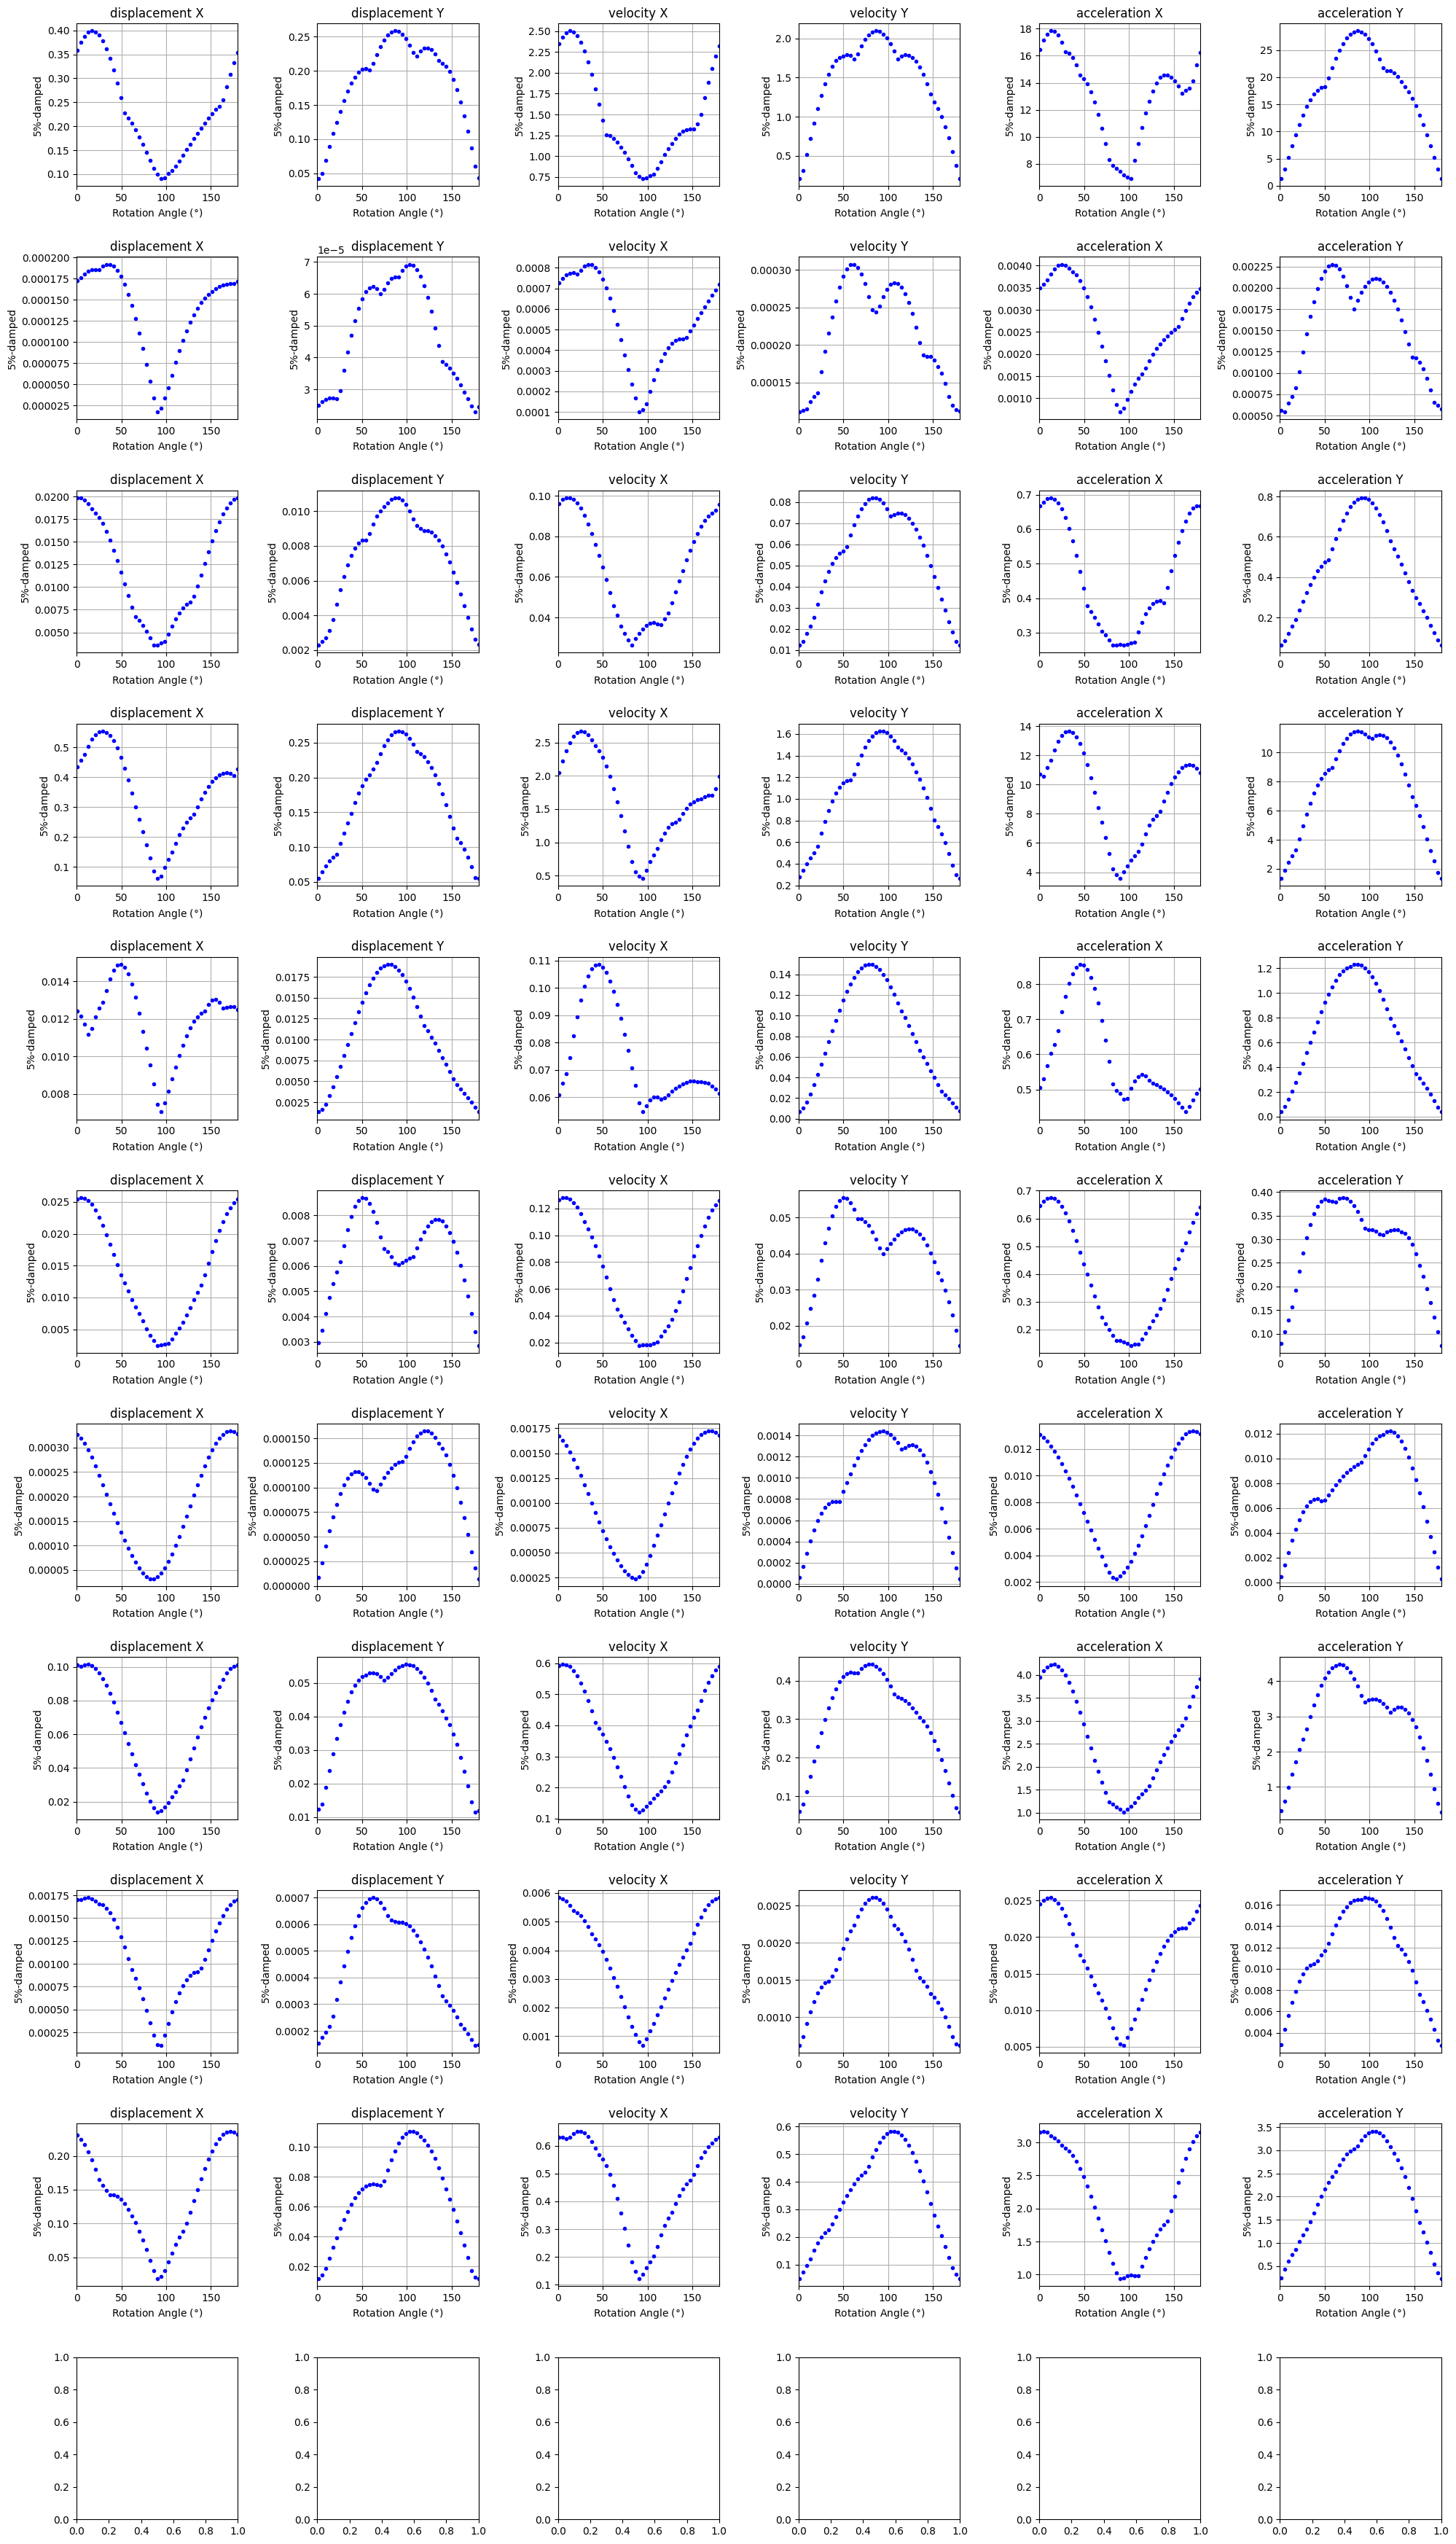

In [52]:
fig, (axs) = plt.subplots(len(earthquakes_tha)+1, 6, figsize=(20,35))
row = 0
for earthquake in plot_data_roof_node:
    col = 0
    for key in plot_data_roof_node[earthquake]:
        for dir in plot_data_roof_node[earthquake][key]:
            axs[row,col].plot(theta_list_analysis, plot_data_roof_node[earthquake][key][dir],".",color='blue')
            axs[row,col].set(ylabel='5%-damped', xlabel='Rotation Angle ($\degree$)')
            axs[row,col].title.set_text('{key} {dir}'.format(key=key, dir=dir))
            axs[row,col].grid()
            #axs[row,col].legend()
            axs[row,col].set_xlim(left=0)
            axs[row,col].set_xlim(right=max(theta_list_analysis))
            col += 1 
    row += 1

plt.savefig("roof node.svg")    
fig.tight_layout(h_pad=2.0, w_pad=1.0)
plt.show()

## 6. COMPARE BOTH METHODS: MODAL ANALYSIS VS TIME HISTORY ANALYSIS

In [53]:
# Time Story Analysis Values to add to the bar plot
earthquakes_THA_roof_node = {}
for earthquake in earthquakes_data:
    earthquakes_THA_roof_node[earthquake] = {
        'Ux': 0.0,
        'Uy': 0.0,
        'Vx': 0.0,
        'Vy': 0.0,
        'Ax': 0.0,
        'Ay': 0.0 
    }

In [54]:
for earthquake in earthquakes_THA_roof_node:
    earthquakes_THA_roof_node[earthquake]['Ux'] = np.max(np.array(plot_data_roof_node[earthquake]['displacement']['X']))*1e3
    earthquakes_THA_roof_node[earthquake]['Uy'] = np.max(np.array(plot_data_roof_node[earthquake]['displacement']['Y']))*1e3
    earthquakes_THA_roof_node[earthquake]['Vx'] = np.max(np.array(plot_data_roof_node[earthquake]['velocity']['X']))*1e3
    earthquakes_THA_roof_node[earthquake]['Vy'] = np.max(np.array(plot_data_roof_node[earthquake]['velocity']['Y']))*1e3
    earthquakes_THA_roof_node[earthquake]['Ax'] = np.max(np.array(plot_data_roof_node[earthquake]['acceleration']['X']))*1e3
    earthquakes_THA_roof_node[earthquake]['Ay'] = np.max(np.array(plot_data_roof_node[earthquake]['acceleration']['Y']))*1e3

In [55]:
earthquakes_THA_roof_node

{'Tabas': {'Ux': 398.8939573807439,
  'Uy': 258.3792327260057,
  'Vx': 2502.4883913322,
  'Vy': 2096.8228043660984,
  'Ax': 17830.176617458277,
  'Ay': 28513.026212703004},
 'Roermond_Netherlands': {'Ux': 0.19175945256642493,
  'Uy': 0.06924416758595094,
  'Vx': 0.8166285569764369,
  'Vy': 0.30753600594603386,
  'Ax': 4.030048249448886,
  'Ay': 2.2772582637068175},
 'LA_Hollywood': {'Ux': 19.86668685976225,
  'Uy': 10.778958439078838,
  'Vx': 99.06720302670055,
  'Vy': 82.0732258238265,
  'Ax': 691.3994242390271,
  'Ay': 794.4413825376877},
 'Nicaragua': {'Ux': 554.5073816947553,
  'Uy': 266.7265475399003,
  'Vx': 2674.115980992609,
  'Vy': 1627.8222112188294,
  'Ax': 13677.378838853883,
  'Ay': 11474.381802487984},
 'Italy_2': {'Ux': 14.916100805972988,
  'Uy': 18.988226483635884,
  'Vx': 108.61364482112022,
  'Vy': 149.7338323411344,
  'Ax': 856.5341837606297,
  'Ay': 1232.638284471399},
 'Georgia': {'Ux': 25.675100553946795,
  'Uy': 8.69972075522936,
  'Vx': 128.1292015447609,
  'Vy

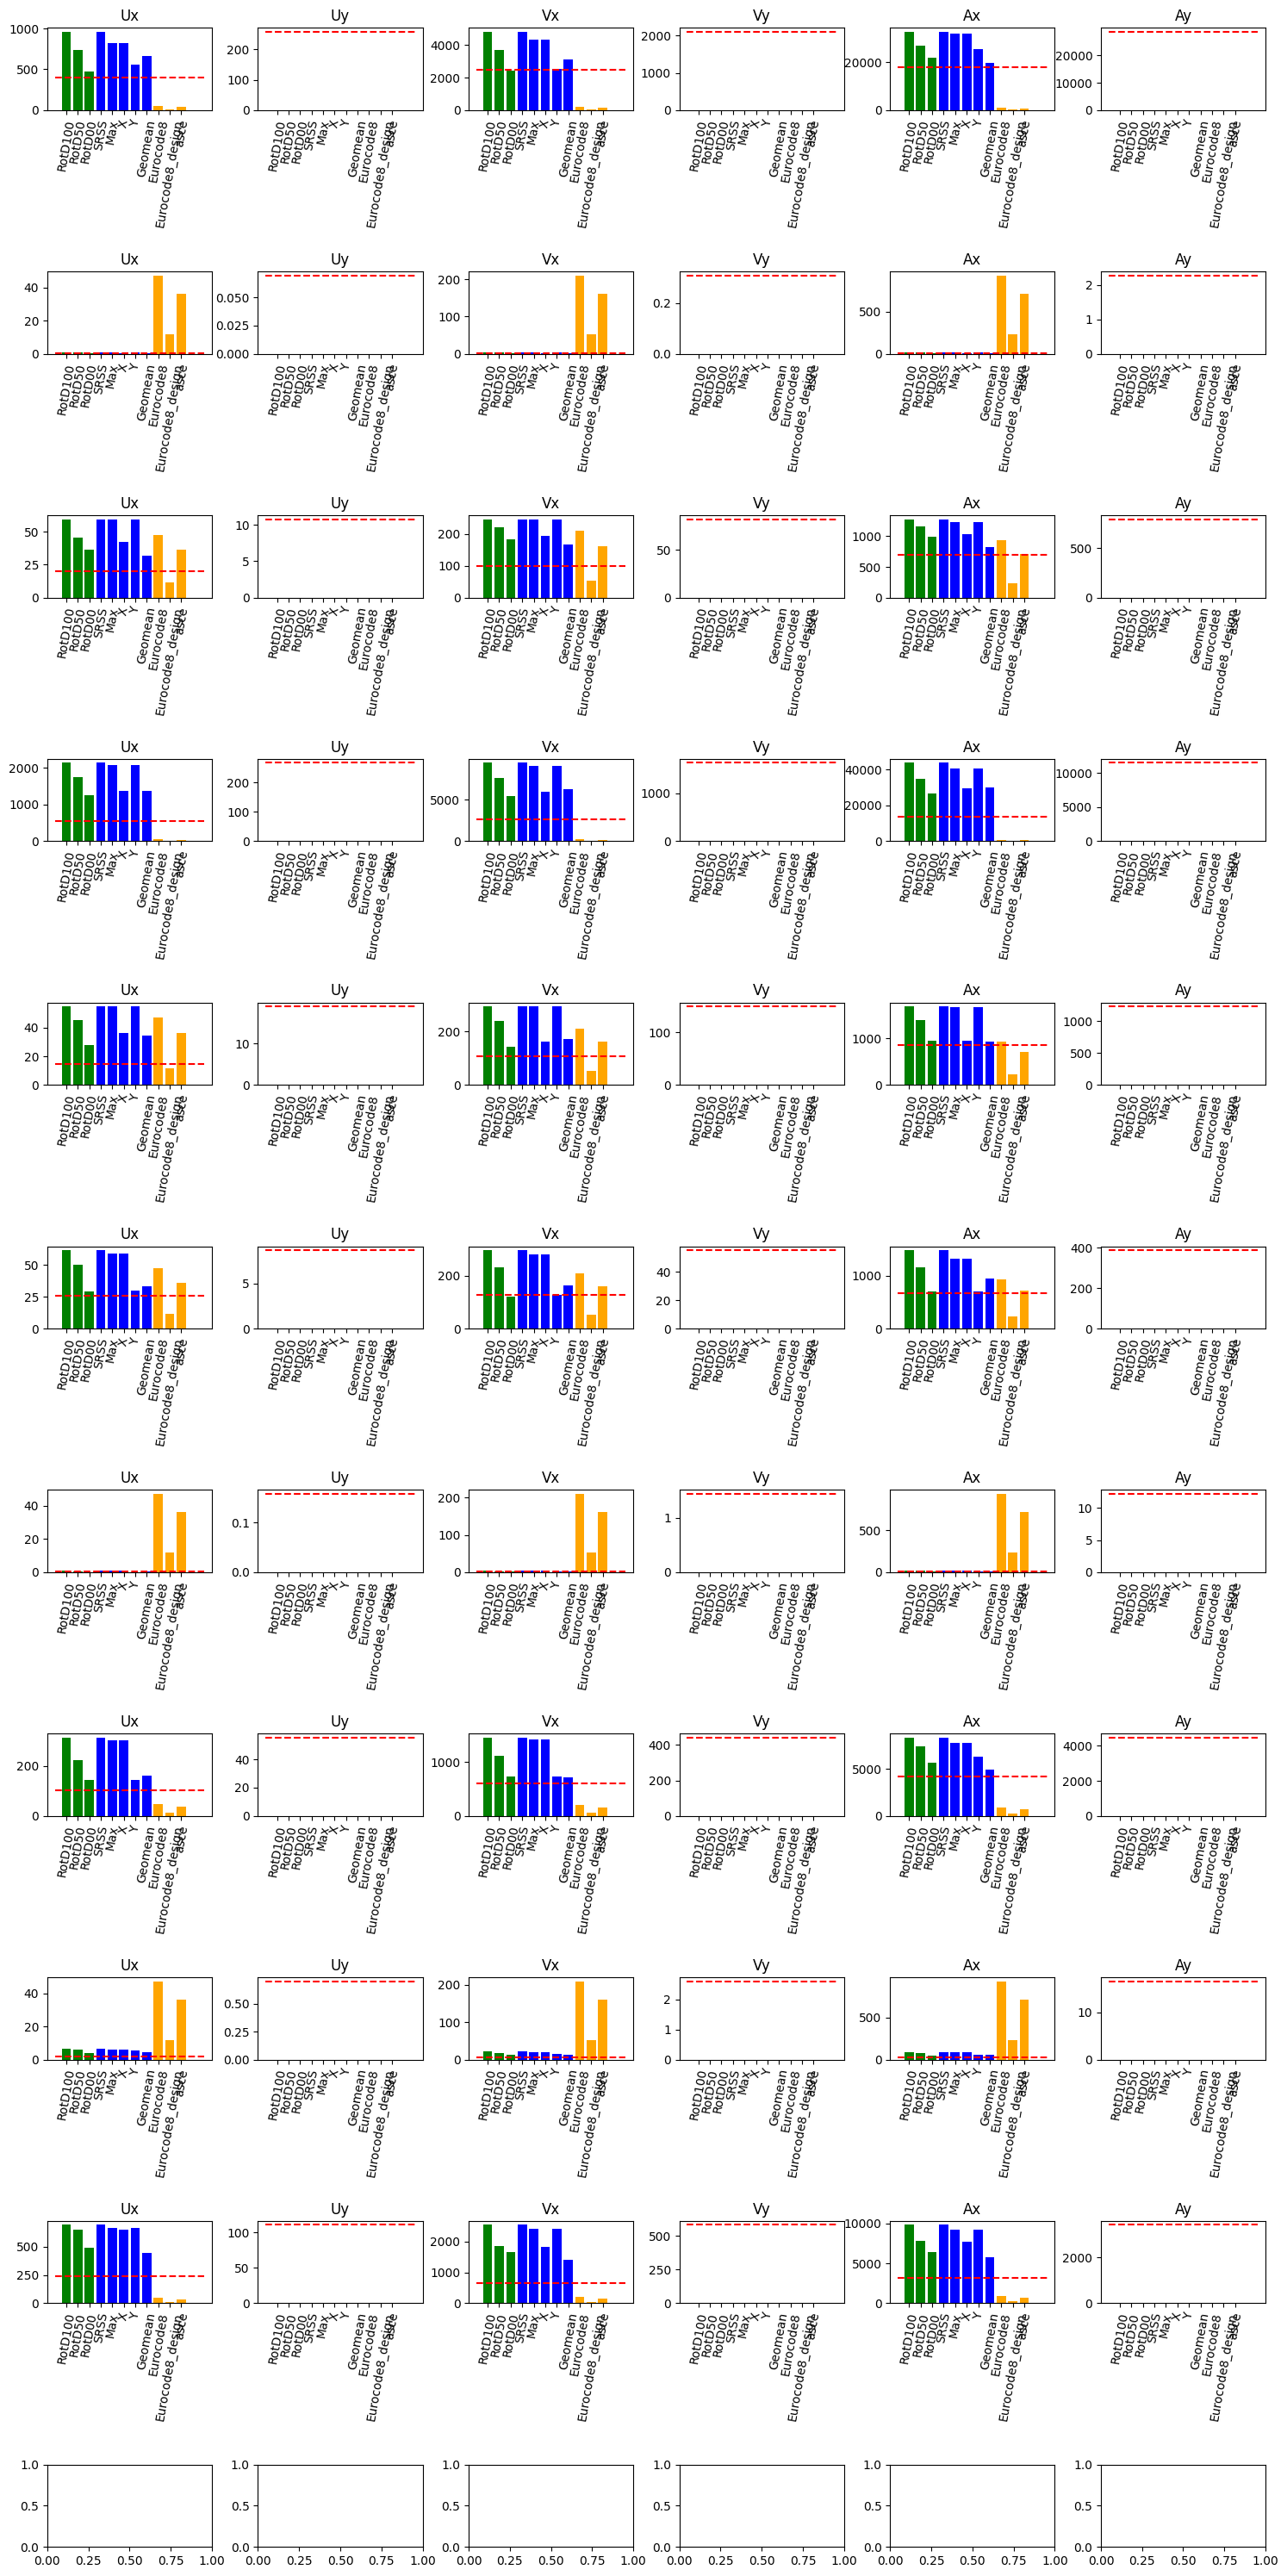

In [56]:
# Barplot of the ROOF displacements for each of the IMs (CQC METHOD)

fig, (axs) = plt.subplots(len(earthquakes_modal_analysis)+1, 6, figsize=(15,30))
row = 0
for earthquake in earthquakes_modal_analysis:
    col = 0
    for magnitude in earthquakes_CQC_combination[earthquake][nodes_left_side[len(nodes_left_side)-1]]:
        ## ---------    Calculate xBar names and y coordinates ------------------------
        xPos = []
        xPosInit = 0
        xBars = []
        y_values = []
        colors = []
        for im in earthquakes_CQC_combination[earthquake][nodes_left_side[len(nodes_left_side)-1]][magnitude]:
            xBars.append(im)
            xPos.append(xPosInit)
            y_values.append(earthquakes_CQC_combination[earthquake][nodes_left_side[len(nodes_left_side)-1]][magnitude][im])
            if im == 'RotD100' or im == 'RotD50' or im == 'RotD00': #orientation-independent
                colors.append('green')
            elif im == 'SRSS' or im == 'Max' or im == 'X' or im == 'Y' or im == 'Geomean': #orientation-dependent
                colors.append('blue')
            else: #eurocode
                colors.append('orange')
            xPosInit += 1
        ## ---------    Draw plot -----------------------------------------------------
        axs[row, col].bar(xPos, y_values, color = colors)
        plt.sca(axs[row, col])
        plt.xticks(xPos, xBars, rotation=80)
        axs[row, col].title.set_text(magnitude)
        axs[row,col].plot([-1, len(xPos)+1], [earthquakes_THA_roof_node[earthquake][magnitude], earthquakes_THA_roof_node[earthquake][magnitude]], "r--")
        
        col += 1

    row += 1

fig.tight_layout(h_pad=2.0, w_pad=0.0)
plt.show()

### Node displacement vs earthquake

In [73]:
ethqke_name = 'Tabas'
angle = theta_list_analysis[10]

plt.figure(figsize=(12,2.5)) #select the visualization size of the plot
ax1=plt.subplot(211)
plt.setp(ax1.get_xticklabels(),visible=False)
plt.plot(earthquakes_data[ethqke_name]['GMD_longitudinal']['time'][:250], earthquakes_tha[ethqke_name][angle][nodes_left_side[len(nodes_left_side)-1]]['results'][nodes_left_side[len(nodes_left_side)-1]]['X']['displacement'], color='c', label='X')
plt.plot(earthquakes_data[ethqke_name]['GMD_longitudinal']['time'][:250], earthquakes_tha[ethqke_name][angle][nodes_left_side[len(nodes_left_side)-1]]['results'][nodes_left_side[len(nodes_left_side)-1]]['Y']['displacement'], color='b', label='Y')
plt.ylabel('$u(t)$')
plt.title('Ground Motion Tabas')
plt.grid()
plt.xlim(left=0)
plt.legend()

plt.figure(figsize=(12,2.5)) #select the visualization size of the plot
ax1=plt.subplot(211)
plt.setp(ax1.get_xticklabels(),visible=False)
plt.plot(earthquakes_data[ethqke_name]['GMD_longitudinal']['time'][:250], earthquakes_data[ethqke_name]['GMD_longitudinal']['gmdata'][:250], color='c', label='X')
plt.plot(earthquakes_data[ethqke_name]['GMD_longitudinal']['time'][:250], earthquakes_data[ethqke_name]['GMD_transverse']['gmdata'][:250], color='c', label='X')
plt.ylabel('$u(t)$')
plt.title('Ground Motion Tabas')
plt.grid()
plt.xlim(left=0)
plt.legend()

IndexError: index 10 is out of bounds for axis 0 with size 10